In [43]:
import os
import re
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

def get_concurrency_parallelism(cc_value):
    value = int(sqrt(cc_value))
    return value, value

def process_log_file(full_path):
   
    if os.stat(full_path).st_size == 0:
        print(f"Skipping empty file: {filename}")
        return 0
    with open(full_path, 'r') as file:
        data = []
        last_non_zero_throughput = None
        for line in file:
#             match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+) CC:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:(\d+\.\d+)', line)
            match = re.search(r'(\d+\.\d+).*Throughput @(\d+\.\d+)s:\s+(\d+\.\d+)Gbps, lossRate: (\d+\.\d+|\d+) CC:(\d+)\s+score:(-?\d+\.\d+)\s+rtt:(\d+\.\d+) ms energy:(\d+\.\d+) Jules s-plr:([\deE.-]+)', line)
            if match:
                time = datetime.fromtimestamp(float(match.group(1)))
                throughput = "{:.6f}".format(float(match.group(3)))
                loss_rate = "{:.6f}".format(float(match.group(4)))
                cc = int(match.group(5))
                score = "{:.6f}".format(float(match.group(6)))
                rtt = "{:.6f}".format(float(match.group(7)))
                energy = "{:.6f}".format(float(match.group(8)))
                sender_lr = "{:.6f}".format(float(match.group(9)))

                # If you need them as floats and not strings
                throughput = float(throughput)
                loss_rate = float(loss_rate)
                score = float(score)
                rtt = float(rtt)
                energy = float(energy)
                sender_lr = float(sender_lr)
                concurrency, parallelism = get_concurrency_parallelism(cc)
                data.append([time, throughput, loss_rate, cc, score, rtt, energy, sender_lr, concurrency, parallelism])

        if data:
            df = pd.DataFrame(data, columns=['Time', 'Throughput', 'receiver_lr', 'CC', 'Score', 'RTT', 'Energy', 'sender_lr', 'concurrency', 'parallelism'])
            
        else:
            df=pd.DataFrame()
            print(f"No valid data in file: {filename}")
    
    return df


def find_transitions(df, column_name, start_value, target_value):
    # Create a new empty DataFrame with the same columns
    new_df = pd.DataFrame(columns=df.columns)
    # Flag to mark if we are currently in a transition block
    in_transition = False
    # Iterate through the DataFrame
    for index, row in df.iterrows():
        # Check for transition start
        if row[column_name] == start_value and not in_transition:
            in_transition = True
        # Check for transition end
        elif row[column_name] == target_value and in_transition:
            new_df = new_df.append(row)
        # If the value is neither start nor target, reset the flag
        elif row[column_name] != start_value:
            in_transition = False

    return new_df


def process_directory(directory_path):
    all_dfs = []  # List to hold all DataFrames from each log file
    for filename in os.listdir(directory_path):
        # Construct the full path to the file
        full_path = os.path.join(directory_path, filename)
        # Check if it's a file and has a log extension (if your log files have a specific extension)
        if os.path.isfile(full_path):  # and filename.endswith(".log"):
            print(f"Processing file: {filename}")
            df = process_log_file(full_path)
            if not df.empty:
                all_dfs.append(df)
            else:
                print(f"Empty or invalid data in file: {filename}")

    # Concatenate all DataFrames if not empty
    if all_dfs:
        final_df = pd.concat(all_dfs, ignore_index=True)
        return final_df
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no data was found

def print_empty_dataframes(dfs):
    total_rows=0
    for key, df in dfs.items():
        if df.empty:
            print(f"The DataFrame for key '{key}' is empty.")
        else:
            num_rows = len(df)
            total_rows+=num_rows
            print(f"The DataFrame for key '{key}' has {num_rows} rows")
    print(f"\n\n\nThere are toatl {total_rows} rows in all the transitions dictionaries")
  

In [51]:
!pwd

shell-init: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory
pwd: error retrieving current directory: getcwd: cannot access parent directories: No such file or directory


In [45]:
directory="/home/jamilm/transferService/RL_agents/PPO_self_implementation/stored_log/"
df=process_directory(directory)

Processing file: ppo_self_norm_max_min_logFile_01_14_2024_22_18_49.log
Processing file: ppo_self_10_4000_logFile_01_11_2024_16_36_54.log
Processing file: ppo_self_norm_max_min_score_max_logFile_01_15_2024_19_47_33.log
Processing file: ppo_self_10_2000_logFile_01_11_2024_16_34_46.log


In [46]:

print("##################################################################")
print("Original df")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')

lowest_five = df['Score'].nsmallest(10)
print(lowest_five)

indices_to_drop = df.nsmallest(4, 'Score').index

# Drop these rows from the DataFrame
df = df.drop(indices_to_drop)
print("##################################################################")
print("df after removing least score rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Throughput'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing throughput ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')


df= df[(df['Energy'] != 0)]
df.reset_index(drop=True, inplace=True)
print("##################################################################")
print("df after removing Energy ==0 rows")
print("##################################################################")
print(df.describe())
# Get minimum values of each column as a NumPy array
min_values = df.min().values

# Get maximum values of each column as a NumPy array
max_values = df.max().values

print(f'min_values : {min_values[1:]}')
print(f'max_values : {max_values[1:]}')

##################################################################
Original df
##################################################################
         Throughput   receiver_lr            CC         Score           RTT  \
count  95635.000000  95635.000000  95635.000000  95635.000000  95635.000000   
mean       2.538605      0.000533     24.738370      2.015245     33.685777   
std        2.773888      0.022158     20.424584     71.624941      6.114659   
min        0.000000      0.000000      1.000000 -22108.000000      0.000000   
25%        0.320000      0.000000      4.000000      0.000000     32.700000   
50%        1.600000      0.000000     25.000000      1.000000     32.800000   
75%        3.840000      0.000000     36.000000      3.000000     33.800000   
max       20.480000      2.000000     64.000000     20.000000     89.900000   

             Energy     sender_lr   concurrency   parallelism  
count  95635.000000  95635.000000  95635.000000  95635.000000  
mean      52.8

# Transferring DataFrame to Transaction Dictionaries

In [ ]:

# cluster_dictionary={}
# column_name='concurrency'
# value_list=[]
# for i in range(1, 9):
#     for j in range(1, 9):
#         if i!=j:
#             start_value=i
#             target_value=j
#             value=f'{column_name}_{str(start_value)}_{str(target_value)}'
#             print(value)
#             value_list.append(value)
#             cluster_dictionary[value]=find_transitions(df,column_name,start_value,target_value)

       

In [ ]:
print_empty_dataframes(cluster_dictionary)

In [49]:
import pickle
# with open('dataframes.pickle', 'wb') as handle:
#     pickle.dump(cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [53]:
with open('/home/jamilm/transferService/RL_agents/PPO_self_implementation/transferSimulatorDesign/dataframes.pickle', 'rb') as handle:
    loaded_dfs = pickle.load(handle)

print_empty_dataframes(loaded_dfs)          

The DataFrame for key 'concurrency_1_2' has 1657 rows
The DataFrame for key 'concurrency_1_3' has 1548 rows
The DataFrame for key 'concurrency_1_4' has 2084 rows
The DataFrame for key 'concurrency_1_5' has 3356 rows
The DataFrame for key 'concurrency_1_6' has 1508 rows
The DataFrame for key 'concurrency_1_7' has 1930 rows
The DataFrame for key 'concurrency_1_8' has 2122 rows
The DataFrame for key 'concurrency_2_1' has 1640 rows
The DataFrame for key 'concurrency_2_3' has 505 rows
The DataFrame for key 'concurrency_2_4' has 1146 rows
The DataFrame for key 'concurrency_2_5' has 1865 rows
The DataFrame for key 'concurrency_2_6' has 831 rows
The DataFrame for key 'concurrency_2_7' has 1073 rows
The DataFrame for key 'concurrency_2_8' has 862 rows
The DataFrame for key 'concurrency_3_1' has 1393 rows
The DataFrame for key 'concurrency_3_2' has 536 rows
The DataFrame for key 'concurrency_3_4' has 1019 rows
The DataFrame for key 'concurrency_3_5' has 1385 rows
The DataFrame for key 'concurren

# Transferring DataFrame to initial value dictionaries

In [54]:
def filter_df_by_value(df_original, column_name, value):
    """
    Filters the DataFrame based on a specific value in a given column and creates an independent copy.

    :param df_original: The original DataFrame.
    :param column_name: The name of the column to filter on.
    :param value: The value to filter by in the specified column.
    :return: A new DataFrame containing rows where the column matches the value.
    """
    filtered_df = df_original[df_original[column_name] == value].copy()
    return filtered_df

initial_value_cluster_dictionary={}
column_name='concurrency'
for i in range(1, 9):  
    start_value=i
    value=f'{column_name}_{str(start_value)}'
    print(value)
    initial_value_cluster_dictionary[value]=filter_df_by_value(df,column_name,start_value)

print_empty_dataframes(initial_value_cluster_dictionary)          


concurrency_1
concurrency_2
concurrency_3
concurrency_4
concurrency_5
concurrency_6
concurrency_7
concurrency_8
The DataFrame for key 'concurrency_1' has 14680 rows
The DataFrame for key 'concurrency_2' has 6844 rows
The DataFrame for key 'concurrency_3' has 6033 rows
The DataFrame for key 'concurrency_4' has 10130 rows
The DataFrame for key 'concurrency_5' has 16334 rows
The DataFrame for key 'concurrency_6' has 8593 rows
The DataFrame for key 'concurrency_7' has 10002 rows
The DataFrame for key 'concurrency_8' has 8728 rows



There are toatl 81344 rows in all the transitions dictionaries


In [ ]:
# with open('initial_dataframes.pickle', 'wb') as handle:
#     pickle.dump(initial_value_cluster_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [55]:
with open('/home/jamilm/transferService/RL_agents/PPO_self_implementation/transferSimulatorDesign/initial_dataframes.pickle', 'rb') as handle:
    loaded_initial_dfs = pickle.load(handle)

print_empty_dataframes(loaded_initial_dfs)          

The DataFrame for key 'concurrency_1' has 14680 rows
The DataFrame for key 'concurrency_2' has 6844 rows
The DataFrame for key 'concurrency_3' has 6033 rows
The DataFrame for key 'concurrency_4' has 10130 rows
The DataFrame for key 'concurrency_5' has 16334 rows
The DataFrame for key 'concurrency_6' has 8593 rows
The DataFrame for key 'concurrency_7' has 10002 rows
The DataFrame for key 'concurrency_8' has 8728 rows



There are toatl 81344 rows in all the transitions dictionaries


In [56]:
def sample_row_and_neighbors(df, column_name):
    """
    Samples a row based on the distribution of a specific column and returns it with its 4 neighboring rows.

    :param df: The DataFrame to sample from.
    :param column_name: The column whose distribution to use for sampling.
    :return: A DataFrame containing the sampled row and its 4 neighbors.
    """
#     print(f"length of the df {len(df)}")
    # Calculate the frequency distribution of the column
    df=df.reset_index(drop=True)
    probabilities = df[column_name].value_counts(normalize=True)
    
    # Map these probabilities back to the DataFrame's index
    probabilities = df[column_name].map(probabilities)
#     print(f"probabilities {column_name} {type(probabilities)}  ")
    # Sample one row using these probabilities
#     sampled_index = df.sample(n=1, weights=probabilities).index[0]
    # Sample one row using these probabilities
    sampled_row = df.sample(n=1, weights=probabilities)
#     print(f"sampled_row: {sampled_row}")
    sampled_index = sampled_row.index[0]
    # Ensure the sampled index is within the DataFrame's range
    if sampled_index >= len(df):
        raise ValueError("Sampled index is out of DataFrame's range.")

#     print(f"sampled_index {sampled_index}")
    # Determine the range of indices to return
    if sampled_index < 5:
        start_index = sampled_index
        end_index = min(sampled_index + 4, len(df) - 1)
    else:
        start_index = sampled_index - 4
        end_index = sampled_index
#     print(f"start_index {start_index} end_index {end_index}")
    # Select the range from start_index to end_index
    return df.iloc[start_index:end_index + 1]

In [57]:
def normalize_and_flatten(df, min_values, max_values):
    # Drop the specified columns
    df = df.drop(columns=['Time', 'CC'])
    score_array = df['Score'].values
    energy_array=df['Energy'].values
    throughput_array=df['Throughput'].values
#     print(df.describe())
    # Normalize each column
    normalized_df = (df - min_values) / (max_values - min_values)

    # Flatten the DataFrame to a single NumPy array
    flattened_array = normalized_df.values.flatten()

    return flattened_array,score_array,energy_array,throughput_array

In [58]:
import gym
from gym import spaces
import numpy as np

class transferClass_energy_optimized(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self,transaction_dfs,initial_dfs,optimizer,total_steps=20,min_values=[0.32, 0.0, -75.0, 0.0, 40.0, 0.0, 1, 1],max_values = [20.48, 2.0, 20.0, 89.9, 110.0, 2.0, 8, 8]):
        super().__init__()
        self.action_array= [(1,1),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8)]
        self.transaction_dfs = transaction_dfs
        self.initial_dfs= initial_dfs
        self.action_space = spaces.Discrete(9) # example action space
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(40,), dtype=np.float32) # example observation space
        self.current_observation = np.zeros(40,) # initialize current observation
        self.optimizer=optimizer
        self.old_action=None
        self.step_number=0
        self.total_steps=total_steps
        self.sampling_metric='Score'
        self.min_values=np.array(min_values)
        self.max_values=np.array(max_values)
        self.previous_reward=0
        self.total_energy=0
        self.erergy_sla=6000
        self.obs_df=[]

    def reset(self):
        self.current_observation = np.zeros(40,) # initialize current observation
        self.old_action=None
        self.step_number=0
        self.previous_reward=0
        self.obs_df=[]
        self.total_energy=0
        return self.current_observation

    def step(self, action):
        if action==0:
            action=1
        
        if self.old_action==None:
            done=False
            key_name=f'concurrency_{action}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array) - energy_penalty
            self.old_action=action
        
        elif self.old_action==action:
            done=False
            key_name=f'concurrency_{action}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array) - energy_penalty
            self.old_action=action
        
        else:
            done=False
            key_name=f'concurrency_{self.old_action}_{action}'
            observation_df=sample_row_and_neighbors(self.transaction_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array) - energy_penalty
            self.old_action=action
            
        self.step_number+=1
        
        if self.step_number>=self.total_steps:
            done=True
        observation=observation.astype(np.float32)
        self.current_observation=observation
        return self.current_observation, reward, done, {}

    def bayes_step(self,action):
        params = [1 if x<1 else int(np.round(x)) for x in action]
        print("Bayes Step: ",params)
        if params[0] > 8:
            params[0] = 8
        obs,score_b,done_b,__=self.step(params[0])
        print("Bayes Step Score: ", score_b)
        return np.round(score_b * (-1))

    def render(self, mode="human"):
        pass

    def close(self):
        self.reset()


# Test The environment

In [59]:
env=transferClass_energy_optimized(loaded_dfs,loaded_initial_dfs,'random')
total_scores=0
s = env.reset()
action_list=[]
reward_list=[]
done = False
while not done:
    a=env.action_space.sample()
    s_next, r, done, info = env.step(a)
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    s = s_next
# print(f"env.obs_df {env.obs_df}")
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed

env.close()
print(f"Total Reward: {total_scores}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(accumulator_df)

Total Reward: 33.34400000000001
actions [0, 0, 2, 0, 8, 8, 5, 8, 0, 5, 3, 0, 6, 5, 6, 0, 2, 8, 4, 1],   20
rewards [0.384, 0.384, 0.64, 0.96, 0.6399999999999999, 2.112, 1.344, 2.752, 1.152, 1.7920000000000003, 3.008, 1.0240000000000002, 0.32, 3.136, 0.96, 1.28, 0.96, 0.704, 5.696, 4.096],  20
                            Time  Throughput  receiver_lr CC  Score   RTT  \
10393 2024-01-15 19:10:37.615597        0.32          0.0  1    0.0  32.7   
10394 2024-01-15 19:10:38.618350        0.32          0.0  1    0.0  32.7   
10395 2024-01-15 19:10:39.619024        0.64          0.0  1    1.0  32.7   
10396 2024-01-15 19:10:40.618844        0.32          0.0  1    0.0  32.7   
10397 2024-01-15 19:10:41.621487        0.32          0.0  1    0.0  32.7   
...                          ...         ...          ... ..    ...   ...   
188   2024-01-14 20:20:02.630484        3.84          0.0  1    4.0  32.7   
189   2024-01-14 20:20:03.633961        4.48          0.0  1    4.0  32.7   
190   2024-01

In [60]:
import sys
import copy
import random
import time
from pathlib import Path
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback,CheckpointCallback,CallbackList
import torch as th
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import time
import os
from torch.utils.tensorboard import SummaryWriter

In [21]:
env=transferClass_energy_optimized(loaded_dfs,loaded_initial_dfs,'random')
evaluation_env=transferClass_energy_optimized(loaded_dfs,loaded_initial_dfs,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])
string_='_energy_optimized'
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log=f"./ppo_tensorboard_{string_}/",ent_coef=0.01)
eval_callback = EvalCallback(evaluation_env, best_model_save_path=f'./ppo_{string_}/ppo_best_model/',
                               log_path=f'./ppo_{string_}/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=f'./ppo_{string_}/ppo_checkpoints/',
                                           name_prefix='ppo_model')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=1000000, callback=callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2024-02-05 17:47:47.949414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 17:47:48.018773: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 17:47:48.033490: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 17:47:48.394353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Logging to ./ppo_tensorboard__energy_optimized/PPO_1
Eval num_timesteps=1000, episode_reward=26.43 +/- 4.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 26.4     |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=2000, episode_reward=26.61 +/- 4.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 26.6     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 11.8     |
| time/              |          |
|    fps             | 411      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=3000, episode_reward=26.98 +/- 3.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 27          |
| time/                   |             |
|    total_timesteps      | 3000        |
| train/                  |             |
|    approx_kl            | 0.012516949 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.19       |
|    explained_variance   | -0.000445   |
|    learning_rate        | 0.0003      |
|    l

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=4000, episode_reward=25.74 +/- 5.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 25.7     |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 16.7     |
| time/              |          |
|    fps             | 439      |
|    iterations      | 2        |
|    time_elapsed    | 9        |
|    total_timesteps | 4096     |
---------------------------------
Eval num_timesteps=5000, episode_reward=-9.84 +/- 50.98
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | -9.84        |
| time/                   |              |
|    total_timesteps      | 5000         |
| train/                  |              |
|    approx_kl            | 0.0110980645 |
|    clip_fraction        | 0.0717       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.17        |
|    explained_variance   | 0.0244       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000, episode_reward=-11.48 +/- 79.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -11.5    |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 22.4     |
| time/              |          |
|    fps             | 448      |
|    iterations      | 3        |
|    time_elapsed    | 13       |
|    total_timesteps | 6144     |
---------------------------------
Eval num_timesteps=7000, episode_reward=36.06 +/- 4.41
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.1        |
| time/                   |             |
|    total_timesteps      | 7000        |
| train/                  |             |
|    approx_kl            | 0.010969723 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.15       |
|    explained_variance   | 0.0209      |
|    learning_rate        | 0.0003      |
|    loss                 | 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=8000, episode_reward=30.82 +/- 4.35
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 30.8     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 20.8     |
| time/              |          |
|    fps             | 455      |
|    iterations      | 4        |
|    time_elapsed    | 18       |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=9000, episode_reward=40.13 +/- 3.80
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.1        |
| time/                   |             |
|    total_timesteps      | 9000        |
| train/                  |             |
|    approx_kl            | 0.011961451 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 0.0258      |
|    learning_rate        | 0.0003      |
|    loss                 | 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=10000, episode_reward=24.67 +/- 34.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 24.7     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 458      |
|    iterations      | 5        |
|    time_elapsed    | 22       |
|    total_timesteps | 10240    |
---------------------------------
Eval num_timesteps=11000, episode_reward=24.84 +/- 4.82
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.8        |
| time/                   |             |
|    total_timesteps      | 11000       |
| train/                  |             |
|    approx_kl            | 0.010665166 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.12       |
|    explained_variance   | 0.0065      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=12000, episode_reward=7.26 +/- 34.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 7.26     |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.7     |
| time/              |          |
|    fps             | 461      |
|    iterations      | 6        |
|    time_elapsed    | 26       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=13000, episode_reward=27.20 +/- 3.28
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 27.2        |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.008573249 |
|    clip_fraction        | 0.0675      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.0269      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=14000, episode_reward=27.42 +/- 5.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 27.4     |
| time/              |          |
|    total_timesteps | 14000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 20.5     |
| time/              |          |
|    fps             | 463      |
|    iterations      | 7        |
|    time_elapsed    | 30       |
|    total_timesteps | 14336    |
---------------------------------
Eval num_timesteps=15000, episode_reward=22.44 +/- 4.68
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 22.4         |
| time/                   |              |
|    total_timesteps      | 15000        |
| train/                  |              |
|    approx_kl            | 0.0130351465 |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.11        |
|    explained_variance   | 0.0256       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=16000, episode_reward=24.83 +/- 3.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 24.8     |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30       |
| time/              |          |
|    fps             | 465      |
|    iterations      | 8        |
|    time_elapsed    | 35       |
|    total_timesteps | 16384    |
---------------------------------
Eval num_timesteps=17000, episode_reward=3.35 +/- 76.36
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 3.35        |
| time/                   |             |
|    total_timesteps      | 17000       |
| train/                  |             |
|    approx_kl            | 0.012592863 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.00966     |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=18000, episode_reward=-11.78 +/- 75.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -11.8    |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 22.3     |
| time/              |          |
|    fps             | 466      |
|    iterations      | 9        |
|    time_elapsed    | 39       |
|    total_timesteps | 18432    |
---------------------------------
Eval num_timesteps=19000, episode_reward=11.14 +/- 50.01
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 11.1       |
| time/                   |            |
|    total_timesteps      | 19000      |
| train/                  |            |
|    approx_kl            | 0.00880779 |
|    clip_fraction        | 0.0602     |
|    clip_range           | 0.2        |
|    entropy_loss         | -2.08      |
|    explained_variance   | 0.0291     |
|    learning_rate        | 0.0003     |
|    loss                 | 206        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=3.98 +/- 72.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 3.98     |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.5     |
| time/              |          |
|    fps             | 467      |
|    iterations      | 10       |
|    time_elapsed    | 43       |
|    total_timesteps | 20480    |
---------------------------------
Eval num_timesteps=21000, episode_reward=4.95 +/- 51.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 4.95        |
| time/                   |             |
|    total_timesteps      | 21000       |
| train/                  |             |
|    approx_kl            | 0.011305379 |
|    clip_fraction        | 0.0815      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.1        |
|    explained_variance   | 0.0266      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=22000, episode_reward=9.59 +/- 48.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 9.59     |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 24.9     |
| time/              |          |
|    fps             | 467      |
|    iterations      | 11       |
|    time_elapsed    | 48       |
|    total_timesteps | 22528    |
---------------------------------
Eval num_timesteps=23000, episode_reward=9.68 +/- 46.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 9.68        |
| time/                   |             |
|    total_timesteps      | 23000       |
| train/                  |             |
|    approx_kl            | 0.011005526 |
|    clip_fraction        | 0.0876      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.07       |
|    explained_variance   | 0.0288      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=24000, episode_reward=-51.74 +/- 90.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -51.7    |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 22.5     |
| time/              |          |
|    fps             | 467      |
|    iterations      | 12       |
|    time_elapsed    | 52       |
|    total_timesteps | 24576    |
---------------------------------
Eval num_timesteps=25000, episode_reward=38.02 +/- 5.41
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38           |
| time/                   |              |
|    total_timesteps      | 25000        |
| train/                  |              |
|    approx_kl            | 0.0071469382 |
|    clip_fraction        | 0.0672       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.05        |
|    explained_variance   | 0.0278       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=26000, episode_reward=41.74 +/- 5.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.7     |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28       |
| time/              |          |
|    fps             | 468      |
|    iterations      | 13       |
|    time_elapsed    | 56       |
|    total_timesteps | 26624    |
---------------------------------
Eval num_timesteps=27000, episode_reward=-26.39 +/- 67.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | -26.4       |
| time/                   |             |
|    total_timesteps      | 27000       |
| train/                  |             |
|    approx_kl            | 0.012792807 |
|    clip_fraction        | 0.0719      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.0319      |
|    learning_rate        | 0.0003      |
|  

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=28000, episode_reward=-49.63 +/- 97.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -49.6    |
| time/              |          |
|    total_timesteps | 28000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.7     |
| time/              |          |
|    fps             | 468      |
|    iterations      | 14       |
|    time_elapsed    | 61       |
|    total_timesteps | 28672    |
---------------------------------
Eval num_timesteps=29000, episode_reward=38.31 +/- 6.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.3        |
| time/                   |             |
|    total_timesteps      | 29000       |
| train/                  |             |
|    approx_kl            | 0.010720132 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=18.16 +/- 40.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 18.2     |
| time/              |          |
|    total_timesteps | 30000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 469      |
|    iterations      | 15       |
|    time_elapsed    | 65       |
|    total_timesteps | 30720    |
---------------------------------
Eval num_timesteps=31000, episode_reward=38.36 +/- 4.99
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 38.4       |
| time/                   |            |
|    total_timesteps      | 31000      |
| train/                  |            |
|    approx_kl            | 0.01102742 |
|    clip_fraction        | 0.136      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.96      |
|    explained_variance   | 0.0318     |
|    learning_rate        | 0.0003     |
|    loss                 | 68         |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=32000, episode_reward=-0.29 +/- 77.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -0.294   |
| time/              |          |
|    total_timesteps | 32000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 470      |
|    iterations      | 16       |
|    time_elapsed    | 69       |
|    total_timesteps | 32768    |
---------------------------------
Eval num_timesteps=33000, episode_reward=15.61 +/- 42.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 15.6        |
| time/                   |             |
|    total_timesteps      | 33000       |
| train/                  |             |
|    approx_kl            | 0.011151905 |
|    clip_fraction        | 0.0985      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.0243      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=34000, episode_reward=34.41 +/- 6.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.4     |
| time/              |          |
|    total_timesteps | 34000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.6     |
| time/              |          |
|    fps             | 470      |
|    iterations      | 17       |
|    time_elapsed    | 73       |
|    total_timesteps | 34816    |
---------------------------------
Eval num_timesteps=35000, episode_reward=-6.14 +/- 81.95
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | -6.14       |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.008819404 |
|    clip_fraction        | 0.0787      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.0407      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=36000, episode_reward=36.36 +/- 4.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.4     |
| time/              |          |
|    total_timesteps | 36000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.9     |
| time/              |          |
|    fps             | 471      |
|    iterations      | 18       |
|    time_elapsed    | 78       |
|    total_timesteps | 36864    |
---------------------------------
Eval num_timesteps=37000, episode_reward=37.25 +/- 3.85
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.2        |
| time/                   |             |
|    total_timesteps      | 37000       |
| train/                  |             |
|    approx_kl            | 0.010228531 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.0343      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=38000, episode_reward=36.62 +/- 6.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 38000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 471      |
|    iterations      | 19       |
|    time_elapsed    | 82       |
|    total_timesteps | 38912    |
---------------------------------
Eval num_timesteps=39000, episode_reward=16.65 +/- 39.36
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 16.6        |
| time/                   |             |
|    total_timesteps      | 39000       |
| train/                  |             |
|    approx_kl            | 0.012474397 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0314      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=-36.79 +/- 69.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -36.8    |
| time/              |          |
|    total_timesteps | 40000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.1     |
| time/              |          |
|    fps             | 472      |
|    iterations      | 20       |
|    time_elapsed    | 86       |
|    total_timesteps | 40960    |
---------------------------------
Eval num_timesteps=41000, episode_reward=32.41 +/- 2.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.4        |
| time/                   |             |
|    total_timesteps      | 41000       |
| train/                  |             |
|    approx_kl            | 0.012195108 |
|    clip_fraction        | 0.0905      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.0376      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=42000, episode_reward=35.90 +/- 2.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 42000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=43000, episode_reward=17.59 +/- 38.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 17.6     |
| time/              |          |
|    total_timesteps | 43000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30       |
| time/              |          |
|    fps             | 471      |
|    iterations      | 21       |
|    time_elapsed    | 91       |
|    total_timesteps | 43008    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=44000, episode_reward=14.62 +/- 39.96
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 14.6         |
| time/                   |              |
|    total_timesteps      | 44000        |
| train/                  |              |
|    approx_kl            | 0.0052464516 |
|    clip_fraction        | 0.0317       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.85        |
|    explained_variance   | 0.0321       |
|    learning_rate        | 0.0003       |
|    loss                 | 323          |
|    n_updates            | 210          |
|    policy_gradient_loss | -0.00301     |
|    value_loss           | 359          |
------------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=15.20 +/- 38.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 45000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.5     |
| time/              |          |
|    fps             | 472      |
|    iterations      | 22       |
|    time_elapsed    | 95       |
|    total_timesteps | 45056    |
---------------------------------
Eval num_timesteps=46000, episode_reward=42.44 +/- 3.79
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.4        |
| time/                   |             |
|    total_timesteps      | 46000       |
| train/                  |             |
|    approx_kl            | 0.008736057 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.0308      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=47000, episode_reward=39.27 +/- 4.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    fps             | 473      |
|    iterations      | 23       |
|    time_elapsed    | 99       |
|    total_timesteps | 47104    |
---------------------------------
Eval num_timesteps=48000, episode_reward=36.49 +/- 3.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.5        |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.004896734 |
|    clip_fraction        | 0.0484      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0276      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=49000, episode_reward=34.44 +/- 4.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.4     |
| time/              |          |
|    total_timesteps | 49000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.2     |
| time/              |          |
|    fps             | 473      |
|    iterations      | 24       |
|    time_elapsed    | 103      |
|    total_timesteps | 49152    |
---------------------------------
Eval num_timesteps=50000, episode_reward=40.95 +/- 5.40
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.9        |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.009510925 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.0262      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=51000, episode_reward=37.00 +/- 3.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37       |
| time/              |          |
|    total_timesteps | 51000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.2     |
| time/              |          |
|    fps             | 473      |
|    iterations      | 25       |
|    time_elapsed    | 108      |
|    total_timesteps | 51200    |
---------------------------------
Eval num_timesteps=52000, episode_reward=35.67 +/- 5.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.7        |
| time/                   |             |
|    total_timesteps      | 52000       |
| train/                  |             |
|    approx_kl            | 0.011533609 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.0113      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=53000, episode_reward=33.96 +/- 3.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34       |
| time/              |          |
|    total_timesteps | 53000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 473      |
|    iterations      | 26       |
|    time_elapsed    | 112      |
|    total_timesteps | 53248    |
---------------------------------
Eval num_timesteps=54000, episode_reward=34.04 +/- 4.60
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34          |
| time/                   |             |
|    total_timesteps      | 54000       |
| train/                  |             |
|    approx_kl            | 0.009150434 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.0243      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=55000, episode_reward=32.37 +/- 5.34
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.4     |
| time/              |          |
|    total_timesteps | 55000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 27       |
|    time_elapsed    | 116      |
|    total_timesteps | 55296    |
---------------------------------
Eval num_timesteps=56000, episode_reward=37.49 +/- 5.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.5        |
| time/                   |             |
|    total_timesteps      | 56000       |
| train/                  |             |
|    approx_kl            | 0.010181258 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.037       |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=57000, episode_reward=21.27 +/- 36.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.3     |
| time/              |          |
|    total_timesteps | 57000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 28       |
|    time_elapsed    | 120      |
|    total_timesteps | 57344    |
---------------------------------
Eval num_timesteps=58000, episode_reward=34.09 +/- 1.80
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.1        |
| time/                   |             |
|    total_timesteps      | 58000       |
| train/                  |             |
|    approx_kl            | 0.007091958 |
|    clip_fraction        | 0.0802      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.0272      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=59000, episode_reward=35.43 +/- 2.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.4     |
| time/              |          |
|    total_timesteps | 59000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.8     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 29       |
|    time_elapsed    | 125      |
|    total_timesteps | 59392    |
---------------------------------
Eval num_timesteps=60000, episode_reward=32.51 +/- 3.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.5        |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.008051316 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.0317      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=61000, episode_reward=34.70 +/- 4.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.7     |
| time/              |          |
|    total_timesteps | 61000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.2     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 30       |
|    time_elapsed    | 129      |
|    total_timesteps | 61440    |
---------------------------------
Eval num_timesteps=62000, episode_reward=35.28 +/- 5.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.3        |
| time/                   |             |
|    total_timesteps      | 62000       |
| train/                  |             |
|    approx_kl            | 0.010189779 |
|    clip_fraction        | 0.0976      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0378      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=63000, episode_reward=32.27 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.3     |
| time/              |          |
|    total_timesteps | 63000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.1     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 31       |
|    time_elapsed    | 133      |
|    total_timesteps | 63488    |
---------------------------------
Eval num_timesteps=64000, episode_reward=35.90 +/- 7.31
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.9        |
| time/                   |             |
|    total_timesteps      | 64000       |
| train/                  |             |
|    approx_kl            | 0.010647731 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.0213      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=65000, episode_reward=34.97 +/- 1.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35       |
| time/              |          |
|    total_timesteps | 65000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 23.5     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 32       |
|    time_elapsed    | 138      |
|    total_timesteps | 65536    |
---------------------------------
Eval num_timesteps=66000, episode_reward=46.98 +/- 5.71
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 47           |
| time/                   |              |
|    total_timesteps      | 66000        |
| train/                  |              |
|    approx_kl            | 0.0111452285 |
|    clip_fraction        | 0.0828       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.92        |
|    explained_variance   | 0.0319       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=67000, episode_reward=-14.51 +/- 44.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -14.5    |
| time/              |          |
|    total_timesteps | 67000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 23.9     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 33       |
|    time_elapsed    | 142      |
|    total_timesteps | 67584    |
---------------------------------
Eval num_timesteps=68000, episode_reward=2.37 +/- 44.87
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 2.37        |
| time/                   |             |
|    total_timesteps      | 68000       |
| train/                  |             |
|    approx_kl            | 0.008322535 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.0308      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=69000, episode_reward=19.05 +/- 37.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.1     |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.6     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 34       |
|    time_elapsed    | 146      |
|    total_timesteps | 69632    |
---------------------------------
Eval num_timesteps=70000, episode_reward=36.38 +/- 5.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.4        |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.008382987 |
|    clip_fraction        | 0.0625      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.0311      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=71000, episode_reward=35.21 +/- 5.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.2     |
| time/              |          |
|    total_timesteps | 71000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 35       |
|    time_elapsed    | 150      |
|    total_timesteps | 71680    |
---------------------------------
Eval num_timesteps=72000, episode_reward=35.93 +/- 2.46
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.9        |
| time/                   |             |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.008138503 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.0213      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=73000, episode_reward=36.11 +/- 5.85
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 73000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.8     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 36       |
|    time_elapsed    | 155      |
|    total_timesteps | 73728    |
---------------------------------
Eval num_timesteps=74000, episode_reward=34.61 +/- 2.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.6        |
| time/                   |             |
|    total_timesteps      | 74000       |
| train/                  |             |
|    approx_kl            | 0.011292508 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.0306      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=75000, episode_reward=36.94 +/- 1.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 75000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 37       |
|    time_elapsed    | 159      |
|    total_timesteps | 75776    |
---------------------------------
Eval num_timesteps=76000, episode_reward=33.54 +/- 4.30
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.5        |
| time/                   |             |
|    total_timesteps      | 76000       |
| train/                  |             |
|    approx_kl            | 0.009122215 |
|    clip_fraction        | 0.0942      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0296      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=77000, episode_reward=36.31 +/- 4.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.3     |
| time/              |          |
|    total_timesteps | 77000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 38       |
|    time_elapsed    | 163      |
|    total_timesteps | 77824    |
---------------------------------
Eval num_timesteps=78000, episode_reward=33.18 +/- 3.28
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 33.2         |
| time/                   |              |
|    total_timesteps      | 78000        |
| train/                  |              |
|    approx_kl            | 0.0064066392 |
|    clip_fraction        | 0.0679       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.84        |
|    explained_variance   | 0.0318       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=79000, episode_reward=38.41 +/- 6.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 79000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 39       |
|    time_elapsed    | 168      |
|    total_timesteps | 79872    |
---------------------------------
Eval num_timesteps=80000, episode_reward=33.55 +/- 4.04
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 33.5         |
| time/                   |              |
|    total_timesteps      | 80000        |
| train/                  |              |
|    approx_kl            | 0.0075667845 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.81        |
|    explained_variance   | 0.0327       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=81000, episode_reward=33.41 +/- 3.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.4     |
| time/              |          |
|    total_timesteps | 81000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 40       |
|    time_elapsed    | 172      |
|    total_timesteps | 81920    |
---------------------------------
Eval num_timesteps=82000, episode_reward=35.29 +/- 5.15
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.3         |
| time/                   |              |
|    total_timesteps      | 82000        |
| train/                  |              |
|    approx_kl            | 0.0118322745 |
|    clip_fraction        | 0.103        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0.027        |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=83000, episode_reward=35.57 +/- 8.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.6     |
| time/              |          |
|    total_timesteps | 83000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 41       |
|    time_elapsed    | 176      |
|    total_timesteps | 83968    |
---------------------------------
Eval num_timesteps=84000, episode_reward=32.13 +/- 4.16
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 32.1         |
| time/                   |              |
|    total_timesteps      | 84000        |
| train/                  |              |
|    approx_kl            | 0.0133374715 |
|    clip_fraction        | 0.137        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.86        |
|    explained_variance   | 0.0509       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=85000, episode_reward=39.30 +/- 4.66
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 85000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=86000, episode_reward=15.21 +/- 38.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 15.2     |
| time/              |          |
|    total_timesteps | 86000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 42       |
|    time_elapsed    | 180      |
|    total_timesteps | 86016    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=87000, episode_reward=34.25 +/- 4.34
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.3        |
| time/                   |             |
|    total_timesteps      | 87000       |
| train/                  |             |
|    approx_kl            | 0.012552866 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.0463      |
|    learning_rate        | 0.0003      |
|    loss                 | 147         |
|    n_updates            | 420         |
|    policy_gradient_loss | -0.00845    |
|    value_loss           | 208         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=88000, episode_reward=30.99 +/- 4.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 31       |
| time/              |          |
|    total_timesteps | 88000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.6     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 43       |
|    time_elapsed    | 185      |
|    total_timesteps | 88064    |
---------------------------------
Eval num_timesteps=89000, episode_reward=38.91 +/- 3.67
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 38.9       |
| time/                   |            |
|    total_timesteps      | 89000      |
| train/                  |            |
|    approx_kl            | 0.00936654 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.92      |
|    explained_variance   | 0.0268     |
|    learning_rate        | 0.0003     |
|    loss                 | 304        |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=38.18 +/- 5.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.2     |
| time/              |          |
|    total_timesteps | 90000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 44       |
|    time_elapsed    | 189      |
|    total_timesteps | 90112    |
---------------------------------
Eval num_timesteps=91000, episode_reward=40.97 +/- 7.08
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 41         |
| time/                   |            |
|    total_timesteps      | 91000      |
| train/                  |            |
|    approx_kl            | 0.00997705 |
|    clip_fraction        | 0.0695     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.9       |
|    explained_variance   | 0.0287     |
|    learning_rate        | 0.0003     |
|    loss                 | 202        |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=92000, episode_reward=39.05 +/- 5.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 92000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 45       |
|    time_elapsed    | 193      |
|    total_timesteps | 92160    |
---------------------------------
Eval num_timesteps=93000, episode_reward=39.07 +/- 1.76
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 93000       |
| train/                  |             |
|    approx_kl            | 0.007986454 |
|    clip_fraction        | 0.0592      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.0313      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=94000, episode_reward=38.78 +/- 8.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.8     |
| time/              |          |
|    total_timesteps | 94000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 46       |
|    time_elapsed    | 198      |
|    total_timesteps | 94208    |
---------------------------------
Eval num_timesteps=95000, episode_reward=20.12 +/- 40.55
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20.1        |
| time/                   |             |
|    total_timesteps      | 95000       |
| train/                  |             |
|    approx_kl            | 0.008042319 |
|    clip_fraction        | 0.0667      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.0405      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=96000, episode_reward=40.51 +/- 2.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.5     |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 47       |
|    time_elapsed    | 202      |
|    total_timesteps | 96256    |
---------------------------------
Eval num_timesteps=97000, episode_reward=22.19 +/- 33.73
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 22.2         |
| time/                   |              |
|    total_timesteps      | 97000        |
| train/                  |              |
|    approx_kl            | 0.0075935605 |
|    clip_fraction        | 0.0556       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.9         |
|    explained_variance   | 0.0416       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=98000, episode_reward=22.65 +/- 37.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.6     |
| time/              |          |
|    total_timesteps | 98000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 48       |
|    time_elapsed    | 206      |
|    total_timesteps | 98304    |
---------------------------------
Eval num_timesteps=99000, episode_reward=39.28 +/- 5.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.3        |
| time/                   |             |
|    total_timesteps      | 99000       |
| train/                  |             |
|    approx_kl            | 0.008137578 |
|    clip_fraction        | 0.0613      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0433      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=21.66 +/- 40.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.7     |
| time/              |          |
|    total_timesteps | 100000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 49       |
|    time_elapsed    | 210      |
|    total_timesteps | 100352   |
---------------------------------
Eval num_timesteps=101000, episode_reward=41.89 +/- 4.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.9        |
| time/                   |             |
|    total_timesteps      | 101000      |
| train/                  |             |
|    approx_kl            | 0.009310317 |
|    clip_fraction        | 0.0564      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.89       |
|    explained_variance   | 0.023       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=102000, episode_reward=36.15 +/- 4.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 102000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 23.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 50       |
|    time_elapsed    | 215      |
|    total_timesteps | 102400   |
---------------------------------
Eval num_timesteps=103000, episode_reward=38.75 +/- 8.03
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 103000      |
| train/                  |             |
|    approx_kl            | 0.012114059 |
|    clip_fraction        | 0.0897      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.0331      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=104000, episode_reward=42.14 +/- 11.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.1     |
| time/              |          |
|    total_timesteps | 104000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 51       |
|    time_elapsed    | 219      |
|    total_timesteps | 104448   |
---------------------------------
Eval num_timesteps=105000, episode_reward=1.84 +/- 45.43
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 1.84        |
| time/                   |             |
|    total_timesteps      | 105000      |
| train/                  |             |
|    approx_kl            | 0.009731436 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0332      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=106000, episode_reward=-0.78 +/- 79.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -0.781   |
| time/              |          |
|    total_timesteps | 106000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 52       |
|    time_elapsed    | 223      |
|    total_timesteps | 106496   |
---------------------------------
Eval num_timesteps=107000, episode_reward=36.47 +/- 4.80
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.5        |
| time/                   |             |
|    total_timesteps      | 107000      |
| train/                  |             |
|    approx_kl            | 0.010931745 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | -0.00887    |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=108000, episode_reward=42.14 +/- 4.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.1     |
| time/              |          |
|    total_timesteps | 108000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 23.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 53       |
|    time_elapsed    | 227      |
|    total_timesteps | 108544   |
---------------------------------
Eval num_timesteps=109000, episode_reward=40.64 +/- 5.14
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40.6         |
| time/                   |              |
|    total_timesteps      | 109000       |
| train/                  |              |
|    approx_kl            | 0.0061871074 |
|    clip_fraction        | 0.0406       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.0182       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=24.90 +/- 47.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 24.9     |
| time/              |          |
|    total_timesteps | 110000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 54       |
|    time_elapsed    | 232      |
|    total_timesteps | 110592   |
---------------------------------
Eval num_timesteps=111000, episode_reward=25.84 +/- 33.10
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 25.8        |
| time/                   |             |
|    total_timesteps      | 111000      |
| train/                  |             |
|    approx_kl            | 0.009311058 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.0288      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=112000, episode_reward=20.60 +/- 38.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.6     |
| time/              |          |
|    total_timesteps | 112000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 55       |
|    time_elapsed    | 236      |
|    total_timesteps | 112640   |
---------------------------------
Eval num_timesteps=113000, episode_reward=38.28 +/- 7.71
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.3         |
| time/                   |              |
|    total_timesteps      | 113000       |
| train/                  |              |
|    approx_kl            | 0.0060267486 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.96        |
|    explained_variance   | 0.0277       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=114000, episode_reward=34.33 +/- 5.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.3     |
| time/              |          |
|    total_timesteps | 114000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 56       |
|    time_elapsed    | 240      |
|    total_timesteps | 114688   |
---------------------------------
Eval num_timesteps=115000, episode_reward=38.30 +/- 3.73
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.3        |
| time/                   |             |
|    total_timesteps      | 115000      |
| train/                  |             |
|    approx_kl            | 0.008732711 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.0358      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=116000, episode_reward=36.80 +/- 3.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.8     |
| time/              |          |
|    total_timesteps | 116000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 57       |
|    time_elapsed    | 245      |
|    total_timesteps | 116736   |
---------------------------------
Eval num_timesteps=117000, episode_reward=34.52 +/- 3.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.5        |
| time/                   |             |
|    total_timesteps      | 117000      |
| train/                  |             |
|    approx_kl            | 0.007547501 |
|    clip_fraction        | 0.0703      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.0321      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=118000, episode_reward=40.51 +/- 6.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.5     |
| time/              |          |
|    total_timesteps | 118000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 58       |
|    time_elapsed    | 249      |
|    total_timesteps | 118784   |
---------------------------------
Eval num_timesteps=119000, episode_reward=42.74 +/- 4.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.7        |
| time/                   |             |
|    total_timesteps      | 119000      |
| train/                  |             |
|    approx_kl            | 0.008009096 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.0295      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=5.67 +/- 47.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 5.67     |
| time/              |          |
|    total_timesteps | 120000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 59       |
|    time_elapsed    | 253      |
|    total_timesteps | 120832   |
---------------------------------
Eval num_timesteps=121000, episode_reward=21.24 +/- 41.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 21.2        |
| time/                   |             |
|    total_timesteps      | 121000      |
| train/                  |             |
|    approx_kl            | 0.007467926 |
|    clip_fraction        | 0.0481      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.93       |
|    explained_variance   | 0.0319      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=122000, episode_reward=38.87 +/- 10.02
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.9     |
| time/              |          |
|    total_timesteps | 122000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 60       |
|    time_elapsed    | 257      |
|    total_timesteps | 122880   |
---------------------------------
Eval num_timesteps=123000, episode_reward=39.03 +/- 4.22
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 39         |
| time/                   |            |
|    total_timesteps      | 123000     |
| train/                  |            |
|    approx_kl            | 0.00863874 |
|    clip_fraction        | 0.0842     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.92      |
|    explained_variance   | 0.0274     |
|    learning_rate        | 0.0003     |
|    loss                 | 184        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=124000, episode_reward=37.84 +/- 3.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.8     |
| time/              |          |
|    total_timesteps | 124000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 61       |
|    time_elapsed    | 262      |
|    total_timesteps | 124928   |
---------------------------------
Eval num_timesteps=125000, episode_reward=32.13 +/- 4.30
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.1        |
| time/                   |             |
|    total_timesteps      | 125000      |
| train/                  |             |
|    approx_kl            | 0.007236514 |
|    clip_fraction        | 0.0518      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.0254      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=126000, episode_reward=35.49 +/- 8.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.5     |
| time/              |          |
|    total_timesteps | 126000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 62       |
|    time_elapsed    | 266      |
|    total_timesteps | 126976   |
---------------------------------
Eval num_timesteps=127000, episode_reward=36.53 +/- 2.24
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.5         |
| time/                   |              |
|    total_timesteps      | 127000       |
| train/                  |              |
|    approx_kl            | 0.0066649755 |
|    clip_fraction        | 0.0548       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.92        |
|    explained_variance   | 0.0301       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=128000, episode_reward=38.78 +/- 4.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.8     |
| time/              |          |
|    total_timesteps | 128000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=129000, episode_reward=33.22 +/- 3.63
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.2     |
| time/              |          |
|    total_timesteps | 129000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 63       |
|    time_elapsed    | 271      |
|    total_timesteps | 129024   |
---------------------------------
Eval num_timesteps=130000, episode_reward=36.95 +/- 6.78
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37          |
| time/                   |             |
|    total_timesteps      | 130000      |
| train/                  |             |
|    approx_kl            | 0.007301335 |
|    clip_fraction        | 0.0386      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=131000, episode_reward=34.46 +/- 7.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.5     |
| time/              |          |
|    total_timesteps | 131000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 64       |
|    time_elapsed    | 275      |
|    total_timesteps | 131072   |
---------------------------------
Eval num_timesteps=132000, episode_reward=34.34 +/- 2.95
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 34.3         |
| time/                   |              |
|    total_timesteps      | 132000       |
| train/                  |              |
|    approx_kl            | 0.0106697325 |
|    clip_fraction        | 0.0926       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.93        |
|    explained_variance   | 0.0331       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=133000, episode_reward=36.52 +/- 4.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.5     |
| time/              |          |
|    total_timesteps | 133000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 65       |
|    time_elapsed    | 279      |
|    total_timesteps | 133120   |
---------------------------------
Eval num_timesteps=134000, episode_reward=35.83 +/- 5.70
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.8         |
| time/                   |              |
|    total_timesteps      | 134000       |
| train/                  |              |
|    approx_kl            | 0.0074446173 |
|    clip_fraction        | 0.0418       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.93        |
|    explained_variance   | 0.0261       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=135000, episode_reward=39.91 +/- 3.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.9     |
| time/              |          |
|    total_timesteps | 135000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 66       |
|    time_elapsed    | 284      |
|    total_timesteps | 135168   |
---------------------------------
Eval num_timesteps=136000, episode_reward=35.29 +/- 4.60
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.3         |
| time/                   |              |
|    total_timesteps      | 136000       |
| train/                  |              |
|    approx_kl            | 0.0110514285 |
|    clip_fraction        | 0.109        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.98        |
|    explained_variance   | 0.0381       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=137000, episode_reward=19.50 +/- 39.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.5     |
| time/              |          |
|    total_timesteps | 137000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 67       |
|    time_elapsed    | 288      |
|    total_timesteps | 137216   |
---------------------------------
Eval num_timesteps=138000, episode_reward=32.37 +/- 5.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.4        |
| time/                   |             |
|    total_timesteps      | 138000      |
| train/                  |             |
|    approx_kl            | 0.011682164 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.0412      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=139000, episode_reward=17.39 +/- 41.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 17.4     |
| time/              |          |
|    total_timesteps | 139000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 24       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 68       |
|    time_elapsed    | 292      |
|    total_timesteps | 139264   |
---------------------------------
Eval num_timesteps=140000, episode_reward=18.94 +/- 41.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 18.9        |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.007877827 |
|    clip_fraction        | 0.0863      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.98       |
|    explained_variance   | 0.0254      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=141000, episode_reward=37.32 +/- 2.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 141000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 69       |
|    time_elapsed    | 296      |
|    total_timesteps | 141312   |
---------------------------------
Eval num_timesteps=142000, episode_reward=37.68 +/- 6.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.7        |
| time/                   |             |
|    total_timesteps      | 142000      |
| train/                  |             |
|    approx_kl            | 0.011508891 |
|    clip_fraction        | 0.0856      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=143000, episode_reward=35.53 +/- 5.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.5     |
| time/              |          |
|    total_timesteps | 143000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 70       |
|    time_elapsed    | 301      |
|    total_timesteps | 143360   |
---------------------------------
Eval num_timesteps=144000, episode_reward=40.67 +/- 5.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.7        |
| time/                   |             |
|    total_timesteps      | 144000      |
| train/                  |             |
|    approx_kl            | 0.007876081 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.03       |
|    explained_variance   | 0.0324      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=145000, episode_reward=38.71 +/- 3.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.7     |
| time/              |          |
|    total_timesteps | 145000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 71       |
|    time_elapsed    | 305      |
|    total_timesteps | 145408   |
---------------------------------
Eval num_timesteps=146000, episode_reward=34.12 +/- 2.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.1        |
| time/                   |             |
|    total_timesteps      | 146000      |
| train/                  |             |
|    approx_kl            | 0.009693098 |
|    clip_fraction        | 0.0733      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.0334      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=147000, episode_reward=18.55 +/- 37.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 18.6     |
| time/              |          |
|    total_timesteps | 147000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 72       |
|    time_elapsed    | 309      |
|    total_timesteps | 147456   |
---------------------------------
Eval num_timesteps=148000, episode_reward=38.69 +/- 2.76
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 148000      |
| train/                  |             |
|    approx_kl            | 0.008443722 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.0309      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=149000, episode_reward=34.37 +/- 4.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.4     |
| time/              |          |
|    total_timesteps | 149000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 73       |
|    time_elapsed    | 314      |
|    total_timesteps | 149504   |
---------------------------------
Eval num_timesteps=150000, episode_reward=34.57 +/- 4.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.6        |
| time/                   |             |
|    total_timesteps      | 150000      |
| train/                  |             |
|    approx_kl            | 0.009388493 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.96       |
|    explained_variance   | 0.0315      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=151000, episode_reward=37.52 +/- 5.44
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.5     |
| time/              |          |
|    total_timesteps | 151000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 74       |
|    time_elapsed    | 318      |
|    total_timesteps | 151552   |
---------------------------------
Eval num_timesteps=152000, episode_reward=34.16 +/- 3.98
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 34.2         |
| time/                   |              |
|    total_timesteps      | 152000       |
| train/                  |              |
|    approx_kl            | 0.0070417123 |
|    clip_fraction        | 0.0522       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.92        |
|    explained_variance   | 0.0256       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=153000, episode_reward=36.31 +/- 2.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.3     |
| time/              |          |
|    total_timesteps | 153000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 75       |
|    time_elapsed    | 322      |
|    total_timesteps | 153600   |
---------------------------------
Eval num_timesteps=154000, episode_reward=36.79 +/- 2.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.8        |
| time/                   |             |
|    total_timesteps      | 154000      |
| train/                  |             |
|    approx_kl            | 0.008747684 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.97       |
|    explained_variance   | 0.0188      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=155000, episode_reward=37.41 +/- 3.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 155000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 76       |
|    time_elapsed    | 326      |
|    total_timesteps | 155648   |
---------------------------------
Eval num_timesteps=156000, episode_reward=35.10 +/- 3.42
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 35.1       |
| time/                   |            |
|    total_timesteps      | 156000     |
| train/                  |            |
|    approx_kl            | 0.01037909 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.96      |
|    explained_variance   | 0.0418     |
|    learning_rate        | 0.0003     |
|    loss                 | 83         

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=157000, episode_reward=41.47 +/- 3.71
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 157000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 77       |
|    time_elapsed    | 331      |
|    total_timesteps | 157696   |
---------------------------------
Eval num_timesteps=158000, episode_reward=43.26 +/- 3.45
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43.3         |
| time/                   |              |
|    total_timesteps      | 158000       |
| train/                  |              |
|    approx_kl            | 0.0075883036 |
|    clip_fraction        | 0.0465       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.93        |
|    explained_variance   | 0.0219       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=159000, episode_reward=37.85 +/- 4.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.8     |
| time/              |          |
|    total_timesteps | 159000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 78       |
|    time_elapsed    | 335      |
|    total_timesteps | 159744   |
---------------------------------
Eval num_timesteps=160000, episode_reward=38.55 +/- 8.12
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.6         |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0071463916 |
|    clip_fraction        | 0.0631       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.93        |
|    explained_variance   | 0.0299       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=161000, episode_reward=31.87 +/- 6.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 31.9     |
| time/              |          |
|    total_timesteps | 161000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 79       |
|    time_elapsed    | 339      |
|    total_timesteps | 161792   |
---------------------------------
Eval num_timesteps=162000, episode_reward=36.47 +/- 3.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.5        |
| time/                   |             |
|    total_timesteps      | 162000      |
| train/                  |             |
|    approx_kl            | 0.007155082 |
|    clip_fraction        | 0.0507      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.91       |
|    explained_variance   | 0.0269      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=163000, episode_reward=38.58 +/- 4.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.6     |
| time/              |          |
|    total_timesteps | 163000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 80       |
|    time_elapsed    | 343      |
|    total_timesteps | 163840   |
---------------------------------
Eval num_timesteps=164000, episode_reward=34.91 +/- 2.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.9        |
| time/                   |             |
|    total_timesteps      | 164000      |
| train/                  |             |
|    approx_kl            | 0.009489785 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0309      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=165000, episode_reward=33.83 +/- 3.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.8     |
| time/              |          |
|    total_timesteps | 165000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 81       |
|    time_elapsed    | 348      |
|    total_timesteps | 165888   |
---------------------------------
Eval num_timesteps=166000, episode_reward=38.52 +/- 2.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.5        |
| time/                   |             |
|    total_timesteps      | 166000      |
| train/                  |             |
|    approx_kl            | 0.008019184 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.0301      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=167000, episode_reward=39.37 +/- 3.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.4     |
| time/              |          |
|    total_timesteps | 167000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 82       |
|    time_elapsed    | 352      |
|    total_timesteps | 167936   |
---------------------------------
Eval num_timesteps=168000, episode_reward=37.38 +/- 3.90
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.4        |
| time/                   |             |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.009340432 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0267      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=169000, episode_reward=36.93 +/- 4.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 169000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 83       |
|    time_elapsed    | 356      |
|    total_timesteps | 169984   |
---------------------------------
Eval num_timesteps=170000, episode_reward=35.90 +/- 7.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.9        |
| time/                   |             |
|    total_timesteps      | 170000      |
| train/                  |             |
|    approx_kl            | 0.006230722 |
|    clip_fraction        | 0.0629      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.9        |
|    explained_variance   | 0.0299      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=171000, episode_reward=19.51 +/- 39.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.5     |
| time/              |          |
|    total_timesteps | 171000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=172000, episode_reward=37.63 +/- 3.37
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.6     |
| time/              |          |
|    total_timesteps | 172000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 84       |
|    time_elapsed    | 360      |
|    total_timesteps | 172032   |
---------------------------------
Eval num_timesteps=173000, episode_reward=30.54 +/- 4.34
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 30.5        |
| time/                   |             |
|    total_timesteps      | 173000      |
| train/                  |             |
|    approx_kl            | 0.007906248 |
|    clip_fraction        | 0.0752      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.0226      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=174000, episode_reward=34.73 +/- 6.40
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.7     |
| time/              |          |
|    total_timesteps | 174000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 85       |
|    time_elapsed    | 365      |
|    total_timesteps | 174080   |
---------------------------------
Eval num_timesteps=175000, episode_reward=40.83 +/- 2.13
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.8        |
| time/                   |             |
|    total_timesteps      | 175000      |
| train/                  |             |
|    approx_kl            | 0.009487814 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | -0.00226    |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=176000, episode_reward=40.49 +/- 4.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.5     |
| time/              |          |
|    total_timesteps | 176000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 86       |
|    time_elapsed    | 369      |
|    total_timesteps | 176128   |
---------------------------------
Eval num_timesteps=177000, episode_reward=34.32 +/- 7.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.3        |
| time/                   |             |
|    total_timesteps      | 177000      |
| train/                  |             |
|    approx_kl            | 0.009753546 |
|    clip_fraction        | 0.0901      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0318      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=178000, episode_reward=40.84 +/- 4.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 178000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 87       |
|    time_elapsed    | 373      |
|    total_timesteps | 178176   |
---------------------------------
Eval num_timesteps=179000, episode_reward=42.59 +/- 5.53
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 42.6         |
| time/                   |              |
|    total_timesteps      | 179000       |
| train/                  |              |
|    approx_kl            | 0.0060573104 |
|    clip_fraction        | 0.0703       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.86        |
|    explained_variance   | 0.0367       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=38.05 +/- 5.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.1     |
| time/              |          |
|    total_timesteps | 180000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 88       |
|    time_elapsed    | 377      |
|    total_timesteps | 180224   |
---------------------------------
Eval num_timesteps=181000, episode_reward=37.29 +/- 4.56
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.3        |
| time/                   |             |
|    total_timesteps      | 181000      |
| train/                  |             |
|    approx_kl            | 0.007450144 |
|    clip_fraction        | 0.068       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.0384      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=182000, episode_reward=35.72 +/- 5.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.7     |
| time/              |          |
|    total_timesteps | 182000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 89       |
|    time_elapsed    | 382      |
|    total_timesteps | 182272   |
---------------------------------
Eval num_timesteps=183000, episode_reward=17.22 +/- 34.92
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 17.2         |
| time/                   |              |
|    total_timesteps      | 183000       |
| train/                  |              |
|    approx_kl            | 0.0075963982 |
|    clip_fraction        | 0.0589       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.81        |
|    explained_variance   | 0.0326       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=184000, episode_reward=36.48 +/- 6.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.5     |
| time/              |          |
|    total_timesteps | 184000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 90       |
|    time_elapsed    | 386      |
|    total_timesteps | 184320   |
---------------------------------
Eval num_timesteps=185000, episode_reward=39.83 +/- 4.38
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.8        |
| time/                   |             |
|    total_timesteps      | 185000      |
| train/                  |             |
|    approx_kl            | 0.006217263 |
|    clip_fraction        | 0.0509      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0305      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=186000, episode_reward=39.60 +/- 4.88
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.6     |
| time/              |          |
|    total_timesteps | 186000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 91       |
|    time_elapsed    | 390      |
|    total_timesteps | 186368   |
---------------------------------
Eval num_timesteps=187000, episode_reward=35.92 +/- 5.77
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 35.9       |
| time/                   |            |
|    total_timesteps      | 187000     |
| train/                  |            |
|    approx_kl            | 0.00870658 |
|    clip_fraction        | 0.0967     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.83      |
|    explained_variance   | 0.0243     |
|    learning_rate        | 0.0003     |
|    loss                 | 47.3       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=188000, episode_reward=38.96 +/- 7.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39       |
| time/              |          |
|    total_timesteps | 188000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 92       |
|    time_elapsed    | 394      |
|    total_timesteps | 188416   |
---------------------------------
Eval num_timesteps=189000, episode_reward=31.88 +/- 4.87
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.9        |
| time/                   |             |
|    total_timesteps      | 189000      |
| train/                  |             |
|    approx_kl            | 0.009384847 |
|    clip_fraction        | 0.0843      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0241      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=190000, episode_reward=38.37 +/- 4.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 190000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 93       |
|    time_elapsed    | 399      |
|    total_timesteps | 190464   |
---------------------------------
Eval num_timesteps=191000, episode_reward=39.27 +/- 6.93
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.3        |
| time/                   |             |
|    total_timesteps      | 191000      |
| train/                  |             |
|    approx_kl            | 0.004875252 |
|    clip_fraction        | 0.0523      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=192000, episode_reward=39.09 +/- 8.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 192000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 94       |
|    time_elapsed    | 403      |
|    total_timesteps | 192512   |
---------------------------------
Eval num_timesteps=193000, episode_reward=37.36 +/- 7.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.4        |
| time/                   |             |
|    total_timesteps      | 193000      |
| train/                  |             |
|    approx_kl            | 0.009040227 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.0277      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=194000, episode_reward=35.07 +/- 1.88
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.1     |
| time/              |          |
|    total_timesteps | 194000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 95       |
|    time_elapsed    | 407      |
|    total_timesteps | 194560   |
---------------------------------
Eval num_timesteps=195000, episode_reward=40.87 +/- 4.93
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 40.9       |
| time/                   |            |
|    total_timesteps      | 195000     |
| train/                  |            |
|    approx_kl            | 0.01109463 |
|    clip_fraction        | 0.115      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.87      |
|    explained_variance   | 0.0288     |
|    learning_rate        | 0.0003     |
|    loss                 | 391        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=196000, episode_reward=35.92 +/- 5.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 196000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 96       |
|    time_elapsed    | 412      |
|    total_timesteps | 196608   |
---------------------------------
Eval num_timesteps=197000, episode_reward=42.12 +/- 3.53
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.1        |
| time/                   |             |
|    total_timesteps      | 197000      |
| train/                  |             |
|    approx_kl            | 0.010060207 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.86       |
|    explained_variance   | 0.0338      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=198000, episode_reward=38.26 +/- 4.44
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 198000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 97       |
|    time_elapsed    | 416      |
|    total_timesteps | 198656   |
---------------------------------
Eval num_timesteps=199000, episode_reward=37.82 +/- 2.70
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.8         |
| time/                   |              |
|    total_timesteps      | 199000       |
| train/                  |              |
|    approx_kl            | 0.0074717775 |
|    clip_fraction        | 0.0669       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.83        |
|    explained_variance   | 0.0338       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=39.54 +/- 3.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.5     |
| time/              |          |
|    total_timesteps | 200000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 98       |
|    time_elapsed    | 420      |
|    total_timesteps | 200704   |
---------------------------------
Eval num_timesteps=201000, episode_reward=41.54 +/- 6.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.5        |
| time/                   |             |
|    total_timesteps      | 201000      |
| train/                  |             |
|    approx_kl            | 0.008509247 |
|    clip_fraction        | 0.0966      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.85       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=202000, episode_reward=37.32 +/- 3.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 202000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 99       |
|    time_elapsed    | 424      |
|    total_timesteps | 202752   |
---------------------------------
Eval num_timesteps=203000, episode_reward=29.44 +/- 4.96
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 29.4        |
| time/                   |             |
|    total_timesteps      | 203000      |
| train/                  |             |
|    approx_kl            | 0.010043605 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.84       |
|    explained_variance   | 0.0383      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=204000, episode_reward=35.34 +/- 6.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.3     |
| time/              |          |
|    total_timesteps | 204000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 100      |
|    time_elapsed    | 429      |
|    total_timesteps | 204800   |
---------------------------------
Eval num_timesteps=205000, episode_reward=35.76 +/- 5.08
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.8        |
| time/                   |             |
|    total_timesteps      | 205000      |
| train/                  |             |
|    approx_kl            | 0.009297498 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.0383      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=206000, episode_reward=32.76 +/- 2.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.8     |
| time/              |          |
|    total_timesteps | 206000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 101      |
|    time_elapsed    | 433      |
|    total_timesteps | 206848   |
---------------------------------
Eval num_timesteps=207000, episode_reward=37.38 +/- 4.51
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 37.4       |
| time/                   |            |
|    total_timesteps      | 207000     |
| train/                  |            |
|    approx_kl            | 0.00922828 |
|    clip_fraction        | 0.0989     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.85      |
|    explained_variance   | 0.036      |
|    learning_rate        | 0.0003     |
|    loss                 | 163        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=208000, episode_reward=38.36 +/- 4.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 208000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 102      |
|    time_elapsed    | 437      |
|    total_timesteps | 208896   |
---------------------------------
Eval num_timesteps=209000, episode_reward=35.61 +/- 4.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.6        |
| time/                   |             |
|    total_timesteps      | 209000      |
| train/                  |             |
|    approx_kl            | 0.011177253 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.0227      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=41.50 +/- 5.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 210000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 103      |
|    time_elapsed    | 442      |
|    total_timesteps | 210944   |
---------------------------------
Eval num_timesteps=211000, episode_reward=37.76 +/- 2.14
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.8         |
| time/                   |              |
|    total_timesteps      | 211000       |
| train/                  |              |
|    approx_kl            | 0.0093055535 |
|    clip_fraction        | 0.0801       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.78        |
|    explained_variance   | 0.0332       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=212000, episode_reward=46.86 +/- 3.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.9     |
| time/              |          |
|    total_timesteps | 212000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 104      |
|    time_elapsed    | 446      |
|    total_timesteps | 212992   |
---------------------------------
Eval num_timesteps=213000, episode_reward=35.05 +/- 2.86
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35          |
| time/                   |             |
|    total_timesteps      | 213000      |
| train/                  |             |
|    approx_kl            | 0.008552544 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0241      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=214000, episode_reward=38.16 +/- 3.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.2     |
| time/              |          |
|    total_timesteps | 214000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=215000, episode_reward=41.88 +/- 2.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.9     |
| time/              |          |
|    total_timesteps | 215000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 105      |
|    time_elapsed    | 450      |
|    total_timesteps | 215040   |
---------------------------------
Eval num_timesteps=216000, episode_reward=38.60 +/- 3.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.6        |
| time/                   |             |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.008787259 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0257      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=217000, episode_reward=42.74 +/- 3.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.7     |
| time/              |          |
|    total_timesteps | 217000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 106      |
|    time_elapsed    | 455      |
|    total_timesteps | 217088   |
---------------------------------
Eval num_timesteps=218000, episode_reward=40.74 +/- 5.83
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.7        |
| time/                   |             |
|    total_timesteps      | 218000      |
| train/                  |             |
|    approx_kl            | 0.010165757 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.0419      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=219000, episode_reward=24.42 +/- 39.19
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 24.4     |
| time/              |          |
|    total_timesteps | 219000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 107      |
|    time_elapsed    | 459      |
|    total_timesteps | 219136   |
---------------------------------
Eval num_timesteps=220000, episode_reward=41.20 +/- 6.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.2        |
| time/                   |             |
|    total_timesteps      | 220000      |
| train/                  |             |
|    approx_kl            | 0.007572198 |
|    clip_fraction        | 0.0533      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0319      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=221000, episode_reward=39.31 +/- 5.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 221000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 108      |
|    time_elapsed    | 463      |
|    total_timesteps | 221184   |
---------------------------------
Eval num_timesteps=222000, episode_reward=46.34 +/- 3.51
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.3        |
| time/                   |             |
|    total_timesteps      | 222000      |
| train/                  |             |
|    approx_kl            | 0.008492941 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0362      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=223000, episode_reward=42.30 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.3     |
| time/              |          |
|    total_timesteps | 223000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 109      |
|    time_elapsed    | 467      |
|    total_timesteps | 223232   |
---------------------------------
Eval num_timesteps=224000, episode_reward=37.09 +/- 6.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.1        |
| time/                   |             |
|    total_timesteps      | 224000      |
| train/                  |             |
|    approx_kl            | 0.008188538 |
|    clip_fraction        | 0.0972      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0223      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=225000, episode_reward=38.43 +/- 4.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 225000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 110      |
|    time_elapsed    | 472      |
|    total_timesteps | 225280   |
---------------------------------
Eval num_timesteps=226000, episode_reward=41.09 +/- 3.18
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.1        |
| time/                   |             |
|    total_timesteps      | 226000      |
| train/                  |             |
|    approx_kl            | 0.010617718 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0316      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=227000, episode_reward=40.14 +/- 2.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 227000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 111      |
|    time_elapsed    | 476      |
|    total_timesteps | 227328   |
---------------------------------
Eval num_timesteps=228000, episode_reward=40.03 +/- 3.18
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40          |
| time/                   |             |
|    total_timesteps      | 228000      |
| train/                  |             |
|    approx_kl            | 0.011142637 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.0389      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=229000, episode_reward=42.16 +/- 6.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.2     |
| time/              |          |
|    total_timesteps | 229000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 112      |
|    time_elapsed    | 480      |
|    total_timesteps | 229376   |
---------------------------------
Eval num_timesteps=230000, episode_reward=42.98 +/- 10.69
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43          |
| time/                   |             |
|    total_timesteps      | 230000      |
| train/                  |             |
|    approx_kl            | 0.008791044 |
|    clip_fraction        | 0.0797      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0361      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=231000, episode_reward=44.33 +/- 5.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.3     |
| time/              |          |
|    total_timesteps | 231000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 113      |
|    time_elapsed    | 485      |
|    total_timesteps | 231424   |
---------------------------------
Eval num_timesteps=232000, episode_reward=45.99 +/- 4.46
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 46           |
| time/                   |              |
|    total_timesteps      | 232000       |
| train/                  |              |
|    approx_kl            | 0.0107097505 |
|    clip_fraction        | 0.108        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.74        |
|    explained_variance   | 0.0355       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=233000, episode_reward=27.45 +/- 38.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 27.4     |
| time/              |          |
|    total_timesteps | 233000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.6     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 114      |
|    time_elapsed    | 489      |
|    total_timesteps | 233472   |
---------------------------------
Eval num_timesteps=234000, episode_reward=38.75 +/- 5.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 234000      |
| train/                  |             |
|    approx_kl            | 0.009959882 |
|    clip_fraction        | 0.0901      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0282      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=235000, episode_reward=41.88 +/- 3.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.9     |
| time/              |          |
|    total_timesteps | 235000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 115      |
|    time_elapsed    | 493      |
|    total_timesteps | 235520   |
---------------------------------
Eval num_timesteps=236000, episode_reward=3.96 +/- 45.72
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 3.96         |
| time/                   |              |
|    total_timesteps      | 236000       |
| train/                  |              |
|    approx_kl            | 0.0063704783 |
|    clip_fraction        | 0.0697       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.74        |
|    explained_variance   | 0.0105       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=237000, episode_reward=43.74 +/- 3.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.7     |
| time/              |          |
|    total_timesteps | 237000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 116      |
|    time_elapsed    | 497      |
|    total_timesteps | 237568   |
---------------------------------
Eval num_timesteps=238000, episode_reward=40.78 +/- 4.02
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.8        |
| time/                   |             |
|    total_timesteps      | 238000      |
| train/                  |             |
|    approx_kl            | 0.009517826 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0375      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=239000, episode_reward=43.55 +/- 3.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.5     |
| time/              |          |
|    total_timesteps | 239000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 117      |
|    time_elapsed    | 502      |
|    total_timesteps | 239616   |
---------------------------------
Eval num_timesteps=240000, episode_reward=41.18 +/- 5.42
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.2        |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.009242493 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0276      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=241000, episode_reward=42.36 +/- 7.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.4     |
| time/              |          |
|    total_timesteps | 241000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 118      |
|    time_elapsed    | 506      |
|    total_timesteps | 241664   |
---------------------------------
Eval num_timesteps=242000, episode_reward=43.11 +/- 5.34
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 43.1       |
| time/                   |            |
|    total_timesteps      | 242000     |
| train/                  |            |
|    approx_kl            | 0.00771549 |
|    clip_fraction        | 0.0941     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.73      |
|    explained_variance   | 0.0348     |
|    learning_rate        | 0.0003     |
|    loss                 | 364        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=243000, episode_reward=16.67 +/- 41.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 16.7     |
| time/              |          |
|    total_timesteps | 243000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 119      |
|    time_elapsed    | 510      |
|    total_timesteps | 243712   |
---------------------------------
Eval num_timesteps=244000, episode_reward=39.41 +/- 4.17
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 39.4       |
| time/                   |            |
|    total_timesteps      | 244000     |
| train/                  |            |
|    approx_kl            | 0.00980396 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.76      |
|    explained_variance   | 0.0366     |
|    learning_rate        | 0.0003     |
|    loss                 | 278        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=245000, episode_reward=42.62 +/- 2.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.6     |
| time/              |          |
|    total_timesteps | 245000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 120      |
|    time_elapsed    | 515      |
|    total_timesteps | 245760   |
---------------------------------
Eval num_timesteps=246000, episode_reward=35.75 +/- 4.35
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.8         |
| time/                   |              |
|    total_timesteps      | 246000       |
| train/                  |              |
|    approx_kl            | 0.0083905235 |
|    clip_fraction        | 0.116        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.77        |
|    explained_variance   | 0.0348       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=247000, episode_reward=36.66 +/- 5.67
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 247000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 121      |
|    time_elapsed    | 519      |
|    total_timesteps | 247808   |
---------------------------------
Eval num_timesteps=248000, episode_reward=36.16 +/- 4.12
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.2        |
| time/                   |             |
|    total_timesteps      | 248000      |
| train/                  |             |
|    approx_kl            | 0.012739047 |
|    clip_fraction        | 0.166       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0271      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=249000, episode_reward=36.29 +/- 3.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.3     |
| time/              |          |
|    total_timesteps | 249000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 122      |
|    time_elapsed    | 523      |
|    total_timesteps | 249856   |
---------------------------------
Eval num_timesteps=250000, episode_reward=40.01 +/- 8.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40          |
| time/                   |             |
|    total_timesteps      | 250000      |
| train/                  |             |
|    approx_kl            | 0.009721347 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.028       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=251000, episode_reward=-11.41 +/- 74.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | -11.4    |
| time/              |          |
|    total_timesteps | 251000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 123      |
|    time_elapsed    | 527      |
|    total_timesteps | 251904   |
---------------------------------
Eval num_timesteps=252000, episode_reward=39.60 +/- 0.97
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 39.6         |
| time/                   |              |
|    total_timesteps      | 252000       |
| train/                  |              |
|    approx_kl            | 0.0075625363 |
|    clip_fraction        | 0.0944       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.0346       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=253000, episode_reward=37.13 +/- 2.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.1     |
| time/              |          |
|    total_timesteps | 253000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 124      |
|    time_elapsed    | 532      |
|    total_timesteps | 253952   |
---------------------------------
Eval num_timesteps=254000, episode_reward=37.11 +/- 4.34
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.1        |
| time/                   |             |
|    total_timesteps      | 254000      |
| train/                  |             |
|    approx_kl            | 0.007250985 |
|    clip_fraction        | 0.06        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0275      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=255000, episode_reward=40.96 +/- 7.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41       |
| time/              |          |
|    total_timesteps | 255000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=256000, episode_reward=42.84 +/- 4.08
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.8     |
| time/              |          |
|    total_timesteps | 256000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 125      |
|    time_elapsed    | 536      |
|    total_timesteps | 256000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=257000, episode_reward=37.59 +/- 2.78
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.6         |
| time/                   |              |
|    total_timesteps      | 257000       |
| train/                  |              |
|    approx_kl            | 0.0074143587 |
|    clip_fraction        | 0.0629       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0311       |
|    learning_rate        | 0.0003       |
|    loss                 | 125          |
|    n_updates            | 1250         |
|    policy_gradient_loss | -0.00643     |
|    value_loss           | 489          |
------------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=258000, episode_reward=34.61 +/- 3.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.6     |
| time/              |          |
|    total_timesteps | 258000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 126      |
|    time_elapsed    | 540      |
|    total_timesteps | 258048   |
---------------------------------
Eval num_timesteps=259000, episode_reward=36.95 +/- 2.10
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37          |
| time/                   |             |
|    total_timesteps      | 259000      |
| train/                  |             |
|    approx_kl            | 0.006981563 |
|    clip_fraction        | 0.0405      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0296      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=32.55 +/- 2.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.6     |
| time/              |          |
|    total_timesteps | 260000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 127      |
|    time_elapsed    | 545      |
|    total_timesteps | 260096   |
---------------------------------
Eval num_timesteps=261000, episode_reward=33.24 +/- 2.55
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.2        |
| time/                   |             |
|    total_timesteps      | 261000      |
| train/                  |             |
|    approx_kl            | 0.010147095 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0302      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=262000, episode_reward=37.47 +/- 0.94
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.5     |
| time/              |          |
|    total_timesteps | 262000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 128      |
|    time_elapsed    | 549      |
|    total_timesteps | 262144   |
---------------------------------
Eval num_timesteps=263000, episode_reward=32.74 +/- 4.80
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.7        |
| time/                   |             |
|    total_timesteps      | 263000      |
| train/                  |             |
|    approx_kl            | 0.006719711 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0453      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=264000, episode_reward=34.11 +/- 2.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.1     |
| time/              |          |
|    total_timesteps | 264000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 129      |
|    time_elapsed    | 553      |
|    total_timesteps | 264192   |
---------------------------------
Eval num_timesteps=265000, episode_reward=31.41 +/- 3.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.4        |
| time/                   |             |
|    total_timesteps      | 265000      |
| train/                  |             |
|    approx_kl            | 0.008891543 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0348      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=266000, episode_reward=32.81 +/- 1.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.8     |
| time/              |          |
|    total_timesteps | 266000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 130      |
|    time_elapsed    | 557      |
|    total_timesteps | 266240   |
---------------------------------
Eval num_timesteps=267000, episode_reward=34.28 +/- 3.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.3        |
| time/                   |             |
|    total_timesteps      | 267000      |
| train/                  |             |
|    approx_kl            | 0.008901216 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0467      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=268000, episode_reward=35.57 +/- 5.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.6     |
| time/              |          |
|    total_timesteps | 268000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.6     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 131      |
|    time_elapsed    | 562      |
|    total_timesteps | 268288   |
---------------------------------
Eval num_timesteps=269000, episode_reward=37.31 +/- 3.17
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.3         |
| time/                   |              |
|    total_timesteps      | 269000       |
| train/                  |              |
|    approx_kl            | 0.0082365265 |
|    clip_fraction        | 0.0712       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.0299       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=34.09 +/- 3.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.1     |
| time/              |          |
|    total_timesteps | 270000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 132      |
|    time_elapsed    | 566      |
|    total_timesteps | 270336   |
---------------------------------
Eval num_timesteps=271000, episode_reward=38.68 +/- 5.71
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 271000      |
| train/                  |             |
|    approx_kl            | 0.009339787 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0302      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=272000, episode_reward=33.00 +/- 3.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33       |
| time/              |          |
|    total_timesteps | 272000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 133      |
|    time_elapsed    | 570      |
|    total_timesteps | 272384   |
---------------------------------
Eval num_timesteps=273000, episode_reward=30.96 +/- 2.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31          |
| time/                   |             |
|    total_timesteps      | 273000      |
| train/                  |             |
|    approx_kl            | 0.012945773 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.03        |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=274000, episode_reward=34.73 +/- 1.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.7     |
| time/              |          |
|    total_timesteps | 274000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.6     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 134      |
|    time_elapsed    | 574      |
|    total_timesteps | 274432   |
---------------------------------
Eval num_timesteps=275000, episode_reward=36.03 +/- 4.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36          |
| time/                   |             |
|    total_timesteps      | 275000      |
| train/                  |             |
|    approx_kl            | 0.008532591 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0381      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=276000, episode_reward=33.52 +/- 2.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.5     |
| time/              |          |
|    total_timesteps | 276000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 135      |
|    time_elapsed    | 579      |
|    total_timesteps | 276480   |
---------------------------------
Eval num_timesteps=277000, episode_reward=35.66 +/- 2.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.7        |
| time/                   |             |
|    total_timesteps      | 277000      |
| train/                  |             |
|    approx_kl            | 0.009217918 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0359      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=278000, episode_reward=38.44 +/- 2.42
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 278000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 136      |
|    time_elapsed    | 583      |
|    total_timesteps | 278528   |
---------------------------------
Eval num_timesteps=279000, episode_reward=31.14 +/- 3.22
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.1        |
| time/                   |             |
|    total_timesteps      | 279000      |
| train/                  |             |
|    approx_kl            | 0.009634117 |
|    clip_fraction        | 0.0875      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.038       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=35.90 +/- 3.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 280000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 137      |
|    time_elapsed    | 587      |
|    total_timesteps | 280576   |
---------------------------------
Eval num_timesteps=281000, episode_reward=39.85 +/- 2.88
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.8        |
| time/                   |             |
|    total_timesteps      | 281000      |
| train/                  |             |
|    approx_kl            | 0.011294724 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0428      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=282000, episode_reward=16.90 +/- 40.35
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 16.9     |
| time/              |          |
|    total_timesteps | 282000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 138      |
|    time_elapsed    | 591      |
|    total_timesteps | 282624   |
---------------------------------
Eval num_timesteps=283000, episode_reward=40.27 +/- 3.28
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40.3         |
| time/                   |              |
|    total_timesteps      | 283000       |
| train/                  |              |
|    approx_kl            | 0.0077835587 |
|    clip_fraction        | 0.0525       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 0.028        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=284000, episode_reward=39.28 +/- 5.45
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 284000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 139      |
|    time_elapsed    | 596      |
|    total_timesteps | 284672   |
---------------------------------
Eval num_timesteps=285000, episode_reward=34.09 +/- 3.76
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 34.1         |
| time/                   |              |
|    total_timesteps      | 285000       |
| train/                  |              |
|    approx_kl            | 0.0071690707 |
|    clip_fraction        | 0.0872       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.0278       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=286000, episode_reward=35.64 +/- 3.94
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.6     |
| time/              |          |
|    total_timesteps | 286000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 140      |
|    time_elapsed    | 600      |
|    total_timesteps | 286720   |
---------------------------------
Eval num_timesteps=287000, episode_reward=33.89 +/- 3.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.9        |
| time/                   |             |
|    total_timesteps      | 287000      |
| train/                  |             |
|    approx_kl            | 0.008791783 |
|    clip_fraction        | 0.0812      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0341      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=288000, episode_reward=34.09 +/- 2.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.1     |
| time/              |          |
|    total_timesteps | 288000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 141      |
|    time_elapsed    | 604      |
|    total_timesteps | 288768   |
---------------------------------
Eval num_timesteps=289000, episode_reward=32.15 +/- 3.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.2        |
| time/                   |             |
|    total_timesteps      | 289000      |
| train/                  |             |
|    approx_kl            | 0.008618597 |
|    clip_fraction        | 0.0967      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0397      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=36.84 +/- 3.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.8     |
| time/              |          |
|    total_timesteps | 290000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 142      |
|    time_elapsed    | 608      |
|    total_timesteps | 290816   |
---------------------------------
Eval num_timesteps=291000, episode_reward=31.23 +/- 3.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.2        |
| time/                   |             |
|    total_timesteps      | 291000      |
| train/                  |             |
|    approx_kl            | 0.008264546 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0342      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=292000, episode_reward=29.89 +/- 1.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 29.9     |
| time/              |          |
|    total_timesteps | 292000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 143      |
|    time_elapsed    | 613      |
|    total_timesteps | 292864   |
---------------------------------
Eval num_timesteps=293000, episode_reward=34.88 +/- 4.33
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.9        |
| time/                   |             |
|    total_timesteps      | 293000      |
| train/                  |             |
|    approx_kl            | 0.008298142 |
|    clip_fraction        | 0.0654      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0214      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=294000, episode_reward=35.23 +/- 1.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.2     |
| time/              |          |
|    total_timesteps | 294000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 144      |
|    time_elapsed    | 617      |
|    total_timesteps | 294912   |
---------------------------------
Eval num_timesteps=295000, episode_reward=35.66 +/- 5.71
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.7        |
| time/                   |             |
|    total_timesteps      | 295000      |
| train/                  |             |
|    approx_kl            | 0.011012491 |
|    clip_fraction        | 0.181       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0559      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=296000, episode_reward=32.56 +/- 5.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.6     |
| time/              |          |
|    total_timesteps | 296000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 145      |
|    time_elapsed    | 621      |
|    total_timesteps | 296960   |
---------------------------------
Eval num_timesteps=297000, episode_reward=36.43 +/- 4.20
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 36.4       |
| time/                   |            |
|    total_timesteps      | 297000     |
| train/                  |            |
|    approx_kl            | 0.00852522 |
|    clip_fraction        | 0.045      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.75      |
|    explained_variance   | 0.026      |
|    learning_rate        | 0.0003     |
|    loss                 | 211        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=298000, episode_reward=34.98 +/- 3.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35       |
| time/              |          |
|    total_timesteps | 298000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=299000, episode_reward=30.30 +/- 4.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 30.3     |
| time/              |          |
|    total_timesteps | 299000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 146      |
|    time_elapsed    | 625      |
|    total_timesteps | 299008   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=31.58 +/- 5.85
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.6        |
| time/                   |             |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.008655019 |
|    clip_fraction        | 0.0793      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0362      |
|    learning_rate        | 0.0003      |
|    loss                 | 231         |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.00991    |
|    value_loss           | 341         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=301000, episode_reward=32.42 +/- 4.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.4     |
| time/              |          |
|    total_timesteps | 301000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 147      |
|    time_elapsed    | 630      |
|    total_timesteps | 301056   |
---------------------------------
Eval num_timesteps=302000, episode_reward=33.98 +/- 3.93
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34          |
| time/                   |             |
|    total_timesteps      | 302000      |
| train/                  |             |
|    approx_kl            | 0.009473398 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0325      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=303000, episode_reward=34.52 +/- 4.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.5     |
| time/              |          |
|    total_timesteps | 303000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 148      |
|    time_elapsed    | 634      |
|    total_timesteps | 303104   |
---------------------------------
Eval num_timesteps=304000, episode_reward=36.71 +/- 3.36
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.7        |
| time/                   |             |
|    total_timesteps      | 304000      |
| train/                  |             |
|    approx_kl            | 0.009180129 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0394      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=305000, episode_reward=38.62 +/- 4.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.6     |
| time/              |          |
|    total_timesteps | 305000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 149      |
|    time_elapsed    | 638      |
|    total_timesteps | 305152   |
---------------------------------
Eval num_timesteps=306000, episode_reward=34.89 +/- 3.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.9        |
| time/                   |             |
|    total_timesteps      | 306000      |
| train/                  |             |
|    approx_kl            | 0.008005567 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0334      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=307000, episode_reward=34.68 +/- 2.19
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.7     |
| time/              |          |
|    total_timesteps | 307000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 150      |
|    time_elapsed    | 642      |
|    total_timesteps | 307200   |
---------------------------------
Eval num_timesteps=308000, episode_reward=35.20 +/- 5.91
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.2        |
| time/                   |             |
|    total_timesteps      | 308000      |
| train/                  |             |
|    approx_kl            | 0.007153319 |
|    clip_fraction        | 0.0586      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0337      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=309000, episode_reward=33.84 +/- 1.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.8     |
| time/              |          |
|    total_timesteps | 309000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.3     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 151      |
|    time_elapsed    | 647      |
|    total_timesteps | 309248   |
---------------------------------
Eval num_timesteps=310000, episode_reward=36.57 +/- 1.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.6        |
| time/                   |             |
|    total_timesteps      | 310000      |
| train/                  |             |
|    approx_kl            | 0.011387959 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0339      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=311000, episode_reward=33.19 +/- 3.95
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.2     |
| time/              |          |
|    total_timesteps | 311000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.2     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 152      |
|    time_elapsed    | 651      |
|    total_timesteps | 311296   |
---------------------------------
Eval num_timesteps=312000, episode_reward=37.61 +/- 2.43
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.6        |
| time/                   |             |
|    total_timesteps      | 312000      |
| train/                  |             |
|    approx_kl            | 0.009699447 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.0338      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=313000, episode_reward=33.37 +/- 3.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.4     |
| time/              |          |
|    total_timesteps | 313000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 153      |
|    time_elapsed    | 655      |
|    total_timesteps | 313344   |
---------------------------------
Eval num_timesteps=314000, episode_reward=36.35 +/- 2.40
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.4         |
| time/                   |              |
|    total_timesteps      | 314000       |
| train/                  |              |
|    approx_kl            | 0.0068323626 |
|    clip_fraction        | 0.0809       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.0327       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=315000, episode_reward=35.47 +/- 2.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.5     |
| time/              |          |
|    total_timesteps | 315000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.4     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 154      |
|    time_elapsed    | 659      |
|    total_timesteps | 315392   |
---------------------------------
Eval num_timesteps=316000, episode_reward=36.93 +/- 2.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.9        |
| time/                   |             |
|    total_timesteps      | 316000      |
| train/                  |             |
|    approx_kl            | 0.010654482 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.0421      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=317000, episode_reward=32.08 +/- 4.80
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.1     |
| time/              |          |
|    total_timesteps | 317000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 155      |
|    time_elapsed    | 663      |
|    total_timesteps | 317440   |
---------------------------------
Eval num_timesteps=318000, episode_reward=31.88 +/- 4.25
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 31.9        |
| time/                   |             |
|    total_timesteps      | 318000      |
| train/                  |             |
|    approx_kl            | 0.009805961 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0264      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=319000, episode_reward=36.86 +/- 3.44
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 319000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 156      |
|    time_elapsed    | 668      |
|    total_timesteps | 319488   |
---------------------------------
Eval num_timesteps=320000, episode_reward=34.51 +/- 3.23
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 34.5       |
| time/                   |            |
|    total_timesteps      | 320000     |
| train/                  |            |
|    approx_kl            | 0.00925907 |
|    clip_fraction        | 0.0857     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.77      |
|    explained_variance   | 0.0303     |
|    learning_rate        | 0.0003     |
|    loss                 | 301        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=321000, episode_reward=36.61 +/- 5.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 321000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 157      |
|    time_elapsed    | 672      |
|    total_timesteps | 321536   |
---------------------------------
Eval num_timesteps=322000, episode_reward=36.35 +/- 0.90
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.4         |
| time/                   |              |
|    total_timesteps      | 322000       |
| train/                  |              |
|    approx_kl            | 0.0095844455 |
|    clip_fraction        | 0.102        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.77        |
|    explained_variance   | 0.038        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=323000, episode_reward=41.55 +/- 4.85
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 323000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.2     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 158      |
|    time_elapsed    | 676      |
|    total_timesteps | 323584   |
---------------------------------
Eval num_timesteps=324000, episode_reward=35.79 +/- 4.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.8        |
| time/                   |             |
|    total_timesteps      | 324000      |
| train/                  |             |
|    approx_kl            | 0.010169687 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.036       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=325000, episode_reward=36.89 +/- 3.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 325000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 159      |
|    time_elapsed    | 680      |
|    total_timesteps | 325632   |
---------------------------------
Eval num_timesteps=326000, episode_reward=33.27 +/- 1.16
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 33.3         |
| time/                   |              |
|    total_timesteps      | 326000       |
| train/                  |              |
|    approx_kl            | 0.0063112867 |
|    clip_fraction        | 0.0709       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.74        |
|    explained_variance   | 0.0272       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=327000, episode_reward=34.92 +/- 6.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.9     |
| time/              |          |
|    total_timesteps | 327000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.5     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 160      |
|    time_elapsed    | 684      |
|    total_timesteps | 327680   |
---------------------------------
Eval num_timesteps=328000, episode_reward=32.90 +/- 5.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.9        |
| time/                   |             |
|    total_timesteps      | 328000      |
| train/                  |             |
|    approx_kl            | 0.008166131 |
|    clip_fraction        | 0.0927      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0341      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=329000, episode_reward=34.79 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.8     |
| time/              |          |
|    total_timesteps | 329000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.5     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 161      |
|    time_elapsed    | 689      |
|    total_timesteps | 329728   |
---------------------------------
Eval num_timesteps=330000, episode_reward=37.86 +/- 4.82
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.9         |
| time/                   |              |
|    total_timesteps      | 330000       |
| train/                  |              |
|    approx_kl            | 0.0102365315 |
|    clip_fraction        | 0.117        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.0252       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=331000, episode_reward=40.13 +/- 4.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 331000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 478      |
|    iterations      | 162      |
|    time_elapsed    | 693      |
|    total_timesteps | 331776   |
---------------------------------
Eval num_timesteps=332000, episode_reward=34.64 +/- 4.32
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.6        |
| time/                   |             |
|    total_timesteps      | 332000      |
| train/                  |             |
|    approx_kl            | 0.011193892 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.031       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=333000, episode_reward=39.74 +/- 5.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 333000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 163      |
|    time_elapsed    | 697      |
|    total_timesteps | 333824   |
---------------------------------
Eval num_timesteps=334000, episode_reward=37.82 +/- 6.65
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.8         |
| time/                   |              |
|    total_timesteps      | 334000       |
| train/                  |              |
|    approx_kl            | 0.0077051446 |
|    clip_fraction        | 0.106        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.0456       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=335000, episode_reward=40.45 +/- 5.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 335000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.9     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 164      |
|    time_elapsed    | 701      |
|    total_timesteps | 335872   |
---------------------------------
Eval num_timesteps=336000, episode_reward=34.42 +/- 2.53
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.4        |
| time/                   |             |
|    total_timesteps      | 336000      |
| train/                  |             |
|    approx_kl            | 0.009536823 |
|    clip_fraction        | 0.0864      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0179      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=337000, episode_reward=38.28 +/- 3.08
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 337000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.1     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 165      |
|    time_elapsed    | 706      |
|    total_timesteps | 337920   |
---------------------------------
Eval num_timesteps=338000, episode_reward=35.84 +/- 5.73
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.8         |
| time/                   |              |
|    total_timesteps      | 338000       |
| train/                  |              |
|    approx_kl            | 0.0072590574 |
|    clip_fraction        | 0.0978       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.74        |
|    explained_variance   | 0.0148       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=339000, episode_reward=37.45 +/- 3.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.5     |
| time/              |          |
|    total_timesteps | 339000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.3     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 166      |
|    time_elapsed    | 710      |
|    total_timesteps | 339968   |
---------------------------------
Eval num_timesteps=340000, episode_reward=42.25 +/- 5.75
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.3        |
| time/                   |             |
|    total_timesteps      | 340000      |
| train/                  |             |
|    approx_kl            | 0.008850164 |
|    clip_fraction        | 0.0889      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0214      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=341000, episode_reward=37.73 +/- 5.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 341000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=342000, episode_reward=37.94 +/- 4.80
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.9     |
| time/              |          |
|    total_timesteps | 342000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 24.2     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 167      |
|    time_elapsed    | 714      |
|    total_timesteps | 342016   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=343000, episode_reward=42.64 +/- 4.33
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.6        |
| time/                   |             |
|    total_timesteps      | 343000      |
| train/                  |             |
|    approx_kl            | 0.008111645 |
|    clip_fraction        | 0.067       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0214      |
|    learning_rate        | 0.0003      |
|    loss                 | 951         |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.00908    |
|    value_loss           | 1.02e+03    |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=344000, episode_reward=43.97 +/- 3.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44       |
| time/              |          |
|    total_timesteps | 344000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.1     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 168      |
|    time_elapsed    | 718      |
|    total_timesteps | 344064   |
---------------------------------
Eval num_timesteps=345000, episode_reward=35.96 +/- 4.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36          |
| time/                   |             |
|    total_timesteps      | 345000      |
| train/                  |             |
|    approx_kl            | 0.007408851 |
|    clip_fraction        | 0.0842      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0331      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=346000, episode_reward=21.64 +/- 39.34
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.6     |
| time/              |          |
|    total_timesteps | 346000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 169      |
|    time_elapsed    | 723      |
|    total_timesteps | 346112   |
---------------------------------
Eval num_timesteps=347000, episode_reward=38.92 +/- 2.65
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 38.9       |
| time/                   |            |
|    total_timesteps      | 347000     |
| train/                  |            |
|    approx_kl            | 0.00723724 |
|    clip_fraction        | 0.114      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.71      |
|    explained_variance   | 0.0126     |
|    learning_rate        | 0.0003     |
|    loss                 | 178        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=348000, episode_reward=35.94 +/- 4.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 348000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 170      |
|    time_elapsed    | 727      |
|    total_timesteps | 348160   |
---------------------------------
Eval num_timesteps=349000, episode_reward=32.31 +/- 1.40
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 32.3         |
| time/                   |              |
|    total_timesteps      | 349000       |
| train/                  |              |
|    approx_kl            | 0.0089846775 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.68        |
|    explained_variance   | 0.0359       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=31.59 +/- 2.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 31.6     |
| time/              |          |
|    total_timesteps | 350000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.6     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 171      |
|    time_elapsed    | 731      |
|    total_timesteps | 350208   |
---------------------------------
Eval num_timesteps=351000, episode_reward=44.38 +/- 3.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.4        |
| time/                   |             |
|    total_timesteps      | 351000      |
| train/                  |             |
|    approx_kl            | 0.008349765 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0341      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=352000, episode_reward=43.10 +/- 5.04
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.1     |
| time/              |          |
|    total_timesteps | 352000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 478      |
|    iterations      | 172      |
|    time_elapsed    | 735      |
|    total_timesteps | 352256   |
---------------------------------
Eval num_timesteps=353000, episode_reward=41.23 +/- 6.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.2         |
| time/                   |              |
|    total_timesteps      | 353000       |
| train/                  |              |
|    approx_kl            | 0.0111383805 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.0259       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=354000, episode_reward=41.83 +/- 4.63
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.8     |
| time/              |          |
|    total_timesteps | 354000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 173      |
|    time_elapsed    | 739      |
|    total_timesteps | 354304   |
---------------------------------
Eval num_timesteps=355000, episode_reward=45.98 +/- 3.41
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46          |
| time/                   |             |
|    total_timesteps      | 355000      |
| train/                  |             |
|    approx_kl            | 0.006169906 |
|    clip_fraction        | 0.0672      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0364      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=356000, episode_reward=42.48 +/- 7.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.5     |
| time/              |          |
|    total_timesteps | 356000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.8     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 174      |
|    time_elapsed    | 744      |
|    total_timesteps | 356352   |
---------------------------------
Eval num_timesteps=357000, episode_reward=42.82 +/- 6.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.8        |
| time/                   |             |
|    total_timesteps      | 357000      |
| train/                  |             |
|    approx_kl            | 0.009712796 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=358000, episode_reward=46.05 +/- 4.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.1     |
| time/              |          |
|    total_timesteps | 358000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.2     |
| time/              |          |
|    fps             | 478      |
|    iterations      | 175      |
|    time_elapsed    | 748      |
|    total_timesteps | 358400   |
---------------------------------
Eval num_timesteps=359000, episode_reward=35.87 +/- 4.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.9        |
| time/                   |             |
|    total_timesteps      | 359000      |
| train/                  |             |
|    approx_kl            | 0.011572935 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0296      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=35.55 +/- 5.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.5     |
| time/              |          |
|    total_timesteps | 360000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 176      |
|    time_elapsed    | 752      |
|    total_timesteps | 360448   |
---------------------------------
Eval num_timesteps=361000, episode_reward=41.04 +/- 6.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41          |
| time/                   |             |
|    total_timesteps      | 361000      |
| train/                  |             |
|    approx_kl            | 0.007129715 |
|    clip_fraction        | 0.0685      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0191      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=362000, episode_reward=39.24 +/- 5.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.2     |
| time/              |          |
|    total_timesteps | 362000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 177      |
|    time_elapsed    | 756      |
|    total_timesteps | 362496   |
---------------------------------
Eval num_timesteps=363000, episode_reward=44.26 +/- 3.03
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.3        |
| time/                   |             |
|    total_timesteps      | 363000      |
| train/                  |             |
|    approx_kl            | 0.008992682 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.03        |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=364000, episode_reward=43.99 +/- 4.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44       |
| time/              |          |
|    total_timesteps | 364000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 178      |
|    time_elapsed    | 760      |
|    total_timesteps | 364544   |
---------------------------------
Eval num_timesteps=365000, episode_reward=36.44 +/- 3.55
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.4         |
| time/                   |              |
|    total_timesteps      | 365000       |
| train/                  |              |
|    approx_kl            | 0.0068609063 |
|    clip_fraction        | 0.0662       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.74        |
|    explained_variance   | 0.039        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=366000, episode_reward=36.61 +/- 2.08
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 366000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 179      |
|    time_elapsed    | 765      |
|    total_timesteps | 366592   |
---------------------------------
Eval num_timesteps=367000, episode_reward=37.57 +/- 5.99
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.6         |
| time/                   |              |
|    total_timesteps      | 367000       |
| train/                  |              |
|    approx_kl            | 0.0066338144 |
|    clip_fraction        | 0.0663       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.72        |
|    explained_variance   | 0.0468       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=368000, episode_reward=40.10 +/- 1.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 368000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 180      |
|    time_elapsed    | 769      |
|    total_timesteps | 368640   |
---------------------------------
Eval num_timesteps=369000, episode_reward=39.49 +/- 3.09
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.5        |
| time/                   |             |
|    total_timesteps      | 369000      |
| train/                  |             |
|    approx_kl            | 0.008190051 |
|    clip_fraction        | 0.0396      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=38.54 +/- 3.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.5     |
| time/              |          |
|    total_timesteps | 370000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 181      |
|    time_elapsed    | 773      |
|    total_timesteps | 370688   |
---------------------------------
Eval num_timesteps=371000, episode_reward=35.44 +/- 1.19
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.4        |
| time/                   |             |
|    total_timesteps      | 371000      |
| train/                  |             |
|    approx_kl            | 0.007538412 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.036       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=372000, episode_reward=36.58 +/- 1.68
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 372000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 182      |
|    time_elapsed    | 777      |
|    total_timesteps | 372736   |
---------------------------------
Eval num_timesteps=373000, episode_reward=39.17 +/- 2.90
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.2        |
| time/                   |             |
|    total_timesteps      | 373000      |
| train/                  |             |
|    approx_kl            | 0.006569509 |
|    clip_fraction        | 0.052       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0305      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=374000, episode_reward=40.00 +/- 5.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40       |
| time/              |          |
|    total_timesteps | 374000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 183      |
|    time_elapsed    | 782      |
|    total_timesteps | 374784   |
---------------------------------
Eval num_timesteps=375000, episode_reward=35.21 +/- 4.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.2        |
| time/                   |             |
|    total_timesteps      | 375000      |
| train/                  |             |
|    approx_kl            | 0.008643048 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0371      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=376000, episode_reward=42.88 +/- 3.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.9     |
| time/              |          |
|    total_timesteps | 376000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 184      |
|    time_elapsed    | 786      |
|    total_timesteps | 376832   |
---------------------------------
Eval num_timesteps=377000, episode_reward=40.19 +/- 3.19
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.2        |
| time/                   |             |
|    total_timesteps      | 377000      |
| train/                  |             |
|    approx_kl            | 0.008193402 |
|    clip_fraction        | 0.0826      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0265      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=378000, episode_reward=45.59 +/- 4.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.6     |
| time/              |          |
|    total_timesteps | 378000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 185      |
|    time_elapsed    | 790      |
|    total_timesteps | 378880   |
---------------------------------
Eval num_timesteps=379000, episode_reward=46.66 +/- 6.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.7        |
| time/                   |             |
|    total_timesteps      | 379000      |
| train/                  |             |
|    approx_kl            | 0.006753538 |
|    clip_fraction        | 0.0716      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0337      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=37.53 +/- 5.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.5     |
| time/              |          |
|    total_timesteps | 380000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 186      |
|    time_elapsed    | 794      |
|    total_timesteps | 380928   |
---------------------------------
Eval num_timesteps=381000, episode_reward=49.32 +/- 4.73
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 49.3         |
| time/                   |              |
|    total_timesteps      | 381000       |
| train/                  |              |
|    approx_kl            | 0.0047546765 |
|    clip_fraction        | 0.0417       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.69        |
|    explained_variance   | 0.0275       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=382000, episode_reward=46.50 +/- 6.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.5     |
| time/              |          |
|    total_timesteps | 382000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 187      |
|    time_elapsed    | 799      |
|    total_timesteps | 382976   |
---------------------------------
Eval num_timesteps=383000, episode_reward=44.44 +/- 4.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.4        |
| time/                   |             |
|    total_timesteps      | 383000      |
| train/                  |             |
|    approx_kl            | 0.007767461 |
|    clip_fraction        | 0.0566      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0311      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=384000, episode_reward=23.06 +/- 41.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 23.1     |
| time/              |          |
|    total_timesteps | 384000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=385000, episode_reward=21.73 +/- 39.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.7     |
| time/              |          |
|    total_timesteps | 385000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 188      |
|    time_elapsed    | 803      |
|    total_timesteps | 385024   |
---------------------------------
Eval num_timesteps=386000, episode_reward=41.45 +/- 5.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.4        |
| time/                   |             |
|    total_timesteps      | 386000      |
| train/                  |             |
|    approx_kl            | 0.009223497 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0351      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=387000, episode_reward=44.85 +/- 4.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.9     |
| time/              |          |
|    total_timesteps | 387000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 189      |
|    time_elapsed    | 807      |
|    total_timesteps | 387072   |
---------------------------------
Eval num_timesteps=388000, episode_reward=41.97 +/- 4.90
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 42           |
| time/                   |              |
|    total_timesteps      | 388000       |
| train/                  |              |
|    approx_kl            | 0.0069826785 |
|    clip_fraction        | 0.099        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.65        |
|    explained_variance   | 0.0305       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=389000, episode_reward=40.38 +/- 2.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 389000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 190      |
|    time_elapsed    | 812      |
|    total_timesteps | 389120   |
---------------------------------
Eval num_timesteps=390000, episode_reward=39.13 +/- 2.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 390000      |
| train/                  |             |
|    approx_kl            | 0.008086259 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0245      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=391000, episode_reward=39.72 +/- 6.04
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 391000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 191      |
|    time_elapsed    | 816      |
|    total_timesteps | 391168   |
---------------------------------
Eval num_timesteps=392000, episode_reward=41.88 +/- 4.25
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.9        |
| time/                   |             |
|    total_timesteps      | 392000      |
| train/                  |             |
|    approx_kl            | 0.008599207 |
|    clip_fraction        | 0.0895      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0323      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=393000, episode_reward=42.11 +/- 5.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.1     |
| time/              |          |
|    total_timesteps | 393000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 192      |
|    time_elapsed    | 820      |
|    total_timesteps | 393216   |
---------------------------------
Eval num_timesteps=394000, episode_reward=40.35 +/- 6.43
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.3        |
| time/                   |             |
|    total_timesteps      | 394000      |
| train/                  |             |
|    approx_kl            | 0.010278596 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0466      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=395000, episode_reward=39.14 +/- 4.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 395000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 193      |
|    time_elapsed    | 824      |
|    total_timesteps | 395264   |
---------------------------------
Eval num_timesteps=396000, episode_reward=40.20 +/- 7.24
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.2        |
| time/                   |             |
|    total_timesteps      | 396000      |
| train/                  |             |
|    approx_kl            | 0.006911083 |
|    clip_fraction        | 0.0779      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0342      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=397000, episode_reward=39.00 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39       |
| time/              |          |
|    total_timesteps | 397000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 194      |
|    time_elapsed    | 829      |
|    total_timesteps | 397312   |
---------------------------------
Eval num_timesteps=398000, episode_reward=39.44 +/- 3.20
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.4        |
| time/                   |             |
|    total_timesteps      | 398000      |
| train/                  |             |
|    approx_kl            | 0.011453273 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0362      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=399000, episode_reward=40.15 +/- 3.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.2     |
| time/              |          |
|    total_timesteps | 399000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 195      |
|    time_elapsed    | 833      |
|    total_timesteps | 399360   |
---------------------------------
Eval num_timesteps=400000, episode_reward=37.73 +/- 5.39
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 37.7       |
| time/                   |            |
|    total_timesteps      | 400000     |
| train/                  |            |
|    approx_kl            | 0.00973585 |
|    clip_fraction        | 0.086      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.74      |
|    explained_variance   | 0.036      |
|    learning_rate        | 0.0003     |
|    loss                 | 89.7       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=401000, episode_reward=19.50 +/- 37.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.5     |
| time/              |          |
|    total_timesteps | 401000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 196      |
|    time_elapsed    | 837      |
|    total_timesteps | 401408   |
---------------------------------
Eval num_timesteps=402000, episode_reward=40.86 +/- 7.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.9        |
| time/                   |             |
|    total_timesteps      | 402000      |
| train/                  |             |
|    approx_kl            | 0.008654421 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0526      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=403000, episode_reward=40.10 +/- 3.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 403000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 197      |
|    time_elapsed    | 841      |
|    total_timesteps | 403456   |
---------------------------------
Eval num_timesteps=404000, episode_reward=41.48 +/- 8.81
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.5         |
| time/                   |              |
|    total_timesteps      | 404000       |
| train/                  |              |
|    approx_kl            | 0.0071790633 |
|    clip_fraction        | 0.0716       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.72        |
|    explained_variance   | 0.0246       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=405000, episode_reward=41.34 +/- 2.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.3     |
| time/              |          |
|    total_timesteps | 405000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 198      |
|    time_elapsed    | 846      |
|    total_timesteps | 405504   |
---------------------------------
Eval num_timesteps=406000, episode_reward=37.26 +/- 3.40
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.3        |
| time/                   |             |
|    total_timesteps      | 406000      |
| train/                  |             |
|    approx_kl            | 0.007471199 |
|    clip_fraction        | 0.0599      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0421      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=407000, episode_reward=40.77 +/- 3.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 407000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 199      |
|    time_elapsed    | 850      |
|    total_timesteps | 407552   |
---------------------------------
Eval num_timesteps=408000, episode_reward=38.66 +/- 2.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 408000      |
| train/                  |             |
|    approx_kl            | 0.007510782 |
|    clip_fraction        | 0.0745      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0291      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=409000, episode_reward=38.26 +/- 2.94
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 409000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 200      |
|    time_elapsed    | 854      |
|    total_timesteps | 409600   |
---------------------------------
Eval num_timesteps=410000, episode_reward=42.46 +/- 3.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.5        |
| time/                   |             |
|    total_timesteps      | 410000      |
| train/                  |             |
|    approx_kl            | 0.010640802 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.0432      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=411000, episode_reward=40.41 +/- 3.96
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 411000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 201      |
|    time_elapsed    | 858      |
|    total_timesteps | 411648   |
---------------------------------
Eval num_timesteps=412000, episode_reward=39.76 +/- 4.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.8        |
| time/                   |             |
|    total_timesteps      | 412000      |
| train/                  |             |
|    approx_kl            | 0.008148422 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0358      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=413000, episode_reward=38.82 +/- 3.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.8     |
| time/              |          |
|    total_timesteps | 413000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 202      |
|    time_elapsed    | 862      |
|    total_timesteps | 413696   |
---------------------------------
Eval num_timesteps=414000, episode_reward=35.35 +/- 2.06
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.4        |
| time/                   |             |
|    total_timesteps      | 414000      |
| train/                  |             |
|    approx_kl            | 0.005917918 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0267      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=415000, episode_reward=41.13 +/- 5.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.1     |
| time/              |          |
|    total_timesteps | 415000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 203      |
|    time_elapsed    | 867      |
|    total_timesteps | 415744   |
---------------------------------
Eval num_timesteps=416000, episode_reward=38.49 +/- 4.81
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.5         |
| time/                   |              |
|    total_timesteps      | 416000       |
| train/                  |              |
|    approx_kl            | 0.0066137947 |
|    clip_fraction        | 0.0805       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 0.0546       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=417000, episode_reward=40.72 +/- 6.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.7     |
| time/              |          |
|    total_timesteps | 417000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 204      |
|    time_elapsed    | 871      |
|    total_timesteps | 417792   |
---------------------------------
Eval num_timesteps=418000, episode_reward=34.25 +/- 2.48
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 34.3         |
| time/                   |              |
|    total_timesteps      | 418000       |
| train/                  |              |
|    approx_kl            | 0.0074797184 |
|    clip_fraction        | 0.0863       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 0.0462       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=419000, episode_reward=37.29 +/- 4.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 419000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 205      |
|    time_elapsed    | 875      |
|    total_timesteps | 419840   |
---------------------------------
Eval num_timesteps=420000, episode_reward=41.33 +/- 2.94
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.3         |
| time/                   |              |
|    total_timesteps      | 420000       |
| train/                  |              |
|    approx_kl            | 0.0063368855 |
|    clip_fraction        | 0.0727       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.0505       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=421000, episode_reward=37.67 +/- 7.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 421000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 206      |
|    time_elapsed    | 879      |
|    total_timesteps | 421888   |
---------------------------------
Eval num_timesteps=422000, episode_reward=39.21 +/- 7.42
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.2        |
| time/                   |             |
|    total_timesteps      | 422000      |
| train/                  |             |
|    approx_kl            | 0.008992755 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0389      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=423000, episode_reward=33.14 +/- 3.35
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.1     |
| time/              |          |
|    total_timesteps | 423000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 207      |
|    time_elapsed    | 884      |
|    total_timesteps | 423936   |
---------------------------------
Eval num_timesteps=424000, episode_reward=40.03 +/- 2.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40           |
| time/                   |              |
|    total_timesteps      | 424000       |
| train/                  |              |
|    approx_kl            | 0.0077781766 |
|    clip_fraction        | 0.0903       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | 0.0342       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=425000, episode_reward=37.21 +/- 3.46
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.2     |
| time/              |          |
|    total_timesteps | 425000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 208      |
|    time_elapsed    | 888      |
|    total_timesteps | 425984   |
---------------------------------
Eval num_timesteps=426000, episode_reward=36.33 +/- 4.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.3        |
| time/                   |             |
|    total_timesteps      | 426000      |
| train/                  |             |
|    approx_kl            | 0.008073844 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0646      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=427000, episode_reward=40.88 +/- 2.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 427000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=428000, episode_reward=37.82 +/- 5.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.8     |
| time/              |          |
|    total_timesteps | 428000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 209      |
|    time_elapsed    | 892      |
|    total_timesteps | 428032   |
---------------------------------
Eval num_timesteps=429000, episode_reward=40.64 +/- 4.78
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40.6         |
| time/                   |              |
|    total_timesteps      | 429000       |
| train/                  |              |
|    approx_kl            | 0.0072697317 |
|    clip_fraction        | 0.0704       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | 0.0346       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=430000, episode_reward=37.72 +/- 5.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 430000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 210      |
|    time_elapsed    | 897      |
|    total_timesteps | 430080   |
---------------------------------
Eval num_timesteps=431000, episode_reward=39.40 +/- 4.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.4        |
| time/                   |             |
|    total_timesteps      | 431000      |
| train/                  |             |
|    approx_kl            | 0.010807386 |
|    clip_fraction        | 0.09        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0398      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=432000, episode_reward=38.87 +/- 1.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.9     |
| time/              |          |
|    total_timesteps | 432000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 211      |
|    time_elapsed    | 901      |
|    total_timesteps | 432128   |
---------------------------------
Eval num_timesteps=433000, episode_reward=37.47 +/- 4.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.5        |
| time/                   |             |
|    total_timesteps      | 433000      |
| train/                  |             |
|    approx_kl            | 0.011682202 |
|    clip_fraction        | 0.139       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0323      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=434000, episode_reward=32.28 +/- 5.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.3     |
| time/              |          |
|    total_timesteps | 434000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 212      |
|    time_elapsed    | 905      |
|    total_timesteps | 434176   |
---------------------------------
Eval num_timesteps=435000, episode_reward=35.52 +/- 6.13
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.5         |
| time/                   |              |
|    total_timesteps      | 435000       |
| train/                  |              |
|    approx_kl            | 0.0062204823 |
|    clip_fraction        | 0.0791       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.0481       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=436000, episode_reward=38.94 +/- 6.68
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.9     |
| time/              |          |
|    total_timesteps | 436000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 213      |
|    time_elapsed    | 909      |
|    total_timesteps | 436224   |
---------------------------------
Eval num_timesteps=437000, episode_reward=38.73 +/- 2.79
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.7         |
| time/                   |              |
|    total_timesteps      | 437000       |
| train/                  |              |
|    approx_kl            | 0.0071163643 |
|    clip_fraction        | 0.0846       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.64        |
|    explained_variance   | 0.0405       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=438000, episode_reward=37.13 +/- 4.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.1     |
| time/              |          |
|    total_timesteps | 438000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 214      |
|    time_elapsed    | 914      |
|    total_timesteps | 438272   |
---------------------------------
Eval num_timesteps=439000, episode_reward=37.89 +/- 5.57
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.9         |
| time/                   |              |
|    total_timesteps      | 439000       |
| train/                  |              |
|    approx_kl            | 0.0065268083 |
|    clip_fraction        | 0.0847       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | 0.0392       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=440000, episode_reward=39.85 +/- 4.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.8     |
| time/              |          |
|    total_timesteps | 440000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 215      |
|    time_elapsed    | 918      |
|    total_timesteps | 440320   |
---------------------------------
Eval num_timesteps=441000, episode_reward=36.20 +/- 4.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.2        |
| time/                   |             |
|    total_timesteps      | 441000      |
| train/                  |             |
|    approx_kl            | 0.009083112 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.049       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=442000, episode_reward=16.61 +/- 42.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 16.6     |
| time/              |          |
|    total_timesteps | 442000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 216      |
|    time_elapsed    | 922      |
|    total_timesteps | 442368   |
---------------------------------
Eval num_timesteps=443000, episode_reward=21.40 +/- 42.50
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 21.4         |
| time/                   |              |
|    total_timesteps      | 443000       |
| train/                  |              |
|    approx_kl            | 0.0069868285 |
|    clip_fraction        | 0.0477       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.57        |
|    explained_variance   | 0.0295       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=444000, episode_reward=37.72 +/- 6.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 444000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 217      |
|    time_elapsed    | 926      |
|    total_timesteps | 444416   |
---------------------------------
Eval num_timesteps=445000, episode_reward=32.04 +/- 5.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32          |
| time/                   |             |
|    total_timesteps      | 445000      |
| train/                  |             |
|    approx_kl            | 0.008338481 |
|    clip_fraction        | 0.0754      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0367      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=446000, episode_reward=36.16 +/- 4.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.2     |
| time/              |          |
|    total_timesteps | 446000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 218      |
|    time_elapsed    | 931      |
|    total_timesteps | 446464   |
---------------------------------
Eval num_timesteps=447000, episode_reward=39.26 +/- 4.55
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.3        |
| time/                   |             |
|    total_timesteps      | 447000      |
| train/                  |             |
|    approx_kl            | 0.006835914 |
|    clip_fraction        | 0.0757      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0423      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=448000, episode_reward=35.62 +/- 8.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.6     |
| time/              |          |
|    total_timesteps | 448000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 219      |
|    time_elapsed    | 935      |
|    total_timesteps | 448512   |
---------------------------------
Eval num_timesteps=449000, episode_reward=18.02 +/- 34.90
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 18           |
| time/                   |              |
|    total_timesteps      | 449000       |
| train/                  |              |
|    approx_kl            | 0.0067278026 |
|    clip_fraction        | 0.0659       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | 0.0507       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=450000, episode_reward=38.16 +/- 4.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.2     |
| time/              |          |
|    total_timesteps | 450000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 220      |
|    time_elapsed    | 939      |
|    total_timesteps | 450560   |
---------------------------------
Eval num_timesteps=451000, episode_reward=34.64 +/- 5.17
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 34.6         |
| time/                   |              |
|    total_timesteps      | 451000       |
| train/                  |              |
|    approx_kl            | 0.0113517735 |
|    clip_fraction        | 0.128        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.48        |
|    explained_variance   | 0.07         |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=452000, episode_reward=22.33 +/- 41.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.3     |
| time/              |          |
|    total_timesteps | 452000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 221      |
|    time_elapsed    | 943      |
|    total_timesteps | 452608   |
---------------------------------
Eval num_timesteps=453000, episode_reward=38.22 +/- 2.04
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.2        |
| time/                   |             |
|    total_timesteps      | 453000      |
| train/                  |             |
|    approx_kl            | 0.005619921 |
|    clip_fraction        | 0.0687      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.0482      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=454000, episode_reward=20.77 +/- 33.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.8     |
| time/              |          |
|    total_timesteps | 454000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 222      |
|    time_elapsed    | 948      |
|    total_timesteps | 454656   |
---------------------------------
Eval num_timesteps=455000, episode_reward=38.44 +/- 2.71
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.4         |
| time/                   |              |
|    total_timesteps      | 455000       |
| train/                  |              |
|    approx_kl            | 0.0070676445 |
|    clip_fraction        | 0.091        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0668       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=456000, episode_reward=40.86 +/- 2.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 456000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 223      |
|    time_elapsed    | 952      |
|    total_timesteps | 456704   |
---------------------------------
Eval num_timesteps=457000, episode_reward=13.10 +/- 36.87
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 13.1        |
| time/                   |             |
|    total_timesteps      | 457000      |
| train/                  |             |
|    approx_kl            | 0.008455224 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.0263      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=458000, episode_reward=36.07 +/- 2.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 458000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 224      |
|    time_elapsed    | 956      |
|    total_timesteps | 458752   |
---------------------------------
Eval num_timesteps=459000, episode_reward=20.04 +/- 37.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20          |
| time/                   |             |
|    total_timesteps      | 459000      |
| train/                  |             |
|    approx_kl            | 0.009106962 |
|    clip_fraction        | 0.0858      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.058       |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=460000, episode_reward=36.20 +/- 5.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.2     |
| time/              |          |
|    total_timesteps | 460000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 225      |
|    time_elapsed    | 960      |
|    total_timesteps | 460800   |
---------------------------------
Eval num_timesteps=461000, episode_reward=37.18 +/- 1.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.2        |
| time/                   |             |
|    total_timesteps      | 461000      |
| train/                  |             |
|    approx_kl            | 0.008981997 |
|    clip_fraction        | 0.0727      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.0528      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=462000, episode_reward=36.57 +/- 3.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 462000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 226      |
|    time_elapsed    | 965      |
|    total_timesteps | 462848   |
---------------------------------
Eval num_timesteps=463000, episode_reward=33.00 +/- 5.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33          |
| time/                   |             |
|    total_timesteps      | 463000      |
| train/                  |             |
|    approx_kl            | 0.004181676 |
|    clip_fraction        | 0.033       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.0289      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=464000, episode_reward=37.67 +/- 5.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 464000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 227      |
|    time_elapsed    | 969      |
|    total_timesteps | 464896   |
---------------------------------
Eval num_timesteps=465000, episode_reward=32.38 +/- 3.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.4        |
| time/                   |             |
|    total_timesteps      | 465000      |
| train/                  |             |
|    approx_kl            | 0.007037809 |
|    clip_fraction        | 0.0843      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0171      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=466000, episode_reward=37.63 +/- 6.04
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.6     |
| time/              |          |
|    total_timesteps | 466000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 228      |
|    time_elapsed    | 973      |
|    total_timesteps | 466944   |
---------------------------------
Eval num_timesteps=467000, episode_reward=36.36 +/- 4.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.4        |
| time/                   |             |
|    total_timesteps      | 467000      |
| train/                  |             |
|    approx_kl            | 0.006555884 |
|    clip_fraction        | 0.0649      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.0452      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=468000, episode_reward=40.70 +/- 4.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.7     |
| time/              |          |
|    total_timesteps | 468000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 229      |
|    time_elapsed    | 977      |
|    total_timesteps | 468992   |
---------------------------------
Eval num_timesteps=469000, episode_reward=34.41 +/- 4.97
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 34.4       |
| time/                   |            |
|    total_timesteps      | 469000     |
| train/                  |            |
|    approx_kl            | 0.00627306 |
|    clip_fraction        | 0.0817     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.38      |
|    explained_variance   | 0.0586     |
|    learning_rate        | 0.0003     |
|    loss                 | 45.1       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=470000, episode_reward=35.99 +/- 5.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36       |
| time/              |          |
|    total_timesteps | 470000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=471000, episode_reward=34.16 +/- 3.81
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.2     |
| time/              |          |
|    total_timesteps | 471000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 230      |
|    time_elapsed    | 982      |
|    total_timesteps | 471040   |
---------------------------------
Eval num_timesteps=472000, episode_reward=21.40 +/- 38.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 21.4        |
| time/                   |             |
|    total_timesteps      | 472000      |
| train/                  |             |
|    approx_kl            | 0.007233183 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.04        |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=473000, episode_reward=36.89 +/- 3.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 473000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 231      |
|    time_elapsed    | 986      |
|    total_timesteps | 473088   |
---------------------------------
Eval num_timesteps=474000, episode_reward=38.85 +/- 9.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.8        |
| time/                   |             |
|    total_timesteps      | 474000      |
| train/                  |             |
|    approx_kl            | 0.007945527 |
|    clip_fraction        | 0.077       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.0483      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=475000, episode_reward=38.20 +/- 5.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.2     |
| time/              |          |
|    total_timesteps | 475000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 232      |
|    time_elapsed    | 990      |
|    total_timesteps | 475136   |
---------------------------------
Eval num_timesteps=476000, episode_reward=42.66 +/- 5.41
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.7        |
| time/                   |             |
|    total_timesteps      | 476000      |
| train/                  |             |
|    approx_kl            | 0.007778293 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.0527      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=477000, episode_reward=40.29 +/- 1.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 477000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 233      |
|    time_elapsed    | 994      |
|    total_timesteps | 477184   |
---------------------------------
Eval num_timesteps=478000, episode_reward=38.58 +/- 2.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.6        |
| time/                   |             |
|    total_timesteps      | 478000      |
| train/                  |             |
|    approx_kl            | 0.007709483 |
|    clip_fraction        | 0.0782      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.0395      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=479000, episode_reward=36.81 +/- 3.94
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.8     |
| time/              |          |
|    total_timesteps | 479000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 234      |
|    time_elapsed    | 999      |
|    total_timesteps | 479232   |
---------------------------------
Eval num_timesteps=480000, episode_reward=39.86 +/- 3.28
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.9        |
| time/                   |             |
|    total_timesteps      | 480000      |
| train/                  |             |
|    approx_kl            | 0.008457498 |
|    clip_fraction        | 0.0737      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0355      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=481000, episode_reward=42.15 +/- 7.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.2     |
| time/              |          |
|    total_timesteps | 481000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 235      |
|    time_elapsed    | 1003     |
|    total_timesteps | 481280   |
---------------------------------
Eval num_timesteps=482000, episode_reward=39.64 +/- 3.07
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 39.6         |
| time/                   |              |
|    total_timesteps      | 482000       |
| train/                  |              |
|    approx_kl            | 0.0047326395 |
|    clip_fraction        | 0.0762       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.4         |
|    explained_variance   | 0.0386       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=483000, episode_reward=35.35 +/- 3.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.4     |
| time/              |          |
|    total_timesteps | 483000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 236      |
|    time_elapsed    | 1007     |
|    total_timesteps | 483328   |
---------------------------------
Eval num_timesteps=484000, episode_reward=36.33 +/- 1.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.3        |
| time/                   |             |
|    total_timesteps      | 484000      |
| train/                  |             |
|    approx_kl            | 0.006553521 |
|    clip_fraction        | 0.073       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.046       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=485000, episode_reward=40.54 +/- 4.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.5     |
| time/              |          |
|    total_timesteps | 485000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 237      |
|    time_elapsed    | 1011     |
|    total_timesteps | 485376   |
---------------------------------
Eval num_timesteps=486000, episode_reward=41.45 +/- 6.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.4        |
| time/                   |             |
|    total_timesteps      | 486000      |
| train/                  |             |
|    approx_kl            | 0.006509964 |
|    clip_fraction        | 0.0681      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.35       |
|    explained_variance   | 0.0315      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=487000, episode_reward=32.36 +/- 3.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.4     |
| time/              |          |
|    total_timesteps | 487000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 238      |
|    time_elapsed    | 1016     |
|    total_timesteps | 487424   |
---------------------------------
Eval num_timesteps=488000, episode_reward=38.76 +/- 4.09
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.8         |
| time/                   |              |
|    total_timesteps      | 488000       |
| train/                  |              |
|    approx_kl            | 0.0057538226 |
|    clip_fraction        | 0.0643       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.37        |
|    explained_variance   | 0.0455       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=489000, episode_reward=38.53 +/- 7.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.5     |
| time/              |          |
|    total_timesteps | 489000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 239      |
|    time_elapsed    | 1020     |
|    total_timesteps | 489472   |
---------------------------------
Eval num_timesteps=490000, episode_reward=38.41 +/- 7.26
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.4         |
| time/                   |              |
|    total_timesteps      | 490000       |
| train/                  |              |
|    approx_kl            | 0.0056892745 |
|    clip_fraction        | 0.0775       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.0425       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=491000, episode_reward=36.92 +/- 6.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 491000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 240      |
|    time_elapsed    | 1024     |
|    total_timesteps | 491520   |
---------------------------------
Eval num_timesteps=492000, episode_reward=20.70 +/- 38.83
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20.7        |
| time/                   |             |
|    total_timesteps      | 492000      |
| train/                  |             |
|    approx_kl            | 0.007530551 |
|    clip_fraction        | 0.0954      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0383      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=493000, episode_reward=36.22 +/- 4.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.2     |
| time/              |          |
|    total_timesteps | 493000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 40.1     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 241      |
|    time_elapsed    | 1029     |
|    total_timesteps | 493568   |
---------------------------------
Eval num_timesteps=494000, episode_reward=41.20 +/- 4.50
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.2        |
| time/                   |             |
|    total_timesteps      | 494000      |
| train/                  |             |
|    approx_kl            | 0.006639938 |
|    clip_fraction        | 0.0919      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.4        |
|    explained_variance   | 0.095       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=495000, episode_reward=36.45 +/- 4.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.5     |
| time/              |          |
|    total_timesteps | 495000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 242      |
|    time_elapsed    | 1033     |
|    total_timesteps | 495616   |
---------------------------------
Eval num_timesteps=496000, episode_reward=35.30 +/- 2.50
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.3        |
| time/                   |             |
|    total_timesteps      | 496000      |
| train/                  |             |
|    approx_kl            | 0.008103215 |
|    clip_fraction        | 0.0989      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0487      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=497000, episode_reward=36.13 +/- 3.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 497000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 243      |
|    time_elapsed    | 1037     |
|    total_timesteps | 497664   |
---------------------------------
Eval num_timesteps=498000, episode_reward=40.97 +/- 8.45
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41           |
| time/                   |              |
|    total_timesteps      | 498000       |
| train/                  |              |
|    approx_kl            | 0.0043928325 |
|    clip_fraction        | 0.0463       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.0231       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=499000, episode_reward=40.86 +/- 4.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 499000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 244      |
|    time_elapsed    | 1041     |
|    total_timesteps | 499712   |
---------------------------------
Eval num_timesteps=500000, episode_reward=20.74 +/- 38.03
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20.7        |
| time/                   |             |
|    total_timesteps      | 500000      |
| train/                  |             |
|    approx_kl            | 0.009413055 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0276      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=501000, episode_reward=37.64 +/- 2.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.6     |
| time/              |          |
|    total_timesteps | 501000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 245      |
|    time_elapsed    | 1046     |
|    total_timesteps | 501760   |
---------------------------------
Eval num_timesteps=502000, episode_reward=44.49 +/- 6.13
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.5        |
| time/                   |             |
|    total_timesteps      | 502000      |
| train/                  |             |
|    approx_kl            | 0.007872228 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0453      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=503000, episode_reward=38.60 +/- 7.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.6     |
| time/              |          |
|    total_timesteps | 503000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 246      |
|    time_elapsed    | 1050     |
|    total_timesteps | 503808   |
---------------------------------
Eval num_timesteps=504000, episode_reward=37.30 +/- 3.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.3        |
| time/                   |             |
|    total_timesteps      | 504000      |
| train/                  |             |
|    approx_kl            | 0.008304457 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.0371      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=505000, episode_reward=43.84 +/- 3.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.8     |
| time/              |          |
|    total_timesteps | 505000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 247      |
|    time_elapsed    | 1054     |
|    total_timesteps | 505856   |
---------------------------------
Eval num_timesteps=506000, episode_reward=37.96 +/- 7.42
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38          |
| time/                   |             |
|    total_timesteps      | 506000      |
| train/                  |             |
|    approx_kl            | 0.008512033 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.0378      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=507000, episode_reward=41.51 +/- 3.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 507000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 248      |
|    time_elapsed    | 1058     |
|    total_timesteps | 507904   |
---------------------------------
Eval num_timesteps=508000, episode_reward=41.66 +/- 10.21
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.7         |
| time/                   |              |
|    total_timesteps      | 508000       |
| train/                  |              |
|    approx_kl            | 0.0066812793 |
|    clip_fraction        | 0.0745       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.0474       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=509000, episode_reward=23.88 +/- 34.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 23.9     |
| time/              |          |
|    total_timesteps | 509000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 249      |
|    time_elapsed    | 1063     |
|    total_timesteps | 509952   |
---------------------------------
Eval num_timesteps=510000, episode_reward=37.90 +/- 4.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.9        |
| time/                   |             |
|    total_timesteps      | 510000      |
| train/                  |             |
|    approx_kl            | 0.008109524 |
|    clip_fraction        | 0.0911      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.0388      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=511000, episode_reward=40.40 +/- 5.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 511000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=512000, episode_reward=37.43 +/- 2.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 512000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 250      |
|    time_elapsed    | 1067     |
|    total_timesteps | 512000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=513000, episode_reward=40.23 +/- 2.74
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40.2         |
| time/                   |              |
|    total_timesteps      | 513000       |
| train/                  |              |
|    approx_kl            | 0.0077341255 |
|    clip_fraction        | 0.0908       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.04         |
|    learning_rate        | 0.0003       |
|    loss                 | 405          |
|    n_updates            | 2500         |
|    policy_gradient_loss | -0.00827     |
|    value_loss           | 539          |
------------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=514000, episode_reward=43.26 +/- 6.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.3     |
| time/              |          |
|    total_timesteps | 514000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 251      |
|    time_elapsed    | 1071     |
|    total_timesteps | 514048   |
---------------------------------
Eval num_timesteps=515000, episode_reward=21.79 +/- 33.85
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 21.8         |
| time/                   |              |
|    total_timesteps      | 515000       |
| train/                  |              |
|    approx_kl            | 0.0061186673 |
|    clip_fraction        | 0.0625       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0275       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=516000, episode_reward=45.38 +/- 2.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.4     |
| time/              |          |
|    total_timesteps | 516000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 252      |
|    time_elapsed    | 1075     |
|    total_timesteps | 516096   |
---------------------------------
Eval num_timesteps=517000, episode_reward=35.58 +/- 6.36
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.6        |
| time/                   |             |
|    total_timesteps      | 517000      |
| train/                  |             |
|    approx_kl            | 0.007306249 |
|    clip_fraction        | 0.0964      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.046       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=518000, episode_reward=40.24 +/- 3.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.2     |
| time/              |          |
|    total_timesteps | 518000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 253      |
|    time_elapsed    | 1080     |
|    total_timesteps | 518144   |
---------------------------------
Eval num_timesteps=519000, episode_reward=36.99 +/- 3.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37          |
| time/                   |             |
|    total_timesteps      | 519000      |
| train/                  |             |
|    approx_kl            | 0.007928114 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.0421      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=520000, episode_reward=40.93 +/- 2.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 520000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 254      |
|    time_elapsed    | 1084     |
|    total_timesteps | 520192   |
---------------------------------
Eval num_timesteps=521000, episode_reward=29.24 +/- 38.78
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 29.2        |
| time/                   |             |
|    total_timesteps      | 521000      |
| train/                  |             |
|    approx_kl            | 0.009061408 |
|    clip_fraction        | 0.0899      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=522000, episode_reward=2.97 +/- 51.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 2.97     |
| time/              |          |
|    total_timesteps | 522000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 255      |
|    time_elapsed    | 1088     |
|    total_timesteps | 522240   |
---------------------------------
Eval num_timesteps=523000, episode_reward=21.56 +/- 36.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 21.6        |
| time/                   |             |
|    total_timesteps      | 523000      |
| train/                  |             |
|    approx_kl            | 0.008527213 |
|    clip_fraction        | 0.0899      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0409      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=524000, episode_reward=43.90 +/- 6.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.9     |
| time/              |          |
|    total_timesteps | 524000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 256      |
|    time_elapsed    | 1092     |
|    total_timesteps | 524288   |
---------------------------------
Eval num_timesteps=525000, episode_reward=24.66 +/- 37.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.7        |
| time/                   |             |
|    total_timesteps      | 525000      |
| train/                  |             |
|    approx_kl            | 0.010072736 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.025       |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=526000, episode_reward=43.17 +/- 5.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.2     |
| time/              |          |
|    total_timesteps | 526000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 257      |
|    time_elapsed    | 1097     |
|    total_timesteps | 526336   |
---------------------------------
Eval num_timesteps=527000, episode_reward=42.82 +/- 9.47
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 42.8         |
| time/                   |              |
|    total_timesteps      | 527000       |
| train/                  |              |
|    approx_kl            | 0.0070269555 |
|    clip_fraction        | 0.0785       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.52        |
|    explained_variance   | 0.0426       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=528000, episode_reward=40.28 +/- 4.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 528000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 258      |
|    time_elapsed    | 1101     |
|    total_timesteps | 528384   |
---------------------------------
Eval num_timesteps=529000, episode_reward=35.01 +/- 5.38
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35          |
| time/                   |             |
|    total_timesteps      | 529000      |
| train/                  |             |
|    approx_kl            | 0.008060388 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0448      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=530000, episode_reward=36.83 +/- 6.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.8     |
| time/              |          |
|    total_timesteps | 530000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 259      |
|    time_elapsed    | 1105     |
|    total_timesteps | 530432   |
---------------------------------
Eval num_timesteps=531000, episode_reward=40.13 +/- 4.95
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.1        |
| time/                   |             |
|    total_timesteps      | 531000      |
| train/                  |             |
|    approx_kl            | 0.008569889 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0374      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=532000, episode_reward=40.78 +/- 4.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 532000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 260      |
|    time_elapsed    | 1109     |
|    total_timesteps | 532480   |
---------------------------------
Eval num_timesteps=533000, episode_reward=36.89 +/- 2.63
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.9         |
| time/                   |              |
|    total_timesteps      | 533000       |
| train/                  |              |
|    approx_kl            | 0.0066303136 |
|    clip_fraction        | 0.0963       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | 0.041        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=534000, episode_reward=41.37 +/- 2.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.4     |
| time/              |          |
|    total_timesteps | 534000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 261      |
|    time_elapsed    | 1114     |
|    total_timesteps | 534528   |
---------------------------------
Eval num_timesteps=535000, episode_reward=37.73 +/- 4.84
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.7         |
| time/                   |              |
|    total_timesteps      | 535000       |
| train/                  |              |
|    approx_kl            | 0.0073767398 |
|    clip_fraction        | 0.0753       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | 0.0494       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=536000, episode_reward=39.32 +/- 7.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 536000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 262      |
|    time_elapsed    | 1118     |
|    total_timesteps | 536576   |
---------------------------------
Eval num_timesteps=537000, episode_reward=42.06 +/- 2.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.1        |
| time/                   |             |
|    total_timesteps      | 537000      |
| train/                  |             |
|    approx_kl            | 0.006435412 |
|    clip_fraction        | 0.0531      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0307      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=538000, episode_reward=39.51 +/- 2.81
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.5     |
| time/              |          |
|    total_timesteps | 538000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 263      |
|    time_elapsed    | 1122     |
|    total_timesteps | 538624   |
---------------------------------
Eval num_timesteps=539000, episode_reward=15.81 +/- 40.28
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 15.8        |
| time/                   |             |
|    total_timesteps      | 539000      |
| train/                  |             |
|    approx_kl            | 0.008509939 |
|    clip_fraction        | 0.0883      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0433      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=540000, episode_reward=40.12 +/- 6.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 540000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 264      |
|    time_elapsed    | 1126     |
|    total_timesteps | 540672   |
---------------------------------
Eval num_timesteps=541000, episode_reward=40.63 +/- 9.29
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 40.6         |
| time/                   |              |
|    total_timesteps      | 541000       |
| train/                  |              |
|    approx_kl            | 0.0089777475 |
|    clip_fraction        | 0.123        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.55        |
|    explained_variance   | 0.0406       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=542000, episode_reward=38.82 +/- 5.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.8     |
| time/              |          |
|    total_timesteps | 542000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 265      |
|    time_elapsed    | 1131     |
|    total_timesteps | 542720   |
---------------------------------
Eval num_timesteps=543000, episode_reward=39.54 +/- 4.02
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.5        |
| time/                   |             |
|    total_timesteps      | 543000      |
| train/                  |             |
|    approx_kl            | 0.008242911 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0391      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=544000, episode_reward=38.14 +/- 4.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.1     |
| time/              |          |
|    total_timesteps | 544000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 266      |
|    time_elapsed    | 1135     |
|    total_timesteps | 544768   |
---------------------------------
Eval num_timesteps=545000, episode_reward=36.36 +/- 5.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.4         |
| time/                   |              |
|    total_timesteps      | 545000       |
| train/                  |              |
|    approx_kl            | 0.0075746337 |
|    clip_fraction        | 0.107        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | 0.0337       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=546000, episode_reward=39.39 +/- 3.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.4     |
| time/              |          |
|    total_timesteps | 546000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 267      |
|    time_elapsed    | 1139     |
|    total_timesteps | 546816   |
---------------------------------
Eval num_timesteps=547000, episode_reward=41.86 +/- 7.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.9        |
| time/                   |             |
|    total_timesteps      | 547000      |
| train/                  |             |
|    approx_kl            | 0.008104352 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0449      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=548000, episode_reward=42.00 +/- 4.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42       |
| time/              |          |
|    total_timesteps | 548000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 268      |
|    time_elapsed    | 1143     |
|    total_timesteps | 548864   |
---------------------------------
Eval num_timesteps=549000, episode_reward=37.54 +/- 4.50
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.5         |
| time/                   |              |
|    total_timesteps      | 549000       |
| train/                  |              |
|    approx_kl            | 0.0083046835 |
|    clip_fraction        | 0.131        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.0482       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=550000, episode_reward=41.77 +/- 3.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.8     |
| time/              |          |
|    total_timesteps | 550000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 269      |
|    time_elapsed    | 1148     |
|    total_timesteps | 550912   |
---------------------------------
Eval num_timesteps=551000, episode_reward=36.30 +/- 3.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.3        |
| time/                   |             |
|    total_timesteps      | 551000      |
| train/                  |             |
|    approx_kl            | 0.008299155 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0379      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=552000, episode_reward=35.11 +/- 6.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.1     |
| time/              |          |
|    total_timesteps | 552000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 270      |
|    time_elapsed    | 1152     |
|    total_timesteps | 552960   |
---------------------------------
Eval num_timesteps=553000, episode_reward=43.38 +/- 5.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.4        |
| time/                   |             |
|    total_timesteps      | 553000      |
| train/                  |             |
|    approx_kl            | 0.008754317 |
|    clip_fraction        | 0.0999      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0406      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=554000, episode_reward=41.54 +/- 4.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 554000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=555000, episode_reward=44.49 +/- 4.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.5     |
| time/              |          |
|    total_timesteps | 555000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 271      |
|    time_elapsed    | 1156     |
|    total_timesteps | 555008   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=556000, episode_reward=39.65 +/- 6.25
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.7        |
| time/                   |             |
|    total_timesteps      | 556000      |
| train/                  |             |
|    approx_kl            | 0.009213086 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0425      |
|    learning_rate        | 0.0003      |
|    loss                 | 103         |
|    n_updates            | 2710        |
|    policy_gradient_loss | -0.0116     |
|    value_loss           | 352         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=557000, episode_reward=40.72 +/- 5.27
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.7     |
| time/              |          |
|    total_timesteps | 557000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 272      |
|    time_elapsed    | 1160     |
|    total_timesteps | 557056   |
---------------------------------
Eval num_timesteps=558000, episode_reward=46.31 +/- 6.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.3        |
| time/                   |             |
|    total_timesteps      | 558000      |
| train/                  |             |
|    approx_kl            | 0.009208034 |
|    clip_fraction        | 0.0919      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0438      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=559000, episode_reward=38.35 +/- 1.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 559000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 273      |
|    time_elapsed    | 1165     |
|    total_timesteps | 559104   |
---------------------------------
Eval num_timesteps=560000, episode_reward=39.37 +/- 6.35
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.4        |
| time/                   |             |
|    total_timesteps      | 560000      |
| train/                  |             |
|    approx_kl            | 0.010510166 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.0345      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=561000, episode_reward=36.12 +/- 5.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 561000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.3     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 274      |
|    time_elapsed    | 1169     |
|    total_timesteps | 561152   |
---------------------------------
Eval num_timesteps=562000, episode_reward=20.52 +/- 42.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20.5        |
| time/                   |             |
|    total_timesteps      | 562000      |
| train/                  |             |
|    approx_kl            | 0.010920387 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0121      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=563000, episode_reward=22.69 +/- 40.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.7     |
| time/              |          |
|    total_timesteps | 563000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 275      |
|    time_elapsed    | 1173     |
|    total_timesteps | 563200   |
---------------------------------
Eval num_timesteps=564000, episode_reward=45.09 +/- 4.91
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 45.1         |
| time/                   |              |
|    total_timesteps      | 564000       |
| train/                  |              |
|    approx_kl            | 0.0072370786 |
|    clip_fraction        | 0.111        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | 0.0349       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=565000, episode_reward=40.87 +/- 5.45
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 565000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 276      |
|    time_elapsed    | 1177     |
|    total_timesteps | 565248   |
---------------------------------
Eval num_timesteps=566000, episode_reward=43.81 +/- 4.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.8        |
| time/                   |             |
|    total_timesteps      | 566000      |
| train/                  |             |
|    approx_kl            | 0.007325108 |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0315      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=567000, episode_reward=41.08 +/- 4.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.1     |
| time/              |          |
|    total_timesteps | 567000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 277      |
|    time_elapsed    | 1182     |
|    total_timesteps | 567296   |
---------------------------------
Eval num_timesteps=568000, episode_reward=17.52 +/- 35.75
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 17.5        |
| time/                   |             |
|    total_timesteps      | 568000      |
| train/                  |             |
|    approx_kl            | 0.008636228 |
|    clip_fraction        | 0.0934      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0371      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=569000, episode_reward=20.42 +/- 39.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.4     |
| time/              |          |
|    total_timesteps | 569000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 278      |
|    time_elapsed    | 1186     |
|    total_timesteps | 569344   |
---------------------------------
Eval num_timesteps=570000, episode_reward=21.98 +/- 37.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 22          |
| time/                   |             |
|    total_timesteps      | 570000      |
| train/                  |             |
|    approx_kl            | 0.008842925 |
|    clip_fraction        | 0.0838      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0446      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=571000, episode_reward=22.41 +/- 35.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.4     |
| time/              |          |
|    total_timesteps | 571000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 279      |
|    time_elapsed    | 1190     |
|    total_timesteps | 571392   |
---------------------------------
Eval num_timesteps=572000, episode_reward=42.97 +/- 5.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43          |
| time/                   |             |
|    total_timesteps      | 572000      |
| train/                  |             |
|    approx_kl            | 0.008000762 |
|    clip_fraction        | 0.0846      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=573000, episode_reward=43.60 +/- 2.08
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.6     |
| time/              |          |
|    total_timesteps | 573000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 280      |
|    time_elapsed    | 1194     |
|    total_timesteps | 573440   |
---------------------------------
Eval num_timesteps=574000, episode_reward=42.39 +/- 8.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.4        |
| time/                   |             |
|    total_timesteps      | 574000      |
| train/                  |             |
|    approx_kl            | 0.010124183 |
|    clip_fraction        | 0.133       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0268      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=575000, episode_reward=44.47 +/- 4.71
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.5     |
| time/              |          |
|    total_timesteps | 575000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 281      |
|    time_elapsed    | 1199     |
|    total_timesteps | 575488   |
---------------------------------
Eval num_timesteps=576000, episode_reward=23.30 +/- 37.90
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 23.3        |
| time/                   |             |
|    total_timesteps      | 576000      |
| train/                  |             |
|    approx_kl            | 0.008915605 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0478      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=577000, episode_reward=39.94 +/- 3.66
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.9     |
| time/              |          |
|    total_timesteps | 577000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 38.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 282      |
|    time_elapsed    | 1203     |
|    total_timesteps | 577536   |
---------------------------------
Eval num_timesteps=578000, episode_reward=41.69 +/- 4.67
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 41.7       |
| time/                   |            |
|    total_timesteps      | 578000     |
| train/                  |            |
|    approx_kl            | 0.00750045 |
|    clip_fraction        | 0.0822     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.67      |
|    explained_variance   | 0.051      |
|    learning_rate        | 0.0003     |
|    loss                 | 61.8       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=579000, episode_reward=38.68 +/- 8.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.7     |
| time/              |          |
|    total_timesteps | 579000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 283      |
|    time_elapsed    | 1207     |
|    total_timesteps | 579584   |
---------------------------------
Eval num_timesteps=580000, episode_reward=45.18 +/- 4.06
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 45.2       |
| time/                   |            |
|    total_timesteps      | 580000     |
| train/                  |            |
|    approx_kl            | 0.01013983 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.68      |
|    explained_variance   | 0.0305     |
|    learning_rate        | 0.0003     |
|    loss                 | 167        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=581000, episode_reward=44.12 +/- 6.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.1     |
| time/              |          |
|    total_timesteps | 581000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 284      |
|    time_elapsed    | 1212     |
|    total_timesteps | 581632   |
---------------------------------
Eval num_timesteps=582000, episode_reward=45.47 +/- 4.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.5        |
| time/                   |             |
|    total_timesteps      | 582000      |
| train/                  |             |
|    approx_kl            | 0.009651858 |
|    clip_fraction        | 0.0938      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0372      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=583000, episode_reward=40.03 +/- 7.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40       |
| time/              |          |
|    total_timesteps | 583000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 285      |
|    time_elapsed    | 1216     |
|    total_timesteps | 583680   |
---------------------------------
Eval num_timesteps=584000, episode_reward=8.92 +/- 46.74
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 8.92       |
| time/                   |            |
|    total_timesteps      | 584000     |
| train/                  |            |
|    approx_kl            | 0.00935289 |
|    clip_fraction        | 0.0949     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.67      |
|    explained_variance   | 0.0133     |
|    learning_rate        | 0.0003     |
|    loss                 | 151        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=585000, episode_reward=23.92 +/- 39.68
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 23.9     |
| time/              |          |
|    total_timesteps | 585000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 286      |
|    time_elapsed    | 1220     |
|    total_timesteps | 585728   |
---------------------------------
Eval num_timesteps=586000, episode_reward=45.03 +/- 7.25
Episode length: 20.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 20        |
|    mean_reward          | 45        |
| time/                   |           |
|    total_timesteps      | 586000    |
| train/                  |           |
|    approx_kl            | 0.0091467 |
|    clip_fraction        | 0.111     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.67     |
|    explained_variance   | 0.025     |
|    learning_rate        | 0.0003    |
|    loss                 | 542       |
|    n_updat

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=587000, episode_reward=22.36 +/- 35.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.4     |
| time/              |          |
|    total_timesteps | 587000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 287      |
|    time_elapsed    | 1224     |
|    total_timesteps | 587776   |
---------------------------------
Eval num_timesteps=588000, episode_reward=33.78 +/- 4.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.8        |
| time/                   |             |
|    total_timesteps      | 588000      |
| train/                  |             |
|    approx_kl            | 0.010182092 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0307      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=589000, episode_reward=35.96 +/- 4.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36       |
| time/              |          |
|    total_timesteps | 589000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 288      |
|    time_elapsed    | 1229     |
|    total_timesteps | 589824   |
---------------------------------
Eval num_timesteps=590000, episode_reward=33.78 +/- 4.98
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.8        |
| time/                   |             |
|    total_timesteps      | 590000      |
| train/                  |             |
|    approx_kl            | 0.008814557 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0284      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=591000, episode_reward=35.76 +/- 4.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.8     |
| time/              |          |
|    total_timesteps | 591000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 289      |
|    time_elapsed    | 1233     |
|    total_timesteps | 591872   |
---------------------------------
Eval num_timesteps=592000, episode_reward=39.88 +/- 4.60
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 39.9       |
| time/                   |            |
|    total_timesteps      | 592000     |
| train/                  |            |
|    approx_kl            | 0.01194894 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.71      |
|    explained_variance   | 0.0225     |
|    learning_rate        | 0.0003     |
|    loss                 | 345        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=593000, episode_reward=35.81 +/- 5.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.8     |
| time/              |          |
|    total_timesteps | 593000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 290      |
|    time_elapsed    | 1237     |
|    total_timesteps | 593920   |
---------------------------------
Eval num_timesteps=594000, episode_reward=37.31 +/- 1.95
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.3        |
| time/                   |             |
|    total_timesteps      | 594000      |
| train/                  |             |
|    approx_kl            | 0.006312708 |
|    clip_fraction        | 0.0545      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0373      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=595000, episode_reward=36.71 +/- 3.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 595000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 291      |
|    time_elapsed    | 1241     |
|    total_timesteps | 595968   |
---------------------------------
Eval num_timesteps=596000, episode_reward=36.94 +/- 4.09
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 36.9       |
| time/                   |            |
|    total_timesteps      | 596000     |
| train/                  |            |
|    approx_kl            | 0.00935569 |
|    clip_fraction        | 0.121      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.73      |
|    explained_variance   | 0.0368     |
|    learning_rate        | 0.0003     |
|    loss                 | 81.7       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=597000, episode_reward=37.36 +/- 7.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 597000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=598000, episode_reward=39.46 +/- 7.46
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.5     |
| time/              |          |
|    total_timesteps | 598000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.2     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 292      |
|    time_elapsed    | 1246     |
|    total_timesteps | 598016   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=599000, episode_reward=36.21 +/- 3.35
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.2        |
| time/                   |             |
|    total_timesteps      | 599000      |
| train/                  |             |
|    approx_kl            | 0.011751146 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0541      |
|    learning_rate        | 0.0003      |
|    loss                 | 150         |
|    n_updates            | 2920        |
|    policy_gradient_loss | -0.00911    |
|    value_loss           | 228         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=600000, episode_reward=18.44 +/- 39.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 18.4     |
| time/              |          |
|    total_timesteps | 600000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 293      |
|    time_elapsed    | 1250     |
|    total_timesteps | 600064   |
---------------------------------
Eval num_timesteps=601000, episode_reward=18.91 +/- 41.30
Episode length: 20.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 20        |
|    mean_reward          | 18.9      |
| time/                   |           |
|    total_timesteps      | 601000    |
| train/                  |           |
|    approx_kl            | 0.0105437 |
|    clip_fraction        | 0.152     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.69     |
|    explained_variance   | 0.033     |
|    learning_rate        | 0.0003    |
|    loss                 | 390       |
|    n_upda

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=602000, episode_reward=17.50 +/- 39.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 17.5     |
| time/              |          |
|    total_timesteps | 602000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37       |
| time/              |          |
|    fps             | 479      |
|    iterations      | 294      |
|    time_elapsed    | 1254     |
|    total_timesteps | 602112   |
---------------------------------
Eval num_timesteps=603000, episode_reward=38.80 +/- 2.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.8        |
| time/                   |             |
|    total_timesteps      | 603000      |
| train/                  |             |
|    approx_kl            | 0.009082999 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0558      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=604000, episode_reward=36.97 +/- 6.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37       |
| time/              |          |
|    total_timesteps | 604000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 295      |
|    time_elapsed    | 1258     |
|    total_timesteps | 604160   |
---------------------------------
Eval num_timesteps=605000, episode_reward=37.09 +/- 8.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.1        |
| time/                   |             |
|    total_timesteps      | 605000      |
| train/                  |             |
|    approx_kl            | 0.008247255 |
|    clip_fraction        | 0.0811      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=606000, episode_reward=37.24 +/- 4.46
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.2     |
| time/              |          |
|    total_timesteps | 606000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 479      |
|    iterations      | 296      |
|    time_elapsed    | 1262     |
|    total_timesteps | 606208   |
---------------------------------
Eval num_timesteps=607000, episode_reward=38.58 +/- 5.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.6        |
| time/                   |             |
|    total_timesteps      | 607000      |
| train/                  |             |
|    approx_kl            | 0.009175299 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0436      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=608000, episode_reward=36.02 +/- 1.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36       |
| time/              |          |
|    total_timesteps | 608000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 297      |
|    time_elapsed    | 1267     |
|    total_timesteps | 608256   |
---------------------------------
Eval num_timesteps=609000, episode_reward=43.42 +/- 4.70
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 43.4       |
| time/                   |            |
|    total_timesteps      | 609000     |
| train/                  |            |
|    approx_kl            | 0.00794306 |
|    clip_fraction        | 0.0844     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.66      |
|    explained_variance   | 0.0359     |
|    learning_rate        | 0.0003     |
|    loss                 | 575        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=610000, episode_reward=39.08 +/- 5.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 610000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 298      |
|    time_elapsed    | 1271     |
|    total_timesteps | 610304   |
---------------------------------
Eval num_timesteps=611000, episode_reward=36.84 +/- 3.32
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 36.8       |
| time/                   |            |
|    total_timesteps      | 611000     |
| train/                  |            |
|    approx_kl            | 0.00797444 |
|    clip_fraction        | 0.0893     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.63      |
|    explained_variance   | 0.0294     |
|    learning_rate        | 0.0003     |
|    loss                 | 163        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=612000, episode_reward=36.72 +/- 3.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 612000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 299      |
|    time_elapsed    | 1275     |
|    total_timesteps | 612352   |
---------------------------------
Eval num_timesteps=613000, episode_reward=40.00 +/- 3.72
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 40         |
| time/                   |            |
|    total_timesteps      | 613000     |
| train/                  |            |
|    approx_kl            | 0.00914804 |
|    clip_fraction        | 0.0768     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.59      |
|    explained_variance   | 0.04       |
|    learning_rate        | 0.0003     |
|    loss                 | 184        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=614000, episode_reward=15.12 +/- 31.40
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 15.1     |
| time/              |          |
|    total_timesteps | 614000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 300      |
|    time_elapsed    | 1279     |
|    total_timesteps | 614400   |
---------------------------------
Eval num_timesteps=615000, episode_reward=40.60 +/- 4.06
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.6        |
| time/                   |             |
|    total_timesteps      | 615000      |
| train/                  |             |
|    approx_kl            | 0.006912429 |
|    clip_fraction        | 0.0756      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0452      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=616000, episode_reward=20.51 +/- 37.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.5     |
| time/              |          |
|    total_timesteps | 616000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 301      |
|    time_elapsed    | 1284     |
|    total_timesteps | 616448   |
---------------------------------
Eval num_timesteps=617000, episode_reward=38.80 +/- 5.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.8        |
| time/                   |             |
|    total_timesteps      | 617000      |
| train/                  |             |
|    approx_kl            | 0.009071564 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0304      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=618000, episode_reward=43.46 +/- 3.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.5     |
| time/              |          |
|    total_timesteps | 618000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 302      |
|    time_elapsed    | 1288     |
|    total_timesteps | 618496   |
---------------------------------
Eval num_timesteps=619000, episode_reward=39.32 +/- 6.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.3        |
| time/                   |             |
|    total_timesteps      | 619000      |
| train/                  |             |
|    approx_kl            | 0.008185511 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0228      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=620000, episode_reward=40.26 +/- 5.67
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 620000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 303      |
|    time_elapsed    | 1292     |
|    total_timesteps | 620544   |
---------------------------------
Eval num_timesteps=621000, episode_reward=36.66 +/- 1.45
Episode length: 20.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 20        |
|    mean_reward          | 36.7      |
| time/                   |           |
|    total_timesteps      | 621000    |
| train/                  |           |
|    approx_kl            | 0.0083098 |
|    clip_fraction        | 0.0822    |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.58     |
|    explained_variance   | 0.0303    |
|    learning_rate        | 0.0003    |
|    loss                 | 135       |
|    n_updat

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=622000, episode_reward=38.02 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38       |
| time/              |          |
|    total_timesteps | 622000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 304      |
|    time_elapsed    | 1296     |
|    total_timesteps | 622592   |
---------------------------------
Eval num_timesteps=623000, episode_reward=37.66 +/- 2.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.7        |
| time/                   |             |
|    total_timesteps      | 623000      |
| train/                  |             |
|    approx_kl            | 0.009298911 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0394      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=624000, episode_reward=31.82 +/- 5.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 31.8     |
| time/              |          |
|    total_timesteps | 624000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 305      |
|    time_elapsed    | 1301     |
|    total_timesteps | 624640   |
---------------------------------
Eval num_timesteps=625000, episode_reward=40.24 +/- 3.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.2        |
| time/                   |             |
|    total_timesteps      | 625000      |
| train/                  |             |
|    approx_kl            | 0.010533674 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.039       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=626000, episode_reward=19.68 +/- 37.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.7     |
| time/              |          |
|    total_timesteps | 626000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 306      |
|    time_elapsed    | 1305     |
|    total_timesteps | 626688   |
---------------------------------
Eval num_timesteps=627000, episode_reward=39.07 +/- 5.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 627000      |
| train/                  |             |
|    approx_kl            | 0.009325505 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0462      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=628000, episode_reward=40.01 +/- 3.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40       |
| time/              |          |
|    total_timesteps | 628000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 307      |
|    time_elapsed    | 1309     |
|    total_timesteps | 628736   |
---------------------------------
Eval num_timesteps=629000, episode_reward=39.14 +/- 4.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 629000      |
| train/                  |             |
|    approx_kl            | 0.007287752 |
|    clip_fraction        | 0.0643      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0263      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=630000, episode_reward=34.76 +/- 4.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.8     |
| time/              |          |
|    total_timesteps | 630000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 308      |
|    time_elapsed    | 1313     |
|    total_timesteps | 630784   |
---------------------------------
Eval num_timesteps=631000, episode_reward=17.98 +/- 38.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 18          |
| time/                   |             |
|    total_timesteps      | 631000      |
| train/                  |             |
|    approx_kl            | 0.008692782 |
|    clip_fraction        | 0.101       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0398      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=632000, episode_reward=37.39 +/- 3.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 632000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 309      |
|    time_elapsed    | 1318     |
|    total_timesteps | 632832   |
---------------------------------
Eval num_timesteps=633000, episode_reward=20.31 +/- 36.87
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 20.3       |
| time/                   |            |
|    total_timesteps      | 633000     |
| train/                  |            |
|    approx_kl            | 0.01001115 |
|    clip_fraction        | 0.102      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.74      |
|    explained_variance   | 0.0317     |
|    learning_rate        | 0.0003     |
|    loss                 | 327       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=634000, episode_reward=42.50 +/- 2.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.5     |
| time/              |          |
|    total_timesteps | 634000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 310      |
|    time_elapsed    | 1322     |
|    total_timesteps | 634880   |
---------------------------------
Eval num_timesteps=635000, episode_reward=19.07 +/- 38.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 19.1        |
| time/                   |             |
|    total_timesteps      | 635000      |
| train/                  |             |
|    approx_kl            | 0.008555682 |
|    clip_fraction        | 0.0736      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0356      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=636000, episode_reward=36.71 +/- 6.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 636000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 311      |
|    time_elapsed    | 1326     |
|    total_timesteps | 636928   |
---------------------------------
Eval num_timesteps=637000, episode_reward=40.26 +/- 9.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.3        |
| time/                   |             |
|    total_timesteps      | 637000      |
| train/                  |             |
|    approx_kl            | 0.009184224 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=638000, episode_reward=39.10 +/- 3.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 638000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 312      |
|    time_elapsed    | 1330     |
|    total_timesteps | 638976   |
---------------------------------
Eval num_timesteps=639000, episode_reward=42.64 +/- 5.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.6        |
| time/                   |             |
|    total_timesteps      | 639000      |
| train/                  |             |
|    approx_kl            | 0.008046301 |
|    clip_fraction        | 0.07        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0373      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=640000, episode_reward=20.46 +/- 42.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.5     |
| time/              |          |
|    total_timesteps | 640000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=641000, episode_reward=42.59 +/- 2.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.6     |
| time/              |          |
|    total_timesteps | 641000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 313      |
|    time_elapsed    | 1335     |
|    total_timesteps | 641024   |
---------------------------------
Eval num_timesteps=642000, episode_reward=39.10 +/- 6.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 642000      |
| train/                  |             |
|    approx_kl            | 0.008532337 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0258      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=643000, episode_reward=38.69 +/- 8.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.7     |
| time/              |          |
|    total_timesteps | 643000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 314      |
|    time_elapsed    | 1339     |
|    total_timesteps | 643072   |
---------------------------------
Eval num_timesteps=644000, episode_reward=44.90 +/- 6.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.9        |
| time/                   |             |
|    total_timesteps      | 644000      |
| train/                  |             |
|    approx_kl            | 0.009814802 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0317      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=645000, episode_reward=38.39 +/- 3.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 645000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 315      |
|    time_elapsed    | 1343     |
|    total_timesteps | 645120   |
---------------------------------
Eval num_timesteps=646000, episode_reward=41.05 +/- 5.65
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41           |
| time/                   |              |
|    total_timesteps      | 646000       |
| train/                  |              |
|    approx_kl            | 0.0069899904 |
|    clip_fraction        | 0.0592       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.77        |
|    explained_variance   | 0.0305       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=647000, episode_reward=39.18 +/- 3.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.2     |
| time/              |          |
|    total_timesteps | 647000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 316      |
|    time_elapsed    | 1348     |
|    total_timesteps | 647168   |
---------------------------------
Eval num_timesteps=648000, episode_reward=37.84 +/- 3.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.8        |
| time/                   |             |
|    total_timesteps      | 648000      |
| train/                  |             |
|    approx_kl            | 0.009277553 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.0376      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=649000, episode_reward=38.14 +/- 3.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.1     |
| time/              |          |
|    total_timesteps | 649000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 317      |
|    time_elapsed    | 1352     |
|    total_timesteps | 649216   |
---------------------------------
Eval num_timesteps=650000, episode_reward=38.48 +/- 4.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.5        |
| time/                   |             |
|    total_timesteps      | 650000      |
| train/                  |             |
|    approx_kl            | 0.008773437 |
|    clip_fraction        | 0.0872      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0321      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=651000, episode_reward=40.65 +/- 4.99
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.7     |
| time/              |          |
|    total_timesteps | 651000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 318      |
|    time_elapsed    | 1356     |
|    total_timesteps | 651264   |
---------------------------------
Eval num_timesteps=652000, episode_reward=34.71 +/- 3.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.7        |
| time/                   |             |
|    total_timesteps      | 652000      |
| train/                  |             |
|    approx_kl            | 0.009863846 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0344      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=653000, episode_reward=38.90 +/- 6.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.9     |
| time/              |          |
|    total_timesteps | 653000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 319      |
|    time_elapsed    | 1361     |
|    total_timesteps | 653312   |
---------------------------------
Eval num_timesteps=654000, episode_reward=39.83 +/- 5.76
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.8        |
| time/                   |             |
|    total_timesteps      | 654000      |
| train/                  |             |
|    approx_kl            | 0.010180793 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0359      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=655000, episode_reward=37.88 +/- 2.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.9     |
| time/              |          |
|    total_timesteps | 655000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 320      |
|    time_elapsed    | 1365     |
|    total_timesteps | 655360   |
---------------------------------
Eval num_timesteps=656000, episode_reward=36.02 +/- 2.97
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36          |
| time/                   |             |
|    total_timesteps      | 656000      |
| train/                  |             |
|    approx_kl            | 0.010597114 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.76       |
|    explained_variance   | 0.0404      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=657000, episode_reward=39.12 +/- 2.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.1     |
| time/              |          |
|    total_timesteps | 657000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 24       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 321      |
|    time_elapsed    | 1369     |
|    total_timesteps | 657408   |
---------------------------------
Eval num_timesteps=658000, episode_reward=44.66 +/- 3.25
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.7        |
| time/                   |             |
|    total_timesteps      | 658000      |
| train/                  |             |
|    approx_kl            | 0.009854564 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.77       |
|    explained_variance   | 0.027       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=659000, episode_reward=40.92 +/- 4.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 659000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 322      |
|    time_elapsed    | 1373     |
|    total_timesteps | 659456   |
---------------------------------
Eval num_timesteps=660000, episode_reward=35.87 +/- 3.04
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.9        |
| time/                   |             |
|    total_timesteps      | 660000      |
| train/                  |             |
|    approx_kl            | 0.011204677 |
|    clip_fraction        | 0.114       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.8        |
|    explained_variance   | -0.00543    |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=661000, episode_reward=37.36 +/- 5.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 661000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 323      |
|    time_elapsed    | 1378     |
|    total_timesteps | 661504   |
---------------------------------
Eval num_timesteps=662000, episode_reward=37.93 +/- 6.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.9        |
| time/                   |             |
|    total_timesteps      | 662000      |
| train/                  |             |
|    approx_kl            | 0.009230645 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.041       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=663000, episode_reward=37.09 +/- 4.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.1     |
| time/              |          |
|    total_timesteps | 663000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 324      |
|    time_elapsed    | 1382     |
|    total_timesteps | 663552   |
---------------------------------
Eval num_timesteps=664000, episode_reward=38.80 +/- 6.04
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.8        |
| time/                   |             |
|    total_timesteps      | 664000      |
| train/                  |             |
|    approx_kl            | 0.007015052 |
|    clip_fraction        | 0.071       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.81       |
|    explained_variance   | 0.0355      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=665000, episode_reward=40.68 +/- 3.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.7     |
| time/              |          |
|    total_timesteps | 665000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 325      |
|    time_elapsed    | 1386     |
|    total_timesteps | 665600   |
---------------------------------
Eval num_timesteps=666000, episode_reward=38.22 +/- 3.75
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.2        |
| time/                   |             |
|    total_timesteps      | 666000      |
| train/                  |             |
|    approx_kl            | 0.009054512 |
|    clip_fraction        | 0.0986      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.79       |
|    explained_variance   | 0.0236      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=667000, episode_reward=36.26 +/- 6.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.3     |
| time/              |          |
|    total_timesteps | 667000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 326      |
|    time_elapsed    | 1390     |
|    total_timesteps | 667648   |
---------------------------------
Eval num_timesteps=668000, episode_reward=42.12 +/- 5.88
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.1        |
| time/                   |             |
|    total_timesteps      | 668000      |
| train/                  |             |
|    approx_kl            | 0.009001315 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.75       |
|    explained_variance   | 0.0441      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=669000, episode_reward=43.60 +/- 3.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.6     |
| time/              |          |
|    total_timesteps | 669000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 327      |
|    time_elapsed    | 1395     |
|    total_timesteps | 669696   |
---------------------------------
Eval num_timesteps=670000, episode_reward=41.08 +/- 3.22
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.1        |
| time/                   |             |
|    total_timesteps      | 670000      |
| train/                  |             |
|    approx_kl            | 0.008293319 |
|    clip_fraction        | 0.0844      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0329      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=671000, episode_reward=36.15 +/- 3.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 671000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 328      |
|    time_elapsed    | 1399     |
|    total_timesteps | 671744   |
---------------------------------
Eval num_timesteps=672000, episode_reward=36.71 +/- 5.62
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.7        |
| time/                   |             |
|    total_timesteps      | 672000      |
| train/                  |             |
|    approx_kl            | 0.007537688 |
|    clip_fraction        | 0.0652      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.00996     |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=673000, episode_reward=37.06 +/- 4.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.1     |
| time/              |          |
|    total_timesteps | 673000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 329      |
|    time_elapsed    | 1403     |
|    total_timesteps | 673792   |
---------------------------------
Eval num_timesteps=674000, episode_reward=41.25 +/- 2.21
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.3         |
| time/                   |              |
|    total_timesteps      | 674000       |
| train/                  |              |
|    approx_kl            | 0.0090541225 |
|    clip_fraction        | 0.0929       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.0297       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=675000, episode_reward=37.36 +/- 6.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 675000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 330      |
|    time_elapsed    | 1407     |
|    total_timesteps | 675840   |
---------------------------------
Eval num_timesteps=676000, episode_reward=39.24 +/- 4.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.2        |
| time/                   |             |
|    total_timesteps      | 676000      |
| train/                  |             |
|    approx_kl            | 0.008120395 |
|    clip_fraction        | 0.0874      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0333      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=677000, episode_reward=37.12 +/- 4.63
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.1     |
| time/              |          |
|    total_timesteps | 677000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 331      |
|    time_elapsed    | 1412     |
|    total_timesteps | 677888   |
---------------------------------
Eval num_timesteps=678000, episode_reward=39.51 +/- 3.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.5        |
| time/                   |             |
|    total_timesteps      | 678000      |
| train/                  |             |
|    approx_kl            | 0.012615537 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0294      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=679000, episode_reward=36.83 +/- 3.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.8     |
| time/              |          |
|    total_timesteps | 679000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 332      |
|    time_elapsed    | 1416     |
|    total_timesteps | 679936   |
---------------------------------
Eval num_timesteps=680000, episode_reward=15.78 +/- 41.82
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 15.8       |
| time/                   |            |
|    total_timesteps      | 680000     |
| train/                  |            |
|    approx_kl            | 0.00912838 |
|    clip_fraction        | 0.131      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.74      |
|    explained_variance   | 0.0278     |
|    learning_rate        | 0.0003     |
|    loss                 | 123       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=681000, episode_reward=36.88 +/- 4.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 681000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 333      |
|    time_elapsed    | 1420     |
|    total_timesteps | 681984   |
---------------------------------
Eval num_timesteps=682000, episode_reward=37.93 +/- 4.14
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.9         |
| time/                   |              |
|    total_timesteps      | 682000       |
| train/                  |              |
|    approx_kl            | 0.0099844085 |
|    clip_fraction        | 0.132        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.0404       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=683000, episode_reward=34.91 +/- 7.52
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.9     |
| time/              |          |
|    total_timesteps | 683000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=684000, episode_reward=33.86 +/- 2.66
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.9     |
| time/              |          |
|    total_timesteps | 684000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 334      |
|    time_elapsed    | 1424     |
|    total_timesteps | 684032   |
---------------------------------
Eval num_timesteps=685000, episode_reward=38.73 +/- 4.76
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 685000      |
| train/                  |             |
|    approx_kl            | 0.011026281 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.037       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=686000, episode_reward=21.15 +/- 42.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.2     |
| time/              |          |
|    total_timesteps | 686000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 38       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 335      |
|    time_elapsed    | 1429     |
|    total_timesteps | 686080   |
---------------------------------
Eval num_timesteps=687000, episode_reward=33.48 +/- 3.81
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 33.5         |
| time/                   |              |
|    total_timesteps      | 687000       |
| train/                  |              |
|    approx_kl            | 0.0112356115 |
|    clip_fraction        | 0.16         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.75        |
|    explained_variance   | 0.0591       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=688000, episode_reward=42.92 +/- 6.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.9     |
| time/              |          |
|    total_timesteps | 688000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 336      |
|    time_elapsed    | 1433     |
|    total_timesteps | 688128   |
---------------------------------
Eval num_timesteps=689000, episode_reward=40.32 +/- 4.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.3        |
| time/                   |             |
|    total_timesteps      | 689000      |
| train/                  |             |
|    approx_kl            | 0.009075506 |
|    clip_fraction        | 0.0829      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0265      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=690000, episode_reward=39.01 +/- 3.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39       |
| time/              |          |
|    total_timesteps | 690000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 337      |
|    time_elapsed    | 1437     |
|    total_timesteps | 690176   |
---------------------------------
Eval num_timesteps=691000, episode_reward=35.96 +/- 4.04
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36          |
| time/                   |             |
|    total_timesteps      | 691000      |
| train/                  |             |
|    approx_kl            | 0.009965366 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0353      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=692000, episode_reward=38.34 +/- 3.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 692000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 338      |
|    time_elapsed    | 1441     |
|    total_timesteps | 692224   |
---------------------------------
Eval num_timesteps=693000, episode_reward=41.80 +/- 6.08
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 41.8       |
| time/                   |            |
|    total_timesteps      | 693000     |
| train/                  |            |
|    approx_kl            | 0.00710639 |
|    clip_fraction        | 0.0763     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.69      |
|    explained_variance   | 0.036      |
|    learning_rate        | 0.0003     |
|    loss                 | 635        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=694000, episode_reward=22.56 +/- 38.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.6     |
| time/              |          |
|    total_timesteps | 694000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 339      |
|    time_elapsed    | 1446     |
|    total_timesteps | 694272   |
---------------------------------
Eval num_timesteps=695000, episode_reward=16.45 +/- 43.93
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 16.5        |
| time/                   |             |
|    total_timesteps      | 695000      |
| train/                  |             |
|    approx_kl            | 0.008027486 |
|    clip_fraction        | 0.0904      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0363      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=696000, episode_reward=38.63 +/- 5.45
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.6     |
| time/              |          |
|    total_timesteps | 696000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 340      |
|    time_elapsed    | 1450     |
|    total_timesteps | 696320   |
---------------------------------
Eval num_timesteps=697000, episode_reward=38.62 +/- 7.70
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.6         |
| time/                   |              |
|    total_timesteps      | 697000       |
| train/                  |              |
|    approx_kl            | 0.0073093544 |
|    clip_fraction        | 0.089        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.73        |
|    explained_variance   | 0.0296       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=698000, episode_reward=37.18 +/- 5.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.2     |
| time/              |          |
|    total_timesteps | 698000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 341      |
|    time_elapsed    | 1454     |
|    total_timesteps | 698368   |
---------------------------------
Eval num_timesteps=699000, episode_reward=22.91 +/- 39.20
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 22.9        |
| time/                   |             |
|    total_timesteps      | 699000      |
| train/                  |             |
|    approx_kl            | 0.009382045 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0373      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=700000, episode_reward=44.02 +/- 4.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44       |
| time/              |          |
|    total_timesteps | 700000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 342      |
|    time_elapsed    | 1458     |
|    total_timesteps | 700416   |
---------------------------------
Eval num_timesteps=701000, episode_reward=25.20 +/- 34.39
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 25.2        |
| time/                   |             |
|    total_timesteps      | 701000      |
| train/                  |             |
|    approx_kl            | 0.007819649 |
|    clip_fraction        | 0.0643      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0424      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=702000, episode_reward=33.86 +/- 3.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.9     |
| time/              |          |
|    total_timesteps | 702000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 343      |
|    time_elapsed    | 1463     |
|    total_timesteps | 702464   |
---------------------------------
Eval num_timesteps=703000, episode_reward=20.93 +/- 41.65
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 20.9         |
| time/                   |              |
|    total_timesteps      | 703000       |
| train/                  |              |
|    approx_kl            | 0.0096798455 |
|    clip_fraction        | 0.101        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0327       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=704000, episode_reward=0.69 +/- 79.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 0.691    |
| time/              |          |
|    total_timesteps | 704000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 344      |
|    time_elapsed    | 1467     |
|    total_timesteps | 704512   |
---------------------------------
Eval num_timesteps=705000, episode_reward=41.02 +/- 5.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41          |
| time/                   |             |
|    total_timesteps      | 705000      |
| train/                  |             |
|    approx_kl            | 0.009481858 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.036       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=706000, episode_reward=41.01 +/- 5.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41       |
| time/              |          |
|    total_timesteps | 706000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 345      |
|    time_elapsed    | 1471     |
|    total_timesteps | 706560   |
---------------------------------
Eval num_timesteps=707000, episode_reward=43.08 +/- 7.15
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 43.1       |
| time/                   |            |
|    total_timesteps      | 707000     |
| train/                  |            |
|    approx_kl            | 0.00882766 |
|    clip_fraction        | 0.108      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.73      |
|    explained_variance   | 0.0369     |
|    learning_rate        | 0.0003     |
|    loss                 | 202        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=708000, episode_reward=19.99 +/- 42.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20       |
| time/              |          |
|    total_timesteps | 708000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 346      |
|    time_elapsed    | 1475     |
|    total_timesteps | 708608   |
---------------------------------
Eval num_timesteps=709000, episode_reward=23.07 +/- 41.90
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 23.1        |
| time/                   |             |
|    total_timesteps      | 709000      |
| train/                  |             |
|    approx_kl            | 0.008843895 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0279      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=710000, episode_reward=22.11 +/- 38.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.1     |
| time/              |          |
|    total_timesteps | 710000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 347      |
|    time_elapsed    | 1480     |
|    total_timesteps | 710656   |
---------------------------------
Eval num_timesteps=711000, episode_reward=44.02 +/- 4.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44          |
| time/                   |             |
|    total_timesteps      | 711000      |
| train/                  |             |
|    approx_kl            | 0.008757634 |
|    clip_fraction        | 0.0739      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0338      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=712000, episode_reward=21.34 +/- 39.35
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.3     |
| time/              |          |
|    total_timesteps | 712000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 348      |
|    time_elapsed    | 1484     |
|    total_timesteps | 712704   |
---------------------------------
Eval num_timesteps=713000, episode_reward=2.01 +/- 41.26
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 2.01       |
| time/                   |            |
|    total_timesteps      | 713000     |
| train/                  |            |
|    approx_kl            | 0.00713857 |
|    clip_fraction        | 0.075      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.0391     |
|    learning_rate        | 0.0003     |
|    loss                 | 246        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=714000, episode_reward=43.12 +/- 6.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.1     |
| time/              |          |
|    total_timesteps | 714000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 349      |
|    time_elapsed    | 1488     |
|    total_timesteps | 714752   |
---------------------------------
Eval num_timesteps=715000, episode_reward=44.11 +/- 6.15
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 44.1       |
| time/                   |            |
|    total_timesteps      | 715000     |
| train/                  |            |
|    approx_kl            | 0.01006482 |
|    clip_fraction        | 0.123      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.73      |
|    explained_variance   | 0.0392     |
|    learning_rate        | 0.0003     |
|    loss                 | 166        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=716000, episode_reward=40.15 +/- 5.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.2     |
| time/              |          |
|    total_timesteps | 716000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 350      |
|    time_elapsed    | 1492     |
|    total_timesteps | 716800   |
---------------------------------
Eval num_timesteps=717000, episode_reward=39.60 +/- 3.37
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.6        |
| time/                   |             |
|    total_timesteps      | 717000      |
| train/                  |             |
|    approx_kl            | 0.010390722 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.026       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=718000, episode_reward=41.15 +/- 4.14
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.2     |
| time/              |          |
|    total_timesteps | 718000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 38.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 351      |
|    time_elapsed    | 1497     |
|    total_timesteps | 718848   |
---------------------------------
Eval num_timesteps=719000, episode_reward=41.77 +/- 4.94
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.8        |
| time/                   |             |
|    total_timesteps      | 719000      |
| train/                  |             |
|    approx_kl            | 0.011114709 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0147      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=720000, episode_reward=40.41 +/- 8.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 720000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 352      |
|    time_elapsed    | 1501     |
|    total_timesteps | 720896   |
---------------------------------
Eval num_timesteps=721000, episode_reward=41.68 +/- 2.97
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 41.7       |
| time/                   |            |
|    total_timesteps      | 721000     |
| train/                  |            |
|    approx_kl            | 0.00968023 |
|    clip_fraction        | 0.106      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.0354     |
|    learning_rate        | 0.0003     |
|    loss                 | 141        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=722000, episode_reward=42.52 +/- 5.70
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.5     |
| time/              |          |
|    total_timesteps | 722000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 353      |
|    time_elapsed    | 1505     |
|    total_timesteps | 722944   |
---------------------------------
Eval num_timesteps=723000, episode_reward=40.63 +/- 6.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.6        |
| time/                   |             |
|    total_timesteps      | 723000      |
| train/                  |             |
|    approx_kl            | 0.011566607 |
|    clip_fraction        | 0.138       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0382      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=724000, episode_reward=41.47 +/- 5.40
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 724000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 354      |
|    time_elapsed    | 1509     |
|    total_timesteps | 724992   |
---------------------------------
Eval num_timesteps=725000, episode_reward=43.66 +/- 3.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.7        |
| time/                   |             |
|    total_timesteps      | 725000      |
| train/                  |             |
|    approx_kl            | 0.008501499 |
|    clip_fraction        | 0.0857      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0307      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=726000, episode_reward=39.21 +/- 5.27
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.2     |
| time/              |          |
|    total_timesteps | 726000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=727000, episode_reward=39.26 +/- 4.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 727000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 355      |
|    time_elapsed    | 1514     |
|    total_timesteps | 727040   |
---------------------------------
Eval num_timesteps=728000, episode_reward=44.28 +/- 4.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.3        |
| time/                   |             |
|    total_timesteps      | 728000      |
| train/                  |             |
|    approx_kl            | 0.010621301 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=729000, episode_reward=42.57 +/- 5.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.6     |
| time/              |          |
|    total_timesteps | 729000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 356      |
|    time_elapsed    | 1518     |
|    total_timesteps | 729088   |
---------------------------------
Eval num_timesteps=730000, episode_reward=42.57 +/- 4.31
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.6        |
| time/                   |             |
|    total_timesteps      | 730000      |
| train/                  |             |
|    approx_kl            | 0.008840978 |
|    clip_fraction        | 0.0977      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0347      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=731000, episode_reward=38.62 +/- 7.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.6     |
| time/              |          |
|    total_timesteps | 731000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 357      |
|    time_elapsed    | 1522     |
|    total_timesteps | 731136   |
---------------------------------
Eval num_timesteps=732000, episode_reward=23.26 +/- 40.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 23.3        |
| time/                   |             |
|    total_timesteps      | 732000      |
| train/                  |             |
|    approx_kl            | 0.009079428 |
|    clip_fraction        | 0.0991      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0418      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=733000, episode_reward=21.65 +/- 39.66
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.7     |
| time/              |          |
|    total_timesteps | 733000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 358      |
|    time_elapsed    | 1526     |
|    total_timesteps | 733184   |
---------------------------------
Eval num_timesteps=734000, episode_reward=39.31 +/- 5.70
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 39.3         |
| time/                   |              |
|    total_timesteps      | 734000       |
| train/                  |              |
|    approx_kl            | 0.0060546785 |
|    clip_fraction        | 0.0606       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 0.0323       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=735000, episode_reward=37.16 +/- 4.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.2     |
| time/              |          |
|    total_timesteps | 735000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 359      |
|    time_elapsed    | 1531     |
|    total_timesteps | 735232   |
---------------------------------
Eval num_timesteps=736000, episode_reward=24.81 +/- 36.83
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.8        |
| time/                   |             |
|    total_timesteps      | 736000      |
| train/                  |             |
|    approx_kl            | 0.010004331 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0404      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=737000, episode_reward=22.98 +/- 38.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 23       |
| time/              |          |
|    total_timesteps | 737000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 360      |
|    time_elapsed    | 1535     |
|    total_timesteps | 737280   |
---------------------------------
Eval num_timesteps=738000, episode_reward=45.89 +/- 7.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.9        |
| time/                   |             |
|    total_timesteps      | 738000      |
| train/                  |             |
|    approx_kl            | 0.010029706 |
|    clip_fraction        | 0.0888      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0434      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=739000, episode_reward=42.91 +/- 7.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.9     |
| time/              |          |
|    total_timesteps | 739000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 361      |
|    time_elapsed    | 1539     |
|    total_timesteps | 739328   |
---------------------------------
Eval num_timesteps=740000, episode_reward=46.16 +/- 4.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.2        |
| time/                   |             |
|    total_timesteps      | 740000      |
| train/                  |             |
|    approx_kl            | 0.007954571 |
|    clip_fraction        | 0.0619      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0214      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=741000, episode_reward=41.73 +/- 9.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.7     |
| time/              |          |
|    total_timesteps | 741000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 362      |
|    time_elapsed    | 1543     |
|    total_timesteps | 741376   |
---------------------------------
Eval num_timesteps=742000, episode_reward=38.64 +/- 6.79
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.6         |
| time/                   |              |
|    total_timesteps      | 742000       |
| train/                  |              |
|    approx_kl            | 0.0107349865 |
|    clip_fraction        | 0.121        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.65        |
|    explained_variance   | 0.0412       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=743000, episode_reward=44.53 +/- 2.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.5     |
| time/              |          |
|    total_timesteps | 743000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 363      |
|    time_elapsed    | 1548     |
|    total_timesteps | 743424   |
---------------------------------
Eval num_timesteps=744000, episode_reward=40.65 +/- 7.27
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.7        |
| time/                   |             |
|    total_timesteps      | 744000      |
| train/                  |             |
|    approx_kl            | 0.009218939 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0346      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=745000, episode_reward=44.12 +/- 6.94
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.1     |
| time/              |          |
|    total_timesteps | 745000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 364      |
|    time_elapsed    | 1552     |
|    total_timesteps | 745472   |
---------------------------------
Eval num_timesteps=746000, episode_reward=39.97 +/- 6.29
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40          |
| time/                   |             |
|    total_timesteps      | 746000      |
| train/                  |             |
|    approx_kl            | 0.007103638 |
|    clip_fraction        | 0.104       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0422      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=747000, episode_reward=38.71 +/- 5.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.7     |
| time/              |          |
|    total_timesteps | 747000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 365      |
|    time_elapsed    | 1556     |
|    total_timesteps | 747520   |
---------------------------------
Eval num_timesteps=748000, episode_reward=45.94 +/- 2.23
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.9        |
| time/                   |             |
|    total_timesteps      | 748000      |
| train/                  |             |
|    approx_kl            | 0.008892048 |
|    clip_fraction        | 0.0693      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0391      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=749000, episode_reward=35.94 +/- 6.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 749000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 366      |
|    time_elapsed    | 1560     |
|    total_timesteps | 749568   |
---------------------------------
Eval num_timesteps=750000, episode_reward=40.74 +/- 3.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.7        |
| time/                   |             |
|    total_timesteps      | 750000      |
| train/                  |             |
|    approx_kl            | 0.010379771 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0306      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=751000, episode_reward=37.90 +/- 6.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.9     |
| time/              |          |
|    total_timesteps | 751000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 367      |
|    time_elapsed    | 1564     |
|    total_timesteps | 751616   |
---------------------------------
Eval num_timesteps=752000, episode_reward=41.56 +/- 3.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.6        |
| time/                   |             |
|    total_timesteps      | 752000      |
| train/                  |             |
|    approx_kl            | 0.012106707 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0378      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=753000, episode_reward=40.35 +/- 7.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 753000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 368      |
|    time_elapsed    | 1569     |
|    total_timesteps | 753664   |
---------------------------------
Eval num_timesteps=754000, episode_reward=18.09 +/- 38.53
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 18.1        |
| time/                   |             |
|    total_timesteps      | 754000      |
| train/                  |             |
|    approx_kl            | 0.010842202 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0418      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=755000, episode_reward=38.41 +/- 3.04
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.4     |
| time/              |          |
|    total_timesteps | 755000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 369      |
|    time_elapsed    | 1573     |
|    total_timesteps | 755712   |
---------------------------------
Eval num_timesteps=756000, episode_reward=37.36 +/- 6.31
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37.4         |
| time/                   |              |
|    total_timesteps      | 756000       |
| train/                  |              |
|    approx_kl            | 0.0050484724 |
|    clip_fraction        | 0.0591       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.045        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=757000, episode_reward=40.76 +/- 3.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 757000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 370      |
|    time_elapsed    | 1577     |
|    total_timesteps | 757760   |
---------------------------------
Eval num_timesteps=758000, episode_reward=36.38 +/- 3.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.4        |
| time/                   |             |
|    total_timesteps      | 758000      |
| train/                  |             |
|    approx_kl            | 0.009691283 |
|    clip_fraction        | 0.122       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0439      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=759000, episode_reward=42.51 +/- 8.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.5     |
| time/              |          |
|    total_timesteps | 759000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 39.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 371      |
|    time_elapsed    | 1581     |
|    total_timesteps | 759808   |
---------------------------------
Eval num_timesteps=760000, episode_reward=40.06 +/- 3.93
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.1        |
| time/                   |             |
|    total_timesteps      | 760000      |
| train/                  |             |
|    approx_kl            | 0.007957872 |
|    clip_fraction        | 0.132       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0687      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=761000, episode_reward=40.24 +/- 6.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.2     |
| time/              |          |
|    total_timesteps | 761000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 372      |
|    time_elapsed    | 1586     |
|    total_timesteps | 761856   |
---------------------------------
Eval num_timesteps=762000, episode_reward=1.19 +/- 74.95
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 1.19        |
| time/                   |             |
|    total_timesteps      | 762000      |
| train/                  |             |
|    approx_kl            | 0.009907279 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0364      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=763000, episode_reward=22.37 +/- 32.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.4     |
| time/              |          |
|    total_timesteps | 763000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 373      |
|    time_elapsed    | 1590     |
|    total_timesteps | 763904   |
---------------------------------
Eval num_timesteps=764000, episode_reward=46.11 +/- 8.44
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.1        |
| time/                   |             |
|    total_timesteps      | 764000      |
| train/                  |             |
|    approx_kl            | 0.008904928 |
|    clip_fraction        | 0.083       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=765000, episode_reward=36.34 +/- 1.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.3     |
| time/              |          |
|    total_timesteps | 765000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 23.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 374      |
|    time_elapsed    | 1594     |
|    total_timesteps | 765952   |
---------------------------------
Eval num_timesteps=766000, episode_reward=43.24 +/- 5.96
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.2        |
| time/                   |             |
|    total_timesteps      | 766000      |
| train/                  |             |
|    approx_kl            | 0.009227287 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0288      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=767000, episode_reward=39.62 +/- 5.80
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.6     |
| time/              |          |
|    total_timesteps | 767000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=768000, episode_reward=37.68 +/- 6.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 768000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 375      |
|    time_elapsed    | 1598     |
|    total_timesteps | 768000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=769000, episode_reward=34.27 +/- 3.58
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.3        |
| time/                   |             |
|    total_timesteps      | 769000      |
| train/                  |             |
|    approx_kl            | 0.009003873 |
|    clip_fraction        | 0.0804      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0049      |
|    learning_rate        | 0.0003      |
|    loss                 | 71.2        |
|    n_updates            | 3750        |
|    policy_gradient_loss | -0.0103     |
|    value_loss           | 292         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=770000, episode_reward=40.81 +/- 6.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 770000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 376      |
|    time_elapsed    | 1603     |
|    total_timesteps | 770048   |
---------------------------------
Eval num_timesteps=771000, episode_reward=40.01 +/- 6.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40          |
| time/                   |             |
|    total_timesteps      | 771000      |
| train/                  |             |
|    approx_kl            | 0.007446116 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0421      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=772000, episode_reward=2.94 +/- 49.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 2.94     |
| time/              |          |
|    total_timesteps | 772000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 377      |
|    time_elapsed    | 1607     |
|    total_timesteps | 772096   |
---------------------------------
Eval num_timesteps=773000, episode_reward=42.06 +/- 6.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.1        |
| time/                   |             |
|    total_timesteps      | 773000      |
| train/                  |             |
|    approx_kl            | 0.007894183 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.052       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=774000, episode_reward=39.62 +/- 4.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.6     |
| time/              |          |
|    total_timesteps | 774000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 378      |
|    time_elapsed    | 1611     |
|    total_timesteps | 774144   |
---------------------------------
Eval num_timesteps=775000, episode_reward=35.80 +/- 3.61
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 35.8       |
| time/                   |            |
|    total_timesteps      | 775000     |
| train/                  |            |
|    approx_kl            | 0.00932122 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.65      |
|    explained_variance   | 0.0414     |
|    learning_rate        | 0.0003     |
|    loss                 | 444        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=776000, episode_reward=37.75 +/- 3.02
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 776000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 379      |
|    time_elapsed    | 1615     |
|    total_timesteps | 776192   |
---------------------------------
Eval num_timesteps=777000, episode_reward=35.51 +/- 2.86
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 35.5         |
| time/                   |              |
|    total_timesteps      | 777000       |
| train/                  |              |
|    approx_kl            | 0.0092008915 |
|    clip_fraction        | 0.1          |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.63        |
|    explained_variance   | 0.0368       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=778000, episode_reward=43.32 +/- 3.88
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.3     |
| time/              |          |
|    total_timesteps | 778000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 380      |
|    time_elapsed    | 1620     |
|    total_timesteps | 778240   |
---------------------------------
Eval num_timesteps=779000, episode_reward=21.43 +/- 41.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 21.4        |
| time/                   |             |
|    total_timesteps      | 779000      |
| train/                  |             |
|    approx_kl            | 0.007275745 |
|    clip_fraction        | 0.0923      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0421      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=780000, episode_reward=43.71 +/- 8.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.7     |
| time/              |          |
|    total_timesteps | 780000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 381      |
|    time_elapsed    | 1624     |
|    total_timesteps | 780288   |
---------------------------------
Eval num_timesteps=781000, episode_reward=26.69 +/- 39.24
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 26.7        |
| time/                   |             |
|    total_timesteps      | 781000      |
| train/                  |             |
|    approx_kl            | 0.008033391 |
|    clip_fraction        | 0.0878      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0356      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=782000, episode_reward=27.72 +/- 37.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 27.7     |
| time/              |          |
|    total_timesteps | 782000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 382      |
|    time_elapsed    | 1628     |
|    total_timesteps | 782336   |
---------------------------------
Eval num_timesteps=783000, episode_reward=6.11 +/- 45.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 6.11        |
| time/                   |             |
|    total_timesteps      | 783000      |
| train/                  |             |
|    approx_kl            | 0.008391419 |
|    clip_fraction        | 0.0697      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0357      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=784000, episode_reward=4.86 +/- 50.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 4.86     |
| time/              |          |
|    total_timesteps | 784000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 383      |
|    time_elapsed    | 1633     |
|    total_timesteps | 784384   |
---------------------------------
Eval num_timesteps=785000, episode_reward=43.29 +/- 12.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.3        |
| time/                   |             |
|    total_timesteps      | 785000      |
| train/                  |             |
|    approx_kl            | 0.008757702 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0379      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=786000, episode_reward=6.96 +/- 50.14
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 6.96     |
| time/              |          |
|    total_timesteps | 786000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 384      |
|    time_elapsed    | 1637     |
|    total_timesteps | 786432   |
---------------------------------
Eval num_timesteps=787000, episode_reward=-68.62 +/- 71.45
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | -68.6        |
| time/                   |              |
|    total_timesteps      | 787000       |
| train/                  |              |
|    approx_kl            | 0.0058088535 |
|    clip_fraction        | 0.0509       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.64        |
|    explained_variance   | 0.0272       |
|    learning_rate        | 0.0003       |
|    loss  

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=788000, episode_reward=5.30 +/- 51.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 5.3      |
| time/              |          |
|    total_timesteps | 788000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 385      |
|    time_elapsed    | 1641     |
|    total_timesteps | 788480   |
---------------------------------
Eval num_timesteps=789000, episode_reward=24.45 +/- 42.56
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.5        |
| time/                   |             |
|    total_timesteps      | 789000      |
| train/                  |             |
|    approx_kl            | 0.007795726 |
|    clip_fraction        | 0.0943      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0306      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=790000, episode_reward=47.41 +/- 9.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.4     |
| time/              |          |
|    total_timesteps | 790000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 386      |
|    time_elapsed    | 1645     |
|    total_timesteps | 790528   |
---------------------------------
Eval num_timesteps=791000, episode_reward=23.49 +/- 37.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 23.5         |
| time/                   |              |
|    total_timesteps      | 791000       |
| train/                  |              |
|    approx_kl            | 0.0101422025 |
|    clip_fraction        | 0.11         |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.0182       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=792000, episode_reward=44.42 +/- 4.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.4     |
| time/              |          |
|    total_timesteps | 792000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 387      |
|    time_elapsed    | 1650     |
|    total_timesteps | 792576   |
---------------------------------
Eval num_timesteps=793000, episode_reward=39.36 +/- 6.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.4        |
| time/                   |             |
|    total_timesteps      | 793000      |
| train/                  |             |
|    approx_kl            | 0.009561513 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0329      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=794000, episode_reward=23.39 +/- 45.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 23.4     |
| time/              |          |
|    total_timesteps | 794000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 388      |
|    time_elapsed    | 1654     |
|    total_timesteps | 794624   |
---------------------------------
Eval num_timesteps=795000, episode_reward=44.34 +/- 4.41
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.3        |
| time/                   |             |
|    total_timesteps      | 795000      |
| train/                  |             |
|    approx_kl            | 0.010097265 |
|    clip_fraction        | 0.119       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.037       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=796000, episode_reward=40.81 +/- 4.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.8     |
| time/              |          |
|    total_timesteps | 796000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 389      |
|    time_elapsed    | 1658     |
|    total_timesteps | 796672   |
---------------------------------
Eval num_timesteps=797000, episode_reward=24.33 +/- 41.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.3        |
| time/                   |             |
|    total_timesteps      | 797000      |
| train/                  |             |
|    approx_kl            | 0.008699054 |
|    clip_fraction        | 0.078       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0403      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=798000, episode_reward=41.66 +/- 4.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.7     |
| time/              |          |
|    total_timesteps | 798000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 390      |
|    time_elapsed    | 1663     |
|    total_timesteps | 798720   |
---------------------------------
Eval num_timesteps=799000, episode_reward=33.63 +/- 33.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.6        |
| time/                   |             |
|    total_timesteps      | 799000      |
| train/                  |             |
|    approx_kl            | 0.009094764 |
|    clip_fraction        | 0.0916      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0363      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=800000, episode_reward=25.18 +/- 41.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 25.2     |
| time/              |          |
|    total_timesteps | 800000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 391      |
|    time_elapsed    | 1667     |
|    total_timesteps | 800768   |
---------------------------------
Eval num_timesteps=801000, episode_reward=45.49 +/- 8.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.5        |
| time/                   |             |
|    total_timesteps      | 801000      |
| train/                  |             |
|    approx_kl            | 0.008396764 |
|    clip_fraction        | 0.0935      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0396      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=802000, episode_reward=0.26 +/- 77.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 0.256    |
| time/              |          |
|    total_timesteps | 802000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 392      |
|    time_elapsed    | 1671     |
|    total_timesteps | 802816   |
---------------------------------
Eval num_timesteps=803000, episode_reward=20.19 +/- 41.20
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 20.2        |
| time/                   |             |
|    total_timesteps      | 803000      |
| train/                  |             |
|    approx_kl            | 0.008367647 |
|    clip_fraction        | 0.0933      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0288      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=804000, episode_reward=41.48 +/- 5.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.5     |
| time/              |          |
|    total_timesteps | 804000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 393      |
|    time_elapsed    | 1675     |
|    total_timesteps | 804864   |
---------------------------------
Eval num_timesteps=805000, episode_reward=40.05 +/- 9.84
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 40.1       |
| time/                   |            |
|    total_timesteps      | 805000     |
| train/                  |            |
|    approx_kl            | 0.01073349 |
|    clip_fraction        | 0.126      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.71      |
|    explained_variance   | 0.0435     |
|    learning_rate        | 0.0003     |
|    loss                 | 133        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=806000, episode_reward=40.04 +/- 7.63
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40       |
| time/              |          |
|    total_timesteps | 806000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 394      |
|    time_elapsed    | 1680     |
|    total_timesteps | 806912   |
---------------------------------
Eval num_timesteps=807000, episode_reward=45.16 +/- 3.91
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.2        |
| time/                   |             |
|    total_timesteps      | 807000      |
| train/                  |             |
|    approx_kl            | 0.008236513 |
|    clip_fraction        | 0.0824      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.03        |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=808000, episode_reward=37.00 +/- 6.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37       |
| time/              |          |
|    total_timesteps | 808000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 395      |
|    time_elapsed    | 1684     |
|    total_timesteps | 808960   |
---------------------------------
Eval num_timesteps=809000, episode_reward=38.30 +/- 3.36
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.3         |
| time/                   |              |
|    total_timesteps      | 809000       |
| train/                  |              |
|    approx_kl            | 0.0070834383 |
|    clip_fraction        | 0.0833       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.68        |
|    explained_variance   | 0.0301       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=810000, episode_reward=38.31 +/- 4.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.3     |
| time/              |          |
|    total_timesteps | 810000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=811000, episode_reward=40.86 +/- 3.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 811000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 396      |
|    time_elapsed    | 1688     |
|    total_timesteps | 811008   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=812000, episode_reward=41.68 +/- 4.04
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.7        |
| time/                   |             |
|    total_timesteps      | 812000      |
| train/                  |             |
|    approx_kl            | 0.009593068 |
|    clip_fraction        | 0.0966      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0335      |
|    learning_rate        | 0.0003      |
|    loss                 | 145         |
|    n_updates            | 3960        |
|    policy_gradient_loss | -0.00879    |
|    value_loss           | 370         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=813000, episode_reward=42.29 +/- 7.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.3     |
| time/              |          |
|    total_timesteps | 813000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 397      |
|    time_elapsed    | 1693     |
|    total_timesteps | 813056   |
---------------------------------
Eval num_timesteps=814000, episode_reward=33.04 +/- 2.54
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33          |
| time/                   |             |
|    total_timesteps      | 814000      |
| train/                  |             |
|    approx_kl            | 0.008380318 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.046       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=815000, episode_reward=38.94 +/- 4.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.9     |
| time/              |          |
|    total_timesteps | 815000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 398      |
|    time_elapsed    | 1697     |
|    total_timesteps | 815104   |
---------------------------------
Eval num_timesteps=816000, episode_reward=37.77 +/- 4.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.8        |
| time/                   |             |
|    total_timesteps      | 816000      |
| train/                  |             |
|    approx_kl            | 0.007428473 |
|    clip_fraction        | 0.091       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0383      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=817000, episode_reward=39.67 +/- 3.52
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 817000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 399      |
|    time_elapsed    | 1701     |
|    total_timesteps | 817152   |
---------------------------------
Eval num_timesteps=818000, episode_reward=42.52 +/- 5.32
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 42.5         |
| time/                   |              |
|    total_timesteps      | 818000       |
| train/                  |              |
|    approx_kl            | 0.0089548975 |
|    clip_fraction        | 0.105        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 0.0381       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=819000, episode_reward=38.48 +/- 3.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.5     |
| time/              |          |
|    total_timesteps | 819000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 400      |
|    time_elapsed    | 1705     |
|    total_timesteps | 819200   |
---------------------------------
Eval num_timesteps=820000, episode_reward=37.71 +/- 4.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.7        |
| time/                   |             |
|    total_timesteps      | 820000      |
| train/                  |             |
|    approx_kl            | 0.008229589 |
|    clip_fraction        | 0.088       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0432      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=821000, episode_reward=39.28 +/- 3.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.3     |
| time/              |          |
|    total_timesteps | 821000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 401      |
|    time_elapsed    | 1710     |
|    total_timesteps | 821248   |
---------------------------------
Eval num_timesteps=822000, episode_reward=40.97 +/- 4.62
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 41         |
| time/                   |            |
|    total_timesteps      | 822000     |
| train/                  |            |
|    approx_kl            | 0.01038566 |
|    clip_fraction        | 0.0935     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.67      |
|    explained_variance   | 0.0427     |
|    learning_rate        | 0.0003     |
|    loss                 | 58.6       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=823000, episode_reward=2.71 +/- 46.37
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 2.71     |
| time/              |          |
|    total_timesteps | 823000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 402      |
|    time_elapsed    | 1714     |
|    total_timesteps | 823296   |
---------------------------------
Eval num_timesteps=824000, episode_reward=44.77 +/- 6.36
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 44.8         |
| time/                   |              |
|    total_timesteps      | 824000       |
| train/                  |              |
|    approx_kl            | 0.0076615093 |
|    clip_fraction        | 0.0895       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.67        |
|    explained_variance   | 0.0415       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=825000, episode_reward=1.95 +/- 46.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 1.95     |
| time/              |          |
|    total_timesteps | 825000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 403      |
|    time_elapsed    | 1718     |
|    total_timesteps | 825344   |
---------------------------------
Eval num_timesteps=826000, episode_reward=39.14 +/- 3.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 826000      |
| train/                  |             |
|    approx_kl            | 0.009295746 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0303      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=827000, episode_reward=41.92 +/- 4.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.9     |
| time/              |          |
|    total_timesteps | 827000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 404      |
|    time_elapsed    | 1722     |
|    total_timesteps | 827392   |
---------------------------------
Eval num_timesteps=828000, episode_reward=23.65 +/- 36.17
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 23.6         |
| time/                   |              |
|    total_timesteps      | 828000       |
| train/                  |              |
|    approx_kl            | 0.0119914245 |
|    clip_fraction        | 0.129        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0312       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=829000, episode_reward=38.75 +/- 3.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.7     |
| time/              |          |
|    total_timesteps | 829000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 405      |
|    time_elapsed    | 1727     |
|    total_timesteps | 829440   |
---------------------------------
Eval num_timesteps=830000, episode_reward=42.11 +/- 8.10
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 42.1         |
| time/                   |              |
|    total_timesteps      | 830000       |
| train/                  |              |
|    approx_kl            | 0.0064035286 |
|    clip_fraction        | 0.068        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0351       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=831000, episode_reward=16.39 +/- 37.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 16.4     |
| time/              |          |
|    total_timesteps | 831000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 406      |
|    time_elapsed    | 1731     |
|    total_timesteps | 831488   |
---------------------------------
Eval num_timesteps=832000, episode_reward=36.24 +/- 6.96
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.2        |
| time/                   |             |
|    total_timesteps      | 832000      |
| train/                  |             |
|    approx_kl            | 0.009770978 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0369      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=833000, episode_reward=42.28 +/- 2.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.3     |
| time/              |          |
|    total_timesteps | 833000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 407      |
|    time_elapsed    | 1735     |
|    total_timesteps | 833536   |
---------------------------------
Eval num_timesteps=834000, episode_reward=37.89 +/- 4.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.9        |
| time/                   |             |
|    total_timesteps      | 834000      |
| train/                  |             |
|    approx_kl            | 0.010618505 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0377      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=835000, episode_reward=40.29 +/- 2.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 835000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 408      |
|    time_elapsed    | 1739     |
|    total_timesteps | 835584   |
---------------------------------
Eval num_timesteps=836000, episode_reward=39.18 +/- 3.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.2        |
| time/                   |             |
|    total_timesteps      | 836000      |
| train/                  |             |
|    approx_kl            | 0.009380106 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0377      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=837000, episode_reward=39.82 +/- 4.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.8     |
| time/              |          |
|    total_timesteps | 837000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 409      |
|    time_elapsed    | 1744     |
|    total_timesteps | 837632   |
---------------------------------
Eval num_timesteps=838000, episode_reward=38.04 +/- 6.49
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38           |
| time/                   |              |
|    total_timesteps      | 838000       |
| train/                  |              |
|    approx_kl            | 0.0069289524 |
|    clip_fraction        | 0.0754       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.69        |
|    explained_variance   | 0.0364       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=839000, episode_reward=39.67 +/- 4.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 839000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 410      |
|    time_elapsed    | 1748     |
|    total_timesteps | 839680   |
---------------------------------
Eval num_timesteps=840000, episode_reward=45.18 +/- 2.93
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.2        |
| time/                   |             |
|    total_timesteps      | 840000      |
| train/                  |             |
|    approx_kl            | 0.008440087 |
|    clip_fraction        | 0.0972      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0441      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=841000, episode_reward=38.80 +/- 0.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.8     |
| time/              |          |
|    total_timesteps | 841000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 411      |
|    time_elapsed    | 1752     |
|    total_timesteps | 841728   |
---------------------------------
Eval num_timesteps=842000, episode_reward=38.96 +/- 6.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39          |
| time/                   |             |
|    total_timesteps      | 842000      |
| train/                  |             |
|    approx_kl            | 0.007454823 |
|    clip_fraction        | 0.0879      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0271      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=843000, episode_reward=37.81 +/- 4.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.8     |
| time/              |          |
|    total_timesteps | 843000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 412      |
|    time_elapsed    | 1756     |
|    total_timesteps | 843776   |
---------------------------------
Eval num_timesteps=844000, episode_reward=40.44 +/- 3.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.4        |
| time/                   |             |
|    total_timesteps      | 844000      |
| train/                  |             |
|    approx_kl            | 0.010138787 |
|    clip_fraction        | 0.143       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0276      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=845000, episode_reward=43.32 +/- 3.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 43.3     |
| time/              |          |
|    total_timesteps | 845000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 413      |
|    time_elapsed    | 1761     |
|    total_timesteps | 845824   |
---------------------------------
Eval num_timesteps=846000, episode_reward=37.15 +/- 4.16
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 37.1       |
| time/                   |            |
|    total_timesteps      | 846000     |
| train/                  |            |
|    approx_kl            | 0.01092612 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.0277     |
|    learning_rate        | 0.0003     |
|    loss                 | 287        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=847000, episode_reward=45.52 +/- 6.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.5     |
| time/              |          |
|    total_timesteps | 847000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 414      |
|    time_elapsed    | 1765     |
|    total_timesteps | 847872   |
---------------------------------
Eval num_timesteps=848000, episode_reward=40.36 +/- 5.34
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.4        |
| time/                   |             |
|    total_timesteps      | 848000      |
| train/                  |             |
|    approx_kl            | 0.010867694 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0405      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=849000, episode_reward=39.85 +/- 4.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.8     |
| time/              |          |
|    total_timesteps | 849000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 415      |
|    time_elapsed    | 1769     |
|    total_timesteps | 849920   |
---------------------------------
Eval num_timesteps=850000, episode_reward=41.64 +/- 3.34
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.6        |
| time/                   |             |
|    total_timesteps      | 850000      |
| train/                  |             |
|    approx_kl            | 0.009106618 |
|    clip_fraction        | 0.112       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0299      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=851000, episode_reward=20.45 +/- 42.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.4     |
| time/              |          |
|    total_timesteps | 851000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 416      |
|    time_elapsed    | 1773     |
|    total_timesteps | 851968   |
---------------------------------
Eval num_timesteps=852000, episode_reward=40.73 +/- 4.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.7        |
| time/                   |             |
|    total_timesteps      | 852000      |
| train/                  |             |
|    approx_kl            | 0.010201072 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0243      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=853000, episode_reward=38.11 +/- 1.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.1     |
| time/              |          |
|    total_timesteps | 853000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=854000, episode_reward=22.74 +/- 35.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.7     |
| time/              |          |
|    total_timesteps | 854000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 417      |
|    time_elapsed    | 1778     |
|    total_timesteps | 854016   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=855000, episode_reward=37.62 +/- 5.24
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.6        |
| time/                   |             |
|    total_timesteps      | 855000      |
| train/                  |             |
|    approx_kl            | 0.009427156 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0299      |
|    learning_rate        | 0.0003      |
|    loss                 | 208         |
|    n_updates            | 4170        |
|    policy_gradient_loss | -0.0114     |
|    value_loss           | 452         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=856000, episode_reward=39.62 +/- 3.46
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.6     |
| time/              |          |
|    total_timesteps | 856000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 418      |
|    time_elapsed    | 1782     |
|    total_timesteps | 856064   |
---------------------------------
Eval num_timesteps=857000, episode_reward=24.70 +/- 36.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 24.7        |
| time/                   |             |
|    total_timesteps      | 857000      |
| train/                  |             |
|    approx_kl            | 0.007841211 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0285      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=858000, episode_reward=19.90 +/- 40.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 19.9     |
| time/              |          |
|    total_timesteps | 858000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 419      |
|    time_elapsed    | 1786     |
|    total_timesteps | 858112   |
---------------------------------
Eval num_timesteps=859000, episode_reward=37.77 +/- 1.76
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 37.8       |
| time/                   |            |
|    total_timesteps      | 859000     |
| train/                  |            |
|    approx_kl            | 0.01113314 |
|    clip_fraction        | 0.133      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.7       |
|    explained_variance   | 0.0325     |
|    learning_rate        | 0.0003     |
|    loss                 | 114        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=860000, episode_reward=42.55 +/- 3.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.5     |
| time/              |          |
|    total_timesteps | 860000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 420      |
|    time_elapsed    | 1790     |
|    total_timesteps | 860160   |
---------------------------------
Eval num_timesteps=861000, episode_reward=41.42 +/- 2.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 41.4        |
| time/                   |             |
|    total_timesteps      | 861000      |
| train/                  |             |
|    approx_kl            | 0.008619268 |
|    clip_fraction        | 0.0924      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0322      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=862000, episode_reward=39.73 +/- 3.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 862000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 25.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 421      |
|    time_elapsed    | 1795     |
|    total_timesteps | 862208   |
---------------------------------
Eval num_timesteps=863000, episode_reward=25.62 +/- 41.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 25.6        |
| time/                   |             |
|    total_timesteps      | 863000      |
| train/                  |             |
|    approx_kl            | 0.009985425 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0317      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=864000, episode_reward=42.68 +/- 1.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.7     |
| time/              |          |
|    total_timesteps | 864000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 422      |
|    time_elapsed    | 1799     |
|    total_timesteps | 864256   |
---------------------------------
Eval num_timesteps=865000, episode_reward=42.65 +/- 4.23
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.6        |
| time/                   |             |
|    total_timesteps      | 865000      |
| train/                  |             |
|    approx_kl            | 0.010026338 |
|    clip_fraction        | 0.116       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0105      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=866000, episode_reward=24.66 +/- 40.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 24.7     |
| time/              |          |
|    total_timesteps | 866000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 423      |
|    time_elapsed    | 1803     |
|    total_timesteps | 866304   |
---------------------------------
Eval num_timesteps=867000, episode_reward=13.82 +/- 47.42
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 13.8         |
| time/                   |              |
|    total_timesteps      | 867000       |
| train/                  |              |
|    approx_kl            | 0.0059799924 |
|    clip_fraction        | 0.0696       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 0.0245       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=868000, episode_reward=0.50 +/- 52.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 0.499    |
| time/              |          |
|    total_timesteps | 868000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 424      |
|    time_elapsed    | 1807     |
|    total_timesteps | 868352   |
---------------------------------
Eval num_timesteps=869000, episode_reward=42.19 +/- 6.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.2        |
| time/                   |             |
|    total_timesteps      | 869000      |
| train/                  |             |
|    approx_kl            | 0.009843946 |
|    clip_fraction        | 0.136       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0304      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=870000, episode_reward=20.31 +/- 43.96
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 20.3     |
| time/              |          |
|    total_timesteps | 870000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 425      |
|    time_elapsed    | 1812     |
|    total_timesteps | 870400   |
---------------------------------
Eval num_timesteps=871000, episode_reward=21.28 +/- 42.34
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 21.3       |
| time/                   |            |
|    total_timesteps      | 871000     |
| train/                  |            |
|    approx_kl            | 0.00843365 |
|    clip_fraction        | 0.0879     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.67      |
|    explained_variance   | 0.0239     |
|    learning_rate        | 0.0003     |
|    loss                 | 297       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=872000, episode_reward=27.31 +/- 38.45
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 27.3     |
| time/              |          |
|    total_timesteps | 872000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 426      |
|    time_elapsed    | 1816     |
|    total_timesteps | 872448   |
---------------------------------
Eval num_timesteps=873000, episode_reward=43.44 +/- 3.73
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43.4         |
| time/                   |              |
|    total_timesteps      | 873000       |
| train/                  |              |
|    approx_kl            | 0.0106871985 |
|    clip_fraction        | 0.0994       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.69        |
|    explained_variance   | 0.037        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=874000, episode_reward=45.53 +/- 2.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.5     |
| time/              |          |
|    total_timesteps | 874000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 427      |
|    time_elapsed    | 1820     |
|    total_timesteps | 874496   |
---------------------------------
Eval num_timesteps=875000, episode_reward=43.90 +/- 4.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 43.9        |
| time/                   |             |
|    total_timesteps      | 875000      |
| train/                  |             |
|    approx_kl            | 0.008721055 |
|    clip_fraction        | 0.095       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.036       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=876000, episode_reward=22.12 +/- 37.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.1     |
| time/              |          |
|    total_timesteps | 876000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 428      |
|    time_elapsed    | 1824     |
|    total_timesteps | 876544   |
---------------------------------
Eval num_timesteps=877000, episode_reward=34.68 +/- 5.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.7        |
| time/                   |             |
|    total_timesteps      | 877000      |
| train/                  |             |
|    approx_kl            | 0.008152232 |
|    clip_fraction        | 0.0972      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 0.0303      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=878000, episode_reward=40.36 +/- 3.99
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 878000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 429      |
|    time_elapsed    | 1829     |
|    total_timesteps | 878592   |
---------------------------------
Eval num_timesteps=879000, episode_reward=39.91 +/- 6.60
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.9        |
| time/                   |             |
|    total_timesteps      | 879000      |
| train/                  |             |
|    approx_kl            | 0.010399116 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0251      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=880000, episode_reward=37.75 +/- 3.14
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.7     |
| time/              |          |
|    total_timesteps | 880000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 430      |
|    time_elapsed    | 1833     |
|    total_timesteps | 880640   |
---------------------------------
Eval num_timesteps=881000, episode_reward=39.77 +/- 2.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.8        |
| time/                   |             |
|    total_timesteps      | 881000      |
| train/                  |             |
|    approx_kl            | 0.009097969 |
|    clip_fraction        | 0.113       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0344      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=882000, episode_reward=39.44 +/- 2.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.4     |
| time/              |          |
|    total_timesteps | 882000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 431      |
|    time_elapsed    | 1837     |
|    total_timesteps | 882688   |
---------------------------------
Eval num_timesteps=883000, episode_reward=42.75 +/- 3.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.8        |
| time/                   |             |
|    total_timesteps      | 883000      |
| train/                  |             |
|    approx_kl            | 0.010364444 |
|    clip_fraction        | 0.124       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0302      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=884000, episode_reward=37.29 +/- 1.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 884000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 432      |
|    time_elapsed    | 1841     |
|    total_timesteps | 884736   |
---------------------------------
Eval num_timesteps=885000, episode_reward=38.99 +/- 5.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39          |
| time/                   |             |
|    total_timesteps      | 885000      |
| train/                  |             |
|    approx_kl            | 0.010103405 |
|    clip_fraction        | 0.123       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0319      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=886000, episode_reward=40.12 +/- 2.64
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 886000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 433      |
|    time_elapsed    | 1845     |
|    total_timesteps | 886784   |
---------------------------------
Eval num_timesteps=887000, episode_reward=38.75 +/- 5.78
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.7        |
| time/                   |             |
|    total_timesteps      | 887000      |
| train/                  |             |
|    approx_kl            | 0.009973075 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0449      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=888000, episode_reward=41.08 +/- 4.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.1     |
| time/              |          |
|    total_timesteps | 888000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 434      |
|    time_elapsed    | 1850     |
|    total_timesteps | 888832   |
---------------------------------
Eval num_timesteps=889000, episode_reward=46.39 +/- 6.43
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 46.4         |
| time/                   |              |
|    total_timesteps      | 889000       |
| train/                  |              |
|    approx_kl            | 0.0060691563 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.68        |
|    explained_variance   | 0.0319       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=890000, episode_reward=40.33 +/- 7.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.3     |
| time/              |          |
|    total_timesteps | 890000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 435      |
|    time_elapsed    | 1854     |
|    total_timesteps | 890880   |
---------------------------------
Eval num_timesteps=891000, episode_reward=17.90 +/- 38.73
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 17.9         |
| time/                   |              |
|    total_timesteps      | 891000       |
| train/                  |              |
|    approx_kl            | 0.0074932673 |
|    clip_fraction        | 0.0651       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.69        |
|    explained_variance   | 0.0423       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=892000, episode_reward=41.60 +/- 2.14
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.6     |
| time/              |          |
|    total_timesteps | 892000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 436      |
|    time_elapsed    | 1858     |
|    total_timesteps | 892928   |
---------------------------------
Eval num_timesteps=893000, episode_reward=36.47 +/- 3.42
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.5        |
| time/                   |             |
|    total_timesteps      | 893000      |
| train/                  |             |
|    approx_kl            | 0.009671608 |
|    clip_fraction        | 0.0803      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0328      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=894000, episode_reward=40.49 +/- 5.67
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.5     |
| time/              |          |
|    total_timesteps | 894000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 437      |
|    time_elapsed    | 1862     |
|    total_timesteps | 894976   |
---------------------------------
Eval num_timesteps=895000, episode_reward=38.03 +/- 4.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38          |
| time/                   |             |
|    total_timesteps      | 895000      |
| train/                  |             |
|    approx_kl            | 0.009671219 |
|    clip_fraction        | 0.11        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0368      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=896000, episode_reward=35.93 +/- 3.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.9     |
| time/              |          |
|    total_timesteps | 896000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=897000, episode_reward=37.25 +/- 4.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.2     |
| time/              |          |
|    total_timesteps | 897000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 438      |
|    time_elapsed    | 1867     |
|    total_timesteps | 897024   |
---------------------------------
Eval num_timesteps=898000, episode_reward=15.29 +/- 37.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 15.3        |
| time/                   |             |
|    total_timesteps      | 898000      |
| train/                  |             |
|    approx_kl            | 0.009026167 |
|    clip_fraction        | 0.0885      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0393      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=899000, episode_reward=39.00 +/- 6.56
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39       |
| time/              |          |
|    total_timesteps | 899000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 439      |
|    time_elapsed    | 1871     |
|    total_timesteps | 899072   |
---------------------------------
Eval num_timesteps=900000, episode_reward=39.71 +/- 5.50
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.7        |
| time/                   |             |
|    total_timesteps      | 900000      |
| train/                  |             |
|    approx_kl            | 0.007353817 |
|    clip_fraction        | 0.069       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.66       |
|    explained_variance   | 0.0337      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=901000, episode_reward=21.74 +/- 36.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.7     |
| time/              |          |
|    total_timesteps | 901000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 440      |
|    time_elapsed    | 1875     |
|    total_timesteps | 901120   |
---------------------------------
Eval num_timesteps=902000, episode_reward=39.10 +/- 3.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.1        |
| time/                   |             |
|    total_timesteps      | 902000      |
| train/                  |             |
|    approx_kl            | 0.008670144 |
|    clip_fraction        | 0.106       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0288      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=903000, episode_reward=22.28 +/- 41.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 22.3     |
| time/              |          |
|    total_timesteps | 903000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 441      |
|    time_elapsed    | 1880     |
|    total_timesteps | 903168   |
---------------------------------
Eval num_timesteps=904000, episode_reward=38.44 +/- 3.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.4        |
| time/                   |             |
|    total_timesteps      | 904000 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=905000, episode_reward=35.78 +/- 2.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.8     |
| time/              |          |
|    total_timesteps | 905000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 442      |
|    time_elapsed    | 1884     |
|    total_timesteps | 905216   |
---------------------------------
Eval num_timesteps=906000, episode_reward=37.17 +/- 3.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37.2        |
| time/                   |             |
|    total_timesteps      | 906000      |
| train/                  |             |
|    approx_kl            | 0.009148761 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0346      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=907000, episode_reward=21.37 +/- 31.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 21.4     |
| time/              |          |
|    total_timesteps | 907000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 443      |
|    time_elapsed    | 1888     |
|    total_timesteps | 907264   |
---------------------------------
Eval num_timesteps=908000, episode_reward=41.84 +/- 5.13
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.8         |
| time/                   |              |
|    total_timesteps      | 908000       |
| train/                  |              |
|    approx_kl            | 0.0109743755 |
|    clip_fraction        | 0.136        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.7         |
|    explained_variance   | 0.0399       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=909000, episode_reward=34.61 +/- 3.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34.6     |
| time/              |          |
|    total_timesteps | 909000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 444      |
|    time_elapsed    | 1892     |
|    total_timesteps | 909312   |
---------------------------------
Eval num_timesteps=910000, episode_reward=40.20 +/- 4.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.2        |
| time/                   |             |
|    total_timesteps      | 910000      |
| train/                  |             |
|    approx_kl            | 0.011160631 |
|    clip_fraction        | 0.0981      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 0.0379      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=911000, episode_reward=35.74 +/- 5.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.7     |
| time/              |          |
|    total_timesteps | 911000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 445      |
|    time_elapsed    | 1896     |
|    total_timesteps | 911360   |
---------------------------------
Eval num_timesteps=912000, episode_reward=36.99 +/- 7.80
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 37          |
| time/                   |             |
|    total_timesteps      | 912000      |
| train/                  |             |
|    approx_kl            | 0.008332064 |
|    clip_fraction        | 0.0865      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0274      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=913000, episode_reward=38.09 +/- 4.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.1     |
| time/              |          |
|    total_timesteps | 913000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 446      |
|    time_elapsed    | 1901     |
|    total_timesteps | 913408   |
---------------------------------
Eval num_timesteps=914000, episode_reward=39.04 +/- 4.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39          |
| time/                   |             |
|    total_timesteps      | 914000      |
| train/                  |             |
|    approx_kl            | 0.010024935 |
|    clip_fraction        | 0.142       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0383      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=915000, episode_reward=36.62 +/- 5.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.6     |
| time/              |          |
|    total_timesteps | 915000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 447      |
|    time_elapsed    | 1905     |
|    total_timesteps | 915456   |
---------------------------------
Eval num_timesteps=916000, episode_reward=36.95 +/- 4.29
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 37           |
| time/                   |              |
|    total_timesteps      | 916000       |
| train/                  |              |
|    approx_kl            | 0.0077202437 |
|    clip_fraction        | 0.0713       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.67        |
|    explained_variance   | 0.0253       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=917000, episode_reward=33.40 +/- 5.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.4     |
| time/              |          |
|    total_timesteps | 917000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 448      |
|    time_elapsed    | 1909     |
|    total_timesteps | 917504   |
---------------------------------
Eval num_timesteps=918000, episode_reward=39.86 +/- 5.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.9        |
| time/                   |             |
|    total_timesteps      | 918000      |
| train/                  |             |
|    approx_kl            | 0.009113511 |
|    clip_fraction        | 0.0936      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0207      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=919000, episode_reward=36.49 +/- 2.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.5     |
| time/              |          |
|    total_timesteps | 919000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 449      |
|    time_elapsed    | 1914     |
|    total_timesteps | 919552   |
---------------------------------
Eval num_timesteps=920000, episode_reward=41.23 +/- 4.64
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 41.2         |
| time/                   |              |
|    total_timesteps      | 920000       |
| train/                  |              |
|    approx_kl            | 0.0076567004 |
|    clip_fraction        | 0.0864       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.65        |
|    explained_variance   | 0.0553       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=921000, episode_reward=33.78 +/- 3.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.8     |
| time/              |          |
|    total_timesteps | 921000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 450      |
|    time_elapsed    | 1918     |
|    total_timesteps | 921600   |
---------------------------------
Eval num_timesteps=922000, episode_reward=39.22 +/- 6.88
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.2        |
| time/                   |             |
|    total_timesteps      | 922000      |
| train/                  |             |
|    approx_kl            | 0.009422082 |
|    clip_fraction        | 0.0725      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0408      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=923000, episode_reward=36.66 +/- 5.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 923000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 451      |
|    time_elapsed    | 1922     |
|    total_timesteps | 923648   |
---------------------------------
Eval num_timesteps=924000, episode_reward=34.84 +/- 2.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.8        |
| time/                   |             |
|    total_timesteps      | 924000      |
| train/                  |             |
|    approx_kl            | 0.008816535 |
|    clip_fraction        | 0.054       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.027       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=925000, episode_reward=36.94 +/- 4.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 925000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 452      |
|    time_elapsed    | 1926     |
|    total_timesteps | 925696   |
---------------------------------
Eval num_timesteps=926000, episode_reward=2.50 +/- 80.88
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 2.5         |
| time/                   |             |
|    total_timesteps      | 926000      |
| train/                  |             |
|    approx_kl            | 0.008376971 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.027       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=927000, episode_reward=37.31 +/- 3.63
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 927000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.1     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 453      |
|    time_elapsed    | 1931     |
|    total_timesteps | 927744   |
---------------------------------
Eval num_timesteps=928000, episode_reward=42.74 +/- 2.08
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.7        |
| time/                   |             |
|    total_timesteps      | 928000      |
| train/                  |             |
|    approx_kl            | 0.006324391 |
|    clip_fraction        | 0.066       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0269      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=929000, episode_reward=38.49 +/- 5.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.5     |
| time/              |          |
|    total_timesteps | 929000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 454      |
|    time_elapsed    | 1935     |
|    total_timesteps | 929792   |
---------------------------------
Eval num_timesteps=930000, episode_reward=38.18 +/- 3.90
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.2        |
| time/                   |             |
|    total_timesteps      | 930000      |
| train/                  |             |
|    approx_kl            | 0.010178825 |
|    clip_fraction        | 0.0946      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0327      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=931000, episode_reward=42.20 +/- 1.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.2     |
| time/              |          |
|    total_timesteps | 931000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 455      |
|    time_elapsed    | 1939     |
|    total_timesteps | 931840   |
---------------------------------
Eval num_timesteps=932000, episode_reward=38.73 +/- 5.55
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.7         |
| time/                   |              |
|    total_timesteps      | 932000       |
| train/                  |              |
|    approx_kl            | 0.0073567834 |
|    clip_fraction        | 0.0782       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0326       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=933000, episode_reward=36.47 +/- 4.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.5     |
| time/              |          |
|    total_timesteps | 933000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 456      |
|    time_elapsed    | 1943     |
|    total_timesteps | 933888   |
---------------------------------
Eval num_timesteps=934000, episode_reward=44.17 +/- 6.69
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.2        |
| time/                   |             |
|    total_timesteps      | 934000      |
| train/                  |             |
|    approx_kl            | 0.009106141 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0289      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=935000, episode_reward=44.04 +/- 3.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44       |
| time/              |          |
|    total_timesteps | 935000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 457      |
|    time_elapsed    | 1948     |
|    total_timesteps | 935936   |
---------------------------------
Eval num_timesteps=936000, episode_reward=43.05 +/- 3.08
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43           |
| time/                   |              |
|    total_timesteps      | 936000       |
| train/                  |              |
|    approx_kl            | 0.0097057605 |
|    clip_fraction        | 0.0865       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.69        |
|    explained_variance   | 0.0286       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=937000, episode_reward=38.03 +/- 5.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38       |
| time/              |          |
|    total_timesteps | 937000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 458      |
|    time_elapsed    | 1952     |
|    total_timesteps | 937984   |
---------------------------------
Eval num_timesteps=938000, episode_reward=22.30 +/- 43.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 22.3        |
| time/                   |             |
|    total_timesteps      | 938000      |
| train/                  |             |
|    approx_kl            | 0.011209097 |
|    clip_fraction        | 0.098       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0303      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=939000, episode_reward=2.27 +/- 45.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 2.27     |
| time/              |          |
|    total_timesteps | 939000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=940000, episode_reward=45.12 +/- 7.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.1     |
| time/              |          |
|    total_timesteps | 940000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 459      |
|    time_elapsed    | 1956     |
|    total_timesteps | 940032   |
---------------------------------
Eval num_timesteps=941000, episode_reward=29.75 +/- 40.36
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 29.8         |
| time/                   |              |
|    total_timesteps      | 941000       |
| train/                  |              |
|    approx_kl            | 0.0094487965 |
|    clip_fraction        | 0.113        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.67        |
|    explained_variance   | 0.0434       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=942000, episode_reward=37.95 +/- 12.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38       |
| time/              |          |
|    total_timesteps | 942000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 460      |
|    time_elapsed    | 1961     |
|    total_timesteps | 942080   |
---------------------------------
Eval num_timesteps=943000, episode_reward=42.15 +/- 5.78
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 42.2        |
| time/                   |             |
|    total_timesteps      | 943000      |
| train/                  |             |
|    approx_kl            | 0.012158874 |
|    clip_fraction        | 0.097       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0242      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=944000, episode_reward=39.69 +/- 4.81
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 39.7     |
| time/              |          |
|    total_timesteps | 944000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 461      |
|    time_elapsed    | 1965     |
|    total_timesteps | 944128   |
---------------------------------
Eval num_timesteps=945000, episode_reward=39.32 +/- 6.02
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.3        |
| time/                   |             |
|    total_timesteps      | 945000      |
| train/                  |             |
|    approx_kl            | 0.008781613 |
|    clip_fraction        | 0.0867      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.68       |
|    explained_variance   | 0.0303      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=946000, episode_reward=37.77 +/- 2.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.8     |
| time/              |          |
|    total_timesteps | 946000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 28.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 462      |
|    time_elapsed    | 1969     |
|    total_timesteps | 946176   |
---------------------------------
Eval num_timesteps=947000, episode_reward=35.80 +/- 5.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.8        |
| time/                   |             |
|    total_timesteps      | 947000      |
| train/                  |             |
|    approx_kl            | 0.009255206 |
|    clip_fraction        | 0.0696      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.0275      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=948000, episode_reward=30.32 +/- 6.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 30.3     |
| time/              |          |
|    total_timesteps | 948000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 463      |
|    time_elapsed    | 1973     |
|    total_timesteps | 948224   |
---------------------------------
Eval num_timesteps=949000, episode_reward=34.64 +/- 2.98
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.6        |
| time/                   |             |
|    total_timesteps      | 949000      |
| train/                  |             |
|    approx_kl            | 0.012623474 |
|    clip_fraction        | 0.154       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0222      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=950000, episode_reward=33.52 +/- 2.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.5     |
| time/              |          |
|    total_timesteps | 950000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 464      |
|    time_elapsed    | 1978     |
|    total_timesteps | 950272   |
---------------------------------
Eval num_timesteps=951000, episode_reward=31.86 +/- 1.42
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 31.9       |
| time/                   |            |
|    total_timesteps      | 951000     |
| train/                  |            |
|    approx_kl            | 0.00967836 |
|    clip_fraction        | 0.11       |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.69      |
|    explained_variance   | 0.0317     |
|    learning_rate        | 0.0003     |
|    loss                 | 417        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=952000, episode_reward=33.22 +/- 4.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.2     |
| time/              |          |
|    total_timesteps | 952000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 465      |
|    time_elapsed    | 1982     |
|    total_timesteps | 952320   |
---------------------------------
Eval num_timesteps=953000, episode_reward=38.55 +/- 4.28
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.6        |
| time/                   |             |
|    total_timesteps      | 953000      |
| train/                  |             |
|    approx_kl            | 0.010514909 |
|    clip_fraction        | 0.129       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.039       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=954000, episode_reward=44.79 +/- 5.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.8     |
| time/              |          |
|    total_timesteps | 954000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 466      |
|    time_elapsed    | 1986     |
|    total_timesteps | 954368   |
---------------------------------
Eval num_timesteps=955000, episode_reward=36.65 +/- 2.95
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.6        |
| time/                   |             |
|    total_timesteps      | 955000      |
| train/                  |             |
|    approx_kl            | 0.009959404 |
|    clip_fraction        | 0.126       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0363      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=956000, episode_reward=40.92 +/- 6.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.9     |
| time/              |          |
|    total_timesteps | 956000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 467      |
|    time_elapsed    | 1990     |
|    total_timesteps | 956416   |
---------------------------------
Eval num_timesteps=957000, episode_reward=44.16 +/- 2.56
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.2        |
| time/                   |             |
|    total_timesteps      | 957000      |
| train/                  |             |
|    approx_kl            | 0.011955458 |
|    clip_fraction        | 0.134       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0307      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=958000, episode_reward=38.04 +/- 5.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38       |
| time/              |          |
|    total_timesteps | 958000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 468      |
|    time_elapsed    | 1995     |
|    total_timesteps | 958464   |
---------------------------------
Eval num_timesteps=959000, episode_reward=34.91 +/- 1.10
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.9        |
| time/                   |             |
|    total_timesteps      | 959000      |
| train/                  |             |
|    approx_kl            | 0.009653853 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.0289      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=960000, episode_reward=33.97 +/- 2.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 34       |
| time/              |          |
|    total_timesteps | 960000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 469      |
|    time_elapsed    | 1999     |
|    total_timesteps | 960512   |
---------------------------------
Eval num_timesteps=961000, episode_reward=30.78 +/- 2.35
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 30.8        |
| time/                   |             |
|    total_timesteps      | 961000      |
| train/                  |             |
|    approx_kl            | 0.009112439 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0248      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=962000, episode_reward=38.48 +/- 4.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 38.5     |
| time/              |          |
|    total_timesteps | 962000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 470      |
|    time_elapsed    | 2003     |
|    total_timesteps | 962560   |
---------------------------------
Eval num_timesteps=963000, episode_reward=32.55 +/- 6.19
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.6        |
| time/                   |             |
|    total_timesteps      | 963000      |
| train/                  |             |
|    approx_kl            | 0.007596838 |
|    clip_fraction        | 0.0957      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0301      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=964000, episode_reward=35.35 +/- 2.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.4     |
| time/              |          |
|    total_timesteps | 964000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.4     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 471      |
|    time_elapsed    | 2008     |
|    total_timesteps | 964608   |
---------------------------------
Eval num_timesteps=965000, episode_reward=33.83 +/- 5.29
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.8        |
| time/                   |             |
|    total_timesteps      | 965000      |
| train/                  |             |
|    approx_kl            | 0.011313489 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0338      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=966000, episode_reward=36.15 +/- 8.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 966000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 472      |
|    time_elapsed    | 2012     |
|    total_timesteps | 966656   |
---------------------------------
Eval num_timesteps=967000, episode_reward=36.33 +/- 3.52
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 36.3       |
| time/                   |            |
|    total_timesteps      | 967000     |
| train/                  |            |
|    approx_kl            | 0.00758904 |
|    clip_fraction        | 0.0843     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | 0.0353     |
|    learning_rate        | 0.0003     |
|    loss                 | 54.8       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=968000, episode_reward=36.39 +/- 5.88
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.4     |
| time/              |          |
|    total_timesteps | 968000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 473      |
|    time_elapsed    | 2016     |
|    total_timesteps | 968704   |
---------------------------------
Eval num_timesteps=969000, episode_reward=35.46 +/- 3.85
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.5        |
| time/                   |             |
|    total_timesteps      | 969000      |
| train/                  |             |
|    approx_kl            | 0.008697543 |
|    clip_fraction        | 0.1         |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.034       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=970000, episode_reward=33.43 +/- 4.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 33.4     |
| time/              |          |
|    total_timesteps | 970000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 474      |
|    time_elapsed    | 2020     |
|    total_timesteps | 970752   |
---------------------------------
Eval num_timesteps=971000, episode_reward=38.02 +/- 4.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38          |
| time/                   |             |
|    total_timesteps      | 971000      |
| train/                  |             |
|    approx_kl            | 0.009011395 |
|    clip_fraction        | 0.147       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0707      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=972000, episode_reward=37.40 +/- 1.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.4     |
| time/              |          |
|    total_timesteps | 972000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.7     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 475      |
|    time_elapsed    | 2025     |
|    total_timesteps | 972800   |
---------------------------------
Eval num_timesteps=973000, episode_reward=32.64 +/- 6.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 32.6        |
| time/                   |             |
|    total_timesteps      | 973000      |
| train/                  |             |
|    approx_kl            | 0.009415377 |
|    clip_fraction        | 0.115       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0461      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=974000, episode_reward=35.29 +/- 4.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.3     |
| time/              |          |
|    total_timesteps | 974000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 476      |
|    time_elapsed    | 2029     |
|    total_timesteps | 974848   |
---------------------------------
Eval num_timesteps=975000, episode_reward=38.37 +/- 2.87
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 38.4         |
| time/                   |              |
|    total_timesteps      | 975000       |
| train/                  |              |
|    approx_kl            | 0.0068970695 |
|    clip_fraction        | 0.0929       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.49        |
|    explained_variance   | 0.0345       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=976000, episode_reward=35.14 +/- 3.12
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.1     |
| time/              |          |
|    total_timesteps | 976000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 477      |
|    time_elapsed    | 2033     |
|    total_timesteps | 976896   |
---------------------------------
Eval num_timesteps=977000, episode_reward=34.88 +/- 3.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.9        |
| time/                   |             |
|    total_timesteps      | 977000      |
| train/                  |             |
|    approx_kl            | 0.006172674 |
|    clip_fraction        | 0.0664      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0308      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=978000, episode_reward=37.27 +/- 1.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.3     |
| time/              |          |
|    total_timesteps | 978000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 478      |
|    time_elapsed    | 2037     |
|    total_timesteps | 978944   |
---------------------------------
Eval num_timesteps=979000, episode_reward=36.86 +/- 2.02
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 36.9        |
| time/                   |             |
|    total_timesteps      | 979000      |
| train/                  |             |
|    approx_kl            | 0.008938324 |
|    clip_fraction        | 0.0852      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.0315      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=980000, episode_reward=32.77 +/- 2.19
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.8     |
| time/              |          |
|    total_timesteps | 980000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 33.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 479      |
|    time_elapsed    | 2041     |
|    total_timesteps | 980992   |
---------------------------------
Eval num_timesteps=981000, episode_reward=35.76 +/- 1.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.8        |
| time/                   |             |
|    total_timesteps      | 981000      |
| train/                  |             |
|    approx_kl            | 0.010907814 |
|    clip_fraction        | 0.0939      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0349      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=982000, episode_reward=36.38 +/- 4.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.4     |
| time/              |          |
|    total_timesteps | 982000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=983000, episode_reward=36.89 +/- 2.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.9     |
| time/              |          |
|    total_timesteps | 983000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 34.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 480      |
|    time_elapsed    | 2046     |
|    total_timesteps | 983040   |
---------------------------------
Eval num_timesteps=984000, episode_reward=35.60 +/- 2.10
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 35.6        |
| time/                   |             |
|    total_timesteps      | 984000      |
| train/                  |             |
|    approx_kl            | 0.009387256 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0366      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=985000, episode_reward=36.66 +/- 2.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.7     |
| time/              |          |
|    total_timesteps | 985000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 29.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 481      |
|    time_elapsed    | 2050     |
|    total_timesteps | 985088   |
---------------------------------
Eval num_timesteps=986000, episode_reward=34.11 +/- 5.87
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.1        |
| time/                   |             |
|    total_timesteps      | 986000      |
| train/                  |             |
|    approx_kl            | 0.010329137 |
|    clip_fraction        | 0.131       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0262      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=987000, episode_reward=36.38 +/- 0.77
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.4     |
| time/              |          |
|    total_timesteps | 987000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.9     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 482      |
|    time_elapsed    | 2054     |
|    total_timesteps | 987136   |
---------------------------------
Eval num_timesteps=988000, episode_reward=34.15 +/- 4.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 34.2        |
| time/                   |             |
|    total_timesteps      | 988000      |
| train/                  |             |
|    approx_kl            | 0.009082684 |
|    clip_fraction        | 0.137       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0215      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=989000, episode_reward=36.35 +/- 2.99
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.4     |
| time/              |          |
|    total_timesteps | 989000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 37.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 483      |
|    time_elapsed    | 2058     |
|    total_timesteps | 989184   |
---------------------------------
Eval num_timesteps=990000, episode_reward=36.10 +/- 3.26
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 36.1         |
| time/                   |              |
|    total_timesteps      | 990000       |
| train/                  |              |
|    approx_kl            | 0.0102980565 |
|    clip_fraction        | 0.136        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.53        |
|    explained_variance   | 0.0524       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=991000, episode_reward=37.53 +/- 4.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 37.5     |
| time/              |          |
|    total_timesteps | 991000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 26.8     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 484      |
|    time_elapsed    | 2063     |
|    total_timesteps | 991232   |
---------------------------------
Eval num_timesteps=992000, episode_reward=38.41 +/- 6.31
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.4        |
| time/                   |             |
|    total_timesteps      | 992000      |
| train/                  |             |
|    approx_kl            | 0.010594554 |
|    clip_fraction        | 0.121       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0259      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=993000, episode_reward=40.08 +/- 2.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 993000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 27.3     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 485      |
|    time_elapsed    | 2067     |
|    total_timesteps | 993280   |
---------------------------------
Eval num_timesteps=994000, episode_reward=33.47 +/- 2.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.5        |
| time/                   |             |
|    total_timesteps      | 994000      |
| train/                  |             |
|    approx_kl            | 0.009983316 |
|    clip_fraction        | 0.0903      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.0331      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=995000, episode_reward=41.31 +/- 6.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.3     |
| time/              |          |
|    total_timesteps | 995000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.5     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 486      |
|    time_elapsed    | 2071     |
|    total_timesteps | 995328   |
---------------------------------
Eval num_timesteps=996000, episode_reward=39.32 +/- 3.78
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 39.3       |
| time/                   |            |
|    total_timesteps      | 996000     |
| train/                  |            |
|    approx_kl            | 0.00841319 |
|    clip_fraction        | 0.0625     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.52      |
|    explained_variance   | 0.0293     |
|    learning_rate        | 0.0003     |
|    loss                 | 377        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=997000, episode_reward=42.19 +/- 2.42
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.2     |
| time/              |          |
|    total_timesteps | 997000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 31.2     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 487      |
|    time_elapsed    | 2075     |
|    total_timesteps | 997376   |
---------------------------------
Eval num_timesteps=998000, episode_reward=33.77 +/- 6.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 33.8        |
| time/                   |             |
|    total_timesteps      | 998000      |
| train/                  |             |
|    approx_kl            | 0.009044198 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.031       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=999000, episode_reward=32.08 +/- 4.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 32.1     |
| time/              |          |
|    total_timesteps | 999000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 36       |
| time/              |          |
|    fps             | 480      |
|    iterations      | 488      |
|    time_elapsed    | 2079     |
|    total_timesteps | 999424   |
---------------------------------
Eval num_timesteps=1000000, episode_reward=39.51 +/- 3.74
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 39.5        |
| time/                   |             |
|    total_timesteps      | 1000000     |
| train/                  |             |
|    approx_kl            | 0.009319473 |
|    clip_fraction        | 0.12        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0408      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=1001000, episode_reward=35.64 +/- 4.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 35.6     |
| time/              |          |
|    total_timesteps | 1001000  |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    fps             | 480      |
|    iterations      | 489      |
|    time_elapsed    | 2084     |
|    total_timesteps | 1001472  |
---------------------------------


In [62]:

####       RL PPO   SB3

num_of_run=50

rl_throughput_list=[]
rl_energy_list=[]
rl_plr_list=[]


model = PPO.load("/home/jamilm/transferService/RL_agents/PPO_self_implementation/transferSimulatorDesign/ppo__energy_optimized/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_energy_optimized(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        obs=obs.astype(np.float32)
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    rl_throughput_list.append(accumulator_df['Throughput'].mean())
    rl_energy_list.append(accumulator_df['Energy'].sum())
    rl_plr_list.append(accumulator_df['sender_lr'].sum())


Episode reward: 48.57600000000001
actions [4, 5, 5, 2, 3, 2, 3, 4, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4],   20
rewards [3.7119999999999997, 1.6640000000000001, 3.6480000000000006, 2.6239999999999997, 1.1520000000000001, 2.368, 1.088, 4.672000000000001, 3.136, 0.9600000000000002, 3.8400000000000007, 0.96, 1.152, 1.024, 3.008, 3.008, 0.64, 6.08, 1.1520000000000001, 2.6879999999999997],  20
Average Throughput 2.4288
Total Energy 5517.0
Total packet loss 0.011093
Episode reward: 40.32000000000001
actions [4, 4, 2, 3, 2, 3, 2, 3, 4, 2, 3, 4, 2, 3, 4, 5, 5, 5, 5, 2],   20
rewards [2.624, 3.3920000000000003, 4.031999999999999, 1.472, 2.112, 0.64, 2.048, 1.6640000000000001, 3.8400000000000007, 1.984, 1.0879999999999999, 0.512, 1.536, 0.8320000000000001, 1.28, 1.088, 2.2399999999999998, 1.4080000000000001, 4.352, 2.1759999999999997],  20
Average Throughput 2.016
Total Energy 5820.0
Total packet loss 0.065781
Episode reward: 38.592000000000006
actions [4, 5, 5, 2, 3, 4, 5, 5, 5, 2, 4, 2, 4, 2, 3, 

Episode reward: 53.44000000000002
actions [4, 5, 5, 5, 2, 3, 4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 2, 3, 3, 4],   20
rewards [4.096, 3.3920000000000003, 2.432, 4.096000000000001, 0.32, 0.96, 3.2640000000000002, 7.616, 1.408, 1.1520000000000001, 1.28, 2.1119999999999997, 4.4159999999999995, 1.4720000000000002, 1.2160000000000002, 2.2399999999999998, 3.2640000000000002, 1.8560000000000003, 3.2640000000000002, 3.5840000000000005],  20
Average Throughput 2.6719999999999997
Total Energy 5623.0
Total packet loss 0.046577
Episode reward: 48.44800000000002
actions [4, 5, 5, 2, 3, 4, 2, 3, 4, 2, 3, 4, 5, 5, 5, 2, 4, 5, 5, 5],   20
rewards [3.968, 3.3920000000000003, 6.464, 1.4080000000000001, 1.536, 0.96, 2.368, 1.472, 3.5199999999999996, 1.536, 1.024, 1.92, 2.624, 3.84, 3.4560000000000004, 1.6, 2.176, 2.2399999999999998, 0.512, 2.432],  20
Average Throughput 2.4223999999999997
Total Energy 5315.0
Total packet loss 0.005797
Episode reward: 45.63200000000001
actions [4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 

Episode reward: -50.911999999999985
actions [4, 5, 2, 3, 4, 5, 5, 2, 3, 4, 5, 2, 3, 3, 3, 2, 3, 2, 3, 4],   20
rewards [1.984, 0.64, 1.6640000000000001, 1.216, 4.5440000000000005, 1.472, 5.568, 5.824, 1.408, 0.6399999999999999, 5.568, 2.1759999999999997, 2.112, 3.5200000000000005, 3.3920000000000003, 1.216, 1.7919999999999998, 2.56, 1.024, -99.232],  20
Average Throughput 2.4544
Total Energy 6079.0
Total packet loss 0.032045
Episode reward: 43.00800000000001
actions [4, 5, 5, 5, 5, 5, 5, 5, 5, 2, 3, 3, 2, 3, 4, 5, 5, 5, 5, 5],   20
rewards [0.64, 1.536, 6.655999999999999, 1.6, 2.24, 1.7920000000000003, 1.28, 1.28, 6.4, 0.8320000000000001, 2.88, 1.7920000000000003, 0.64, 1.28, 3.7120000000000006, 2.6879999999999997, 2.816, 2.048, 0.32, 0.576],  20
Average Throughput 2.1504
Total Energy 5155.0
Total packet loss 0.057229999999999996
Episode reward: 35.58400000000001
actions [4, 5, 2, 3, 2, 3, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],   20
rewards [1.7920000000000003, 3.3920000000000003, 

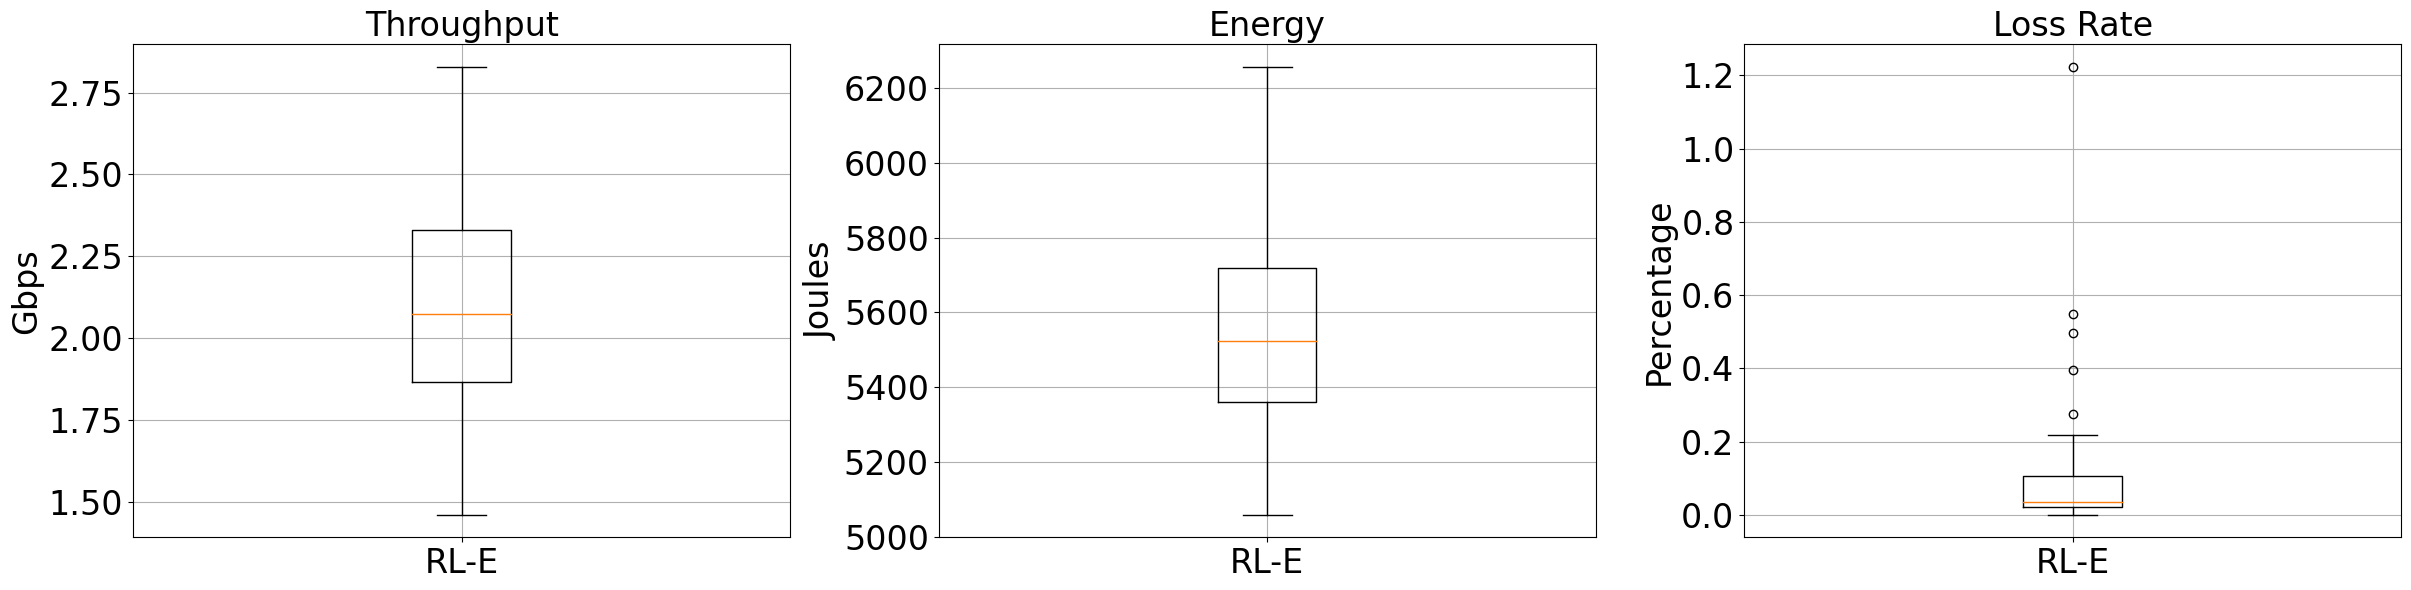

In [36]:
result_dictionary={"Throughput":[rl_throughput_list],"Energy":[rl_energy_list],"lossRate":[rl_plr_list]}
import matplotlib.pyplot as plt

labels = ['RL-E']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()


# Throughput optimized SLA

In [63]:
import gym
from gym import spaces
import numpy as np

class transferClass_throughput_optimized(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 30}
    def __init__(self,transaction_dfs,initial_dfs,optimizer,total_steps=20,min_values=[0.32, 0.0, -75.0, 0.0, 40.0, 0.0, 1, 1],max_values = [20.48, 2.0, 20.0, 89.9, 110.0, 2.0, 8, 8]):
        super().__init__()
        self.action_array= [(1,1),(1,1),(2,2),(3,3),(4,4),(5,5),(6,6),(7,7),(8,8)]
        self.transaction_dfs = transaction_dfs
        self.initial_dfs= initial_dfs
        self.action_space = spaces.Discrete(9) # example action space
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(40,), dtype=np.float32) # example observation space
        self.current_observation = np.zeros(40,) # initialize current observation
        self.optimizer=optimizer
        self.old_action=None
        self.step_number=0
        self.total_steps=total_steps
        self.sampling_metric='Score'
        self.min_values=np.array(min_values)
        self.max_values=np.array(max_values)
        self.previous_reward=0
        self.total_energy=0
        self.erergy_sla=6000
        self.obs_df=[]

    def reset(self):
        self.current_observation = np.zeros(40,) # initialize current observation
        self.old_action=None
        self.step_number=0
        self.previous_reward=0
        self.obs_df=[]
        self.total_energy=0
        return self.current_observation

    def step(self, action):
        if action==0:
            action=1
        
        if self.old_action==None:
            done=False
            key_name=f'concurrency_{action}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array)
            self.old_action=action
        
        elif self.old_action==action:
            done=False
            key_name=f'concurrency_{action}'
            observation_df=sample_row_and_neighbors(self.initial_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array)
            self.old_action=action
        
        else:
            done=False
            key_name=f'concurrency_{self.old_action}_{action}'
            observation_df=sample_row_and_neighbors(self.transaction_dfs[key_name],self.sampling_metric)
            self.obs_df.append(observation_df)
            observation,result_array,e_array,t_array=normalize_and_flatten(observation_df,self.min_values,self.max_values)
            energy_cost=np.sum(e_array)
            self.total_energy+=energy_cost
            if self.total_energy >self.erergy_sla:
                energy_penalty= 100
            else:
                energy_penalty= 0
            reward=np.mean(t_array)
            self.old_action=action
            
        self.step_number+=1
        
        if self.step_number>=self.total_steps:
            done=True
        observation=observation.astype(np.float32)
        self.current_observation=observation
        return self.current_observation, reward, done, {}

    def bayes_step(self,action):
        params = [1 if x<1 else int(np.round(x)) for x in action]
        print("Bayes Step: ",params)
        if params[0] > 8:
            params[0] = 8
        obs,score_b,done_b,__=self.step(params[0])
        print("Bayes Step Score: ", score_b)
        return np.round(score_b * (-1))

    def render(self, mode="human"):
        pass

    def close(self):
        self.reset()


# Test The Environment

In [64]:
env=transferClass_throughput_optimized(loaded_dfs,loaded_initial_dfs,'random')
total_scores=0
s = env.reset()
action_list=[]
reward_list=[]
done = False
while not done:
    a=env.action_space.sample()
    s_next, r, done, info = env.step(a)
    action_list.append(a)
    reward_list.append(r)
    total_scores += r
    s = s_next
# print(f"env.obs_df {env.obs_df}")
accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed

env.close()
print(f"Total Reward: {total_scores}")
print(f"actions {action_list},   {len(action_list)}")
print(f"rewards {reward_list},  {len(reward_list)}")
print(accumulator_df)

Total Reward: 50.368
actions [3, 6, 6, 5, 8, 5, 4, 5, 4, 0, 0, 6, 6, 4, 1, 2, 2, 7, 4, 4],   20
rewards [1.408, 1.1520000000000001, 4.16, 4.5440000000000005, 2.496, 0.32, 2.88, 3.2640000000000002, 5.055999999999999, 0.44800000000000006, 6.784000000000001, 1.408, 1.28, 3.904, 0.576, 0.512, 4.928, 1.0879999999999999, 1.7920000000000003, 2.368],  20
                           Time  Throughput  receiver_lr  CC  Score   RTT  \
2464 2024-01-15 05:09:26.229353        1.92          0.0   9    2.0  34.1   
2465 2024-01-15 05:09:27.229559        0.64          0.0   9    1.0  32.8   
2466 2024-01-15 05:09:28.230276        1.60          0.0   9    2.0  37.1   
2467 2024-01-15 05:09:29.232972        1.60          0.0   9    2.0  37.1   
2468 2024-01-15 05:09:30.232615        1.28          0.0   9    1.0  51.9   
...                         ...         ...          ...  ..    ...   ...   
3287 2024-01-15 01:35:24.558490        4.80          0.0  16    4.0  33.1   
3288 2024-01-15 01:36:05.668370    

In [ ]:
env=transferClass_throughput_optimized(loaded_dfs,loaded_initial_dfs,'random')
evaluation_env=transferClass_throughput_optimized(loaded_dfs,loaded_initial_dfs,'random')

policy_kwargs = dict(activation_fn=th.nn.ReLU,net_arch=[{'pi': [128, 128], 'vf': [128, 128]}])
string_='_throughput_optimized'
model = PPO("MlpPolicy", env=env, policy_kwargs=policy_kwargs, verbose=1,tensorboard_log=f"./ppo_tensorboard_{string_}/",ent_coef=0.01)
eval_callback = EvalCallback(evaluation_env, best_model_save_path=f'./ppo_{string_}/ppo_best_model/',
                               log_path=f'./ppo_{string_}/ppo_logs/', eval_freq=1000,
                               deterministic=True, render=False)
# Callback for saving checkpoints every 1000 timesteps
checkpoint_callback = CheckpointCallback(save_freq=1000, save_path=f'./ppo_{string_}/ppo_checkpoints/',
                                           name_prefix='ppo_model')

# Combine both callbacks
callback = CallbackList([checkpoint_callback, eval_callback])
model.learn(total_timesteps=1000000, callback=callback)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


2024-02-05 18:40:26.620537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-05 18:40:26.689879: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-05 18:40:26.705210: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-05 18:40:27.000394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: li

Logging to ./ppo_tensorboard__throughput_optimized/PPO_1
Eval num_timesteps=1000, episode_reward=30.95 +/- 4.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 31       |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=2000, episode_reward=36.10 +/- 5.34
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 36.1     |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 40.7     |
| time/              |          |
|    fps             | 414      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
Eval num_timesteps=3000, episode_reward=53.81 +/- 7.82
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.8         |
| time/                   |              |
|    total_timesteps      | 3000         |
| train/                  |              |
|    approx_kl            | 0.0145329945 |
|    clip_fraction        | 0.112        |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.19        |
|    explained_variance   | 0.00083      |
|    learning_rate        | 0.0003  

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=4000, episode_reward=51.26 +/- 6.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.3     |
| time/              |          |
|    total_timesteps | 4000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 42.5     |
| time/              |          |
|    fps             | 447      |
|    iterations      | 2        |
|    time_elapsed    | 9        |
|    total_timesteps | 4096     |
---------------------------------
Eval num_timesteps=5000, episode_reward=49.19 +/- 8.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.2        |
| time/                   |             |
|    total_timesteps      | 5000        |
| train/                  |             |
|    approx_kl            | 0.007242742 |
|    clip_fraction        | 0.0316      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.18       |
|    explained_variance   | -0.188      |
|    learning_rate        | 0.0003      |
|    loss                 | 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=6000, episode_reward=47.82 +/- 8.62
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.8     |
| time/              |          |
|    total_timesteps | 6000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 42.9     |
| time/              |          |
|    fps             | 459      |
|    iterations      | 3        |
|    time_elapsed    | 13       |
|    total_timesteps | 6144     |
---------------------------------
Eval num_timesteps=7000, episode_reward=51.99 +/- 5.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 52          |
| time/                   |             |
|    total_timesteps      | 7000        |
| train/                  |             |
|    approx_kl            | 0.008478815 |
|    clip_fraction        | 0.0356      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.17       |
|    explained_variance   | -0.108      |
|    learning_rate        | 0.0003      |
|    loss                 | 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=8000, episode_reward=56.40 +/- 7.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.4     |
| time/              |          |
|    total_timesteps | 8000     |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 41       |
| time/              |          |
|    fps             | 463      |
|    iterations      | 4        |
|    time_elapsed    | 17       |
|    total_timesteps | 8192     |
---------------------------------
Eval num_timesteps=9000, episode_reward=46.82 +/- 7.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.8        |
| time/                   |             |
|    total_timesteps      | 9000        |
| train/                  |             |
|    approx_kl            | 0.012021935 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.14       |
|    explained_variance   | 0.0439      |
|    learning_rate        | 0.0003      |
|    l

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=10000, episode_reward=48.19 +/- 8.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.2     |
| time/              |          |
|    total_timesteps | 10000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 46.3     |
| time/              |          |
|    fps             | 467      |
|    iterations      | 5        |
|    time_elapsed    | 21       |
|    total_timesteps | 10240    |
---------------------------------
Eval num_timesteps=11000, episode_reward=47.87 +/- 3.97
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.9        |
| time/                   |             |
|    total_timesteps      | 11000       |
| train/                  |             |
|    approx_kl            | 0.011365376 |
|    clip_fraction        | 0.0872      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.08       |
|    explained_variance   | 0.0803      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=12000, episode_reward=41.60 +/- 5.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 41.6     |
| time/              |          |
|    total_timesteps | 12000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 46.9     |
| time/              |          |
|    fps             | 469      |
|    iterations      | 6        |
|    time_elapsed    | 26       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=13000, episode_reward=51.32 +/- 9.62
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.3        |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.010834435 |
|    clip_fraction        | 0.117       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.05       |
|    explained_variance   | 0.0769      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=14000, episode_reward=54.69 +/- 6.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.7     |
| time/              |          |
|    total_timesteps | 14000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 46.5     |
| time/              |          |
|    fps             | 471      |
|    iterations      | 7        |
|    time_elapsed    | 30       |
|    total_timesteps | 14336    |
---------------------------------
Eval num_timesteps=15000, episode_reward=53.02 +/- 8.08
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53           |
| time/                   |              |
|    total_timesteps      | 15000        |
| train/                  |              |
|    approx_kl            | 0.0074100997 |
|    clip_fraction        | 0.0529       |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.04        |
|    explained_variance   | 0.0752       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=16000, episode_reward=44.97 +/- 6.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45       |
| time/              |          |
|    total_timesteps | 16000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 46.5     |
| time/              |          |
|    fps             | 472      |
|    iterations      | 8        |
|    time_elapsed    | 34       |
|    total_timesteps | 16384    |
---------------------------------
Eval num_timesteps=17000, episode_reward=49.93 +/- 5.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.9        |
| time/                   |             |
|    total_timesteps      | 17000       |
| train/                  |             |
|    approx_kl            | 0.009806554 |
|    clip_fraction        | 0.0828      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2          |
|    explained_variance   | 0.0669      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=18000, episode_reward=55.77 +/- 9.68
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.8     |
| time/              |          |
|    total_timesteps | 18000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 46.8     |
| time/              |          |
|    fps             | 473      |
|    iterations      | 9        |
|    time_elapsed    | 38       |
|    total_timesteps | 18432    |
---------------------------------
Eval num_timesteps=19000, episode_reward=53.54 +/- 4.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.5        |
| time/                   |             |
|    total_timesteps      | 19000       |
| train/                  |             |
|    approx_kl            | 0.010653246 |
|    clip_fraction        | 0.107       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.95       |
|    explained_variance   | 0.0824      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=20000, episode_reward=47.99 +/- 7.42
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48       |
| time/              |          |
|    total_timesteps | 20000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 47.7     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 10       |
|    time_elapsed    | 43       |
|    total_timesteps | 20480    |
---------------------------------
Eval num_timesteps=21000, episode_reward=45.81 +/- 7.94
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.8        |
| time/                   |             |
|    total_timesteps      | 21000       |
| train/                  |             |
|    approx_kl            | 0.010429118 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.94       |
|    explained_variance   | 0.079       |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=22000, episode_reward=50.44 +/- 6.81
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.4     |
| time/              |          |
|    total_timesteps | 22000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 50.7     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 11       |
|    time_elapsed    | 47       |
|    total_timesteps | 22528    |
---------------------------------
Eval num_timesteps=23000, episode_reward=57.86 +/- 4.07
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.9        |
| time/                   |             |
|    total_timesteps      | 23000       |
| train/                  |             |
|    approx_kl            | 0.009623406 |
|    clip_fraction        | 0.108       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.92       |
|    explained_variance   | 0.087       |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=24000, episode_reward=48.73 +/- 9.52
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.7     |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 50.2     |
| time/              |          |
|    fps             | 474      |
|    iterations      | 12       |
|    time_elapsed    | 51       |
|    total_timesteps | 24576    |
---------------------------------
Eval num_timesteps=25000, episode_reward=58.83 +/- 14.00
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 58.8        |
| time/                   |             |
|    total_timesteps      | 25000       |
| train/                  |             |
|    approx_kl            | 0.012017619 |
|    clip_fraction        | 0.0622      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.88       |
|    explained_variance   | 0.0749      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=26000, episode_reward=60.43 +/- 9.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60.4     |
| time/              |          |
|    total_timesteps | 26000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 50.6     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 13       |
|    time_elapsed    | 56       |
|    total_timesteps | 26624    |
---------------------------------
Eval num_timesteps=27000, episode_reward=51.84 +/- 12.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.8        |
| time/                   |             |
|    total_timesteps      | 27000       |
| train/                  |             |
|    approx_kl            | 0.011413042 |
|    clip_fraction        | 0.0926      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.82       |
|    explained_variance   | 0.0805      |
|    learning_rate        | 0.0003      |
|   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=28000, episode_reward=47.42 +/- 9.27
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.4     |
| time/              |          |
|    total_timesteps | 28000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 14       |
|    time_elapsed    | 60       |
|    total_timesteps | 28672    |
---------------------------------
Eval num_timesteps=29000, episode_reward=52.71 +/- 8.56
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 52.7       |
| time/                   |            |
|    total_timesteps      | 29000      |
| train/                  |            |
|    approx_kl            | 0.00859103 |
|    clip_fraction        | 0.0464     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.8       |
|    explained_variance   | 0.0773     |
|    learning_rate        | 0.0003     |
|    loss                 | 65         |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=30000, episode_reward=56.04 +/- 5.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56       |
| time/              |          |
|    total_timesteps | 30000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.4     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 15       |
|    time_elapsed    | 64       |
|    total_timesteps | 30720    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=31000, episode_reward=49.46 +/- 8.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.5        |
| time/                   |             |
|    total_timesteps      | 31000       |
| train/                  |             |
|    approx_kl            | 0.011517964 |
|    clip_fraction        | 0.0827      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.83       |
|    explained_variance   | 0.0844      |
|    learning_rate        | 0.0003      |
|    loss                 | 101         |
|    n_updates            | 150         |
|    policy_gradient_loss | -0.00726    |
|    value_loss           | 186         |
-----------------------------------------
Eval num_timesteps=32000, episode_reward=51.58 +/- 5.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
| 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 51.6     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 16       |
|    time_elapsed    | 68       |
|    total_timesteps | 32768    |
---------------------------------
Eval num_timesteps=33000, episode_reward=38.48 +/- 3.24
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 38.5        |
| time/                   |             |
|    total_timesteps      | 33000       |
| train/                  |             |
|    approx_kl            | 0.006377748 |
|    clip_fraction        | 0.0805      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.78       |
|    explained_variance   | 0.0778      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=34000, episode_reward=42.85 +/- 7.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 42.9     |
| time/              |          |
|    total_timesteps | 34000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 17       |
|    time_elapsed    | 73       |
|    total_timesteps | 34816    |
---------------------------------
Eval num_timesteps=35000, episode_reward=45.03 +/- 5.29
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 45           |
| time/                   |              |
|    total_timesteps      | 35000        |
| train/                  |              |
|    approx_kl            | 0.0052548526 |
|    clip_fraction        | 0.0276       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.76        |
|    explained_variance   | 0.082        |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=36000, episode_reward=53.16 +/- 3.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.2     |
| time/              |          |
|    total_timesteps | 36000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 51.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 18       |
|    time_elapsed    | 77       |
|    total_timesteps | 36864    |
---------------------------------
Eval num_timesteps=37000, episode_reward=47.69 +/- 6.17
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.7        |
| time/                   |             |
|    total_timesteps      | 37000       |
| train/                  |             |
|    approx_kl            | 0.008602111 |
|    clip_fraction        | 0.0777      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.74       |
|    explained_variance   | 0.0779      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=38000, episode_reward=54.26 +/- 5.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.3     |
| time/              |          |
|    total_timesteps | 38000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 19       |
|    time_elapsed    | 81       |
|    total_timesteps | 38912    |
---------------------------------
Eval num_timesteps=39000, episode_reward=51.32 +/- 5.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.3        |
| time/                   |             |
|    total_timesteps      | 39000       |
| train/                  |             |
|    approx_kl            | 0.010372302 |
|    clip_fraction        | 0.087       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.7        |
|    explained_variance   | 0.0887      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=40000, episode_reward=59.26 +/- 6.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.3     |
| time/              |          |
|    total_timesteps | 40000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 20       |
|    time_elapsed    | 86       |
|    total_timesteps | 40960    |
---------------------------------
Eval num_timesteps=41000, episode_reward=53.30 +/- 14.58
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 53.3       |
| time/                   |            |
|    total_timesteps      | 41000      |
| train/                  |            |
|    approx_kl            | 0.01019245 |
|    clip_fraction        | 0.0933     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.59      |
|    explained_variance   | 0.0684     |
|    learning_rate        | 0.0003     |
|    loss                 | 81.3       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=42000, episode_reward=47.50 +/- 7.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.5     |
| time/              |          |
|    total_timesteps | 42000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=43000, episode_reward=47.18 +/- 3.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.2     |
| time/              |          |
|    total_timesteps | 43000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 21       |
|    time_elapsed    | 90       |
|    total_timesteps | 43008    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=44000, episode_reward=49.37 +/- 7.97
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.4        |
| time/                   |             |
|    total_timesteps      | 44000       |
| train/                  |             |
|    approx_kl            | 0.007115296 |
|    clip_fraction        | 0.0305      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.69       |
|    explained_variance   | 0.0868      |
|    learning_rate        | 0.0003      |
|    loss                 | 85.4        |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00411    |
|    value_loss           | 200         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=45000, episode_reward=51.93 +/- 11.19
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.9     |
| time/              |          |
|    total_timesteps | 45000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 22       |
|    time_elapsed    | 94       |
|    total_timesteps | 45056    |
---------------------------------
Eval num_timesteps=46000, episode_reward=54.27 +/- 7.45
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 54.3         |
| time/                   |              |
|    total_timesteps      | 46000        |
| train/                  |              |
|    approx_kl            | 0.0070693344 |
|    clip_fraction        | 0.0371       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.71        |
|    explained_variance   | 0.0846       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=47000, episode_reward=50.04 +/- 6.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50       |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 23       |
|    time_elapsed    | 99       |
|    total_timesteps | 47104    |
---------------------------------
Eval num_timesteps=48000, episode_reward=57.47 +/- 5.59
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.5        |
| time/                   |             |
|    total_timesteps      | 48000       |
| train/                  |             |
|    approx_kl            | 0.006338943 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.077       |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=49000, episode_reward=46.04 +/- 6.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46       |
| time/              |          |
|    total_timesteps | 49000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 24       |
|    time_elapsed    | 103      |
|    total_timesteps | 49152    |
---------------------------------
Eval num_timesteps=50000, episode_reward=55.13 +/- 6.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.1        |
| time/                   |             |
|    total_timesteps      | 50000       |
| train/                  |             |
|    approx_kl            | 0.012569993 |
|    clip_fraction        | 0.0813      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0844      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=51000, episode_reward=52.76 +/- 1.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.8     |
| time/              |          |
|    total_timesteps | 51000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 25       |
|    time_elapsed    | 107      |
|    total_timesteps | 51200    |
---------------------------------
Eval num_timesteps=52000, episode_reward=48.90 +/- 6.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.9        |
| time/                   |             |
|    total_timesteps      | 52000       |
| train/                  |             |
|    approx_kl            | 0.008994039 |
|    clip_fraction        | 0.0814      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0803      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=53000, episode_reward=50.59 +/- 6.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.6     |
| time/              |          |
|    total_timesteps | 53000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 26       |
|    time_elapsed    | 111      |
|    total_timesteps | 53248    |
---------------------------------
Eval num_timesteps=54000, episode_reward=45.96 +/- 3.32
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46          |
| time/                   |             |
|    total_timesteps      | 54000       |
| train/                  |             |
|    approx_kl            | 0.008288453 |
|    clip_fraction        | 0.0594      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0879      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=55000, episode_reward=50.62 +/- 9.10
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.6     |
| time/              |          |
|    total_timesteps | 55000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 27       |
|    time_elapsed    | 116      |
|    total_timesteps | 55296    |
---------------------------------
Eval num_timesteps=56000, episode_reward=51.11 +/- 13.40
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.1        |
| time/                   |             |
|    total_timesteps      | 56000       |
| train/                  |             |
|    approx_kl            | 0.011733641 |
|    clip_fraction        | 0.0845      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=57000, episode_reward=51.97 +/- 8.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52       |
| time/              |          |
|    total_timesteps | 57000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 28       |
|    time_elapsed    | 120      |
|    total_timesteps | 57344    |
---------------------------------
Eval num_timesteps=58000, episode_reward=58.33 +/- 13.78
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 58.3         |
| time/                   |              |
|    total_timesteps      | 58000        |
| train/                  |              |
|    approx_kl            | 0.0053492263 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.66        |
|    explained_variance   | 0.0813       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=59000, episode_reward=53.63 +/- 4.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.6     |
| time/              |          |
|    total_timesteps | 59000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 29       |
|    time_elapsed    | 124      |
|    total_timesteps | 59392    |
---------------------------------
Eval num_timesteps=60000, episode_reward=51.10 +/- 16.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.1        |
| time/                   |             |
|    total_timesteps      | 60000       |
| train/                  |             |
|    approx_kl            | 0.011453861 |
|    clip_fraction        | 0.0477      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.65       |
|    explained_variance   | 0.0783      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=61000, episode_reward=52.04 +/- 19.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52       |
| time/              |          |
|    total_timesteps | 61000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 30       |
|    time_elapsed    | 128      |
|    total_timesteps | 61440    |
---------------------------------
Eval num_timesteps=62000, episode_reward=40.28 +/- 8.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 40.3        |
| time/                   |             |
|    total_timesteps      | 62000       |
| train/                  |             |
|    approx_kl            | 0.008525057 |
|    clip_fraction        | 0.0329      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.64       |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=63000, episode_reward=49.77 +/- 4.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.8     |
| time/              |          |
|    total_timesteps | 63000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.9     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 31       |
|    time_elapsed    | 133      |
|    total_timesteps | 63488    |
---------------------------------
Eval num_timesteps=64000, episode_reward=48.20 +/- 6.60
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.2         |
| time/                   |              |
|    total_timesteps      | 64000        |
| train/                  |              |
|    approx_kl            | 0.0057028774 |
|    clip_fraction        | 0.0175       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.62        |
|    explained_variance   | 0.084        |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=65000, episode_reward=54.14 +/- 5.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.1     |
| time/              |          |
|    total_timesteps | 65000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 32       |
|    time_elapsed    | 137      |
|    total_timesteps | 65536    |
---------------------------------
Eval num_timesteps=66000, episode_reward=49.34 +/- 5.78
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.3        |
| time/                   |             |
|    total_timesteps      | 66000       |
| train/                  |             |
|    approx_kl            | 0.005964472 |
|    clip_fraction        | 0.0377      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0833      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=67000, episode_reward=50.19 +/- 2.81
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.2     |
| time/              |          |
|    total_timesteps | 67000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 33       |
|    time_elapsed    | 141      |
|    total_timesteps | 67584    |
---------------------------------
Eval num_timesteps=68000, episode_reward=47.92 +/- 4.50
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 47.9         |
| time/                   |              |
|    total_timesteps      | 68000        |
| train/                  |              |
|    approx_kl            | 0.0072039464 |
|    clip_fraction        | 0.054        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.6         |
|    explained_variance   | 0.0879       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=69000, episode_reward=50.82 +/- 3.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.8     |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 34       |
|    time_elapsed    | 145      |
|    total_timesteps | 69632    |
---------------------------------
Eval num_timesteps=70000, episode_reward=47.05 +/- 8.41
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.1        |
| time/                   |             |
|    total_timesteps      | 70000       |
| train/                  |             |
|    approx_kl            | 0.005064524 |
|    clip_fraction        | 0.0541      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.62       |
|    explained_variance   | 0.0872      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=71000, episode_reward=51.15 +/- 6.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 71000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 35       |
|    time_elapsed    | 150      |
|    total_timesteps | 71680    |
---------------------------------
Eval num_timesteps=72000, episode_reward=47.05 +/- 12.19
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.1        |
| time/                   |             |
|    total_timesteps      | 72000       |
| train/                  |             |
|    approx_kl            | 0.006719034 |
|    clip_fraction        | 0.0615      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.63       |
|    explained_variance   | 0.0874      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=73000, episode_reward=48.44 +/- 5.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.4     |
| time/              |          |
|    total_timesteps | 73000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 36       |
|    time_elapsed    | 154      |
|    total_timesteps | 73728    |
---------------------------------
Eval num_timesteps=74000, episode_reward=61.41 +/- 11.15
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 61.4        |
| time/                   |             |
|    total_timesteps      | 74000       |
| train/                  |             |
|    approx_kl            | 0.005800917 |
|    clip_fraction        | 0.0478      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0893      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=75000, episode_reward=49.91 +/- 6.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.9     |
| time/              |          |
|    total_timesteps | 75000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 37       |
|    time_elapsed    | 158      |
|    total_timesteps | 75776    |
---------------------------------
Eval num_timesteps=76000, episode_reward=49.14 +/- 5.26
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 49.1         |
| time/                   |              |
|    total_timesteps      | 76000        |
| train/                  |              |
|    approx_kl            | 0.0041899653 |
|    clip_fraction        | 0.0303       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.61        |
|    explained_variance   | 0.0897       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=77000, episode_reward=46.04 +/- 6.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46       |
| time/              |          |
|    total_timesteps | 77000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 38       |
|    time_elapsed    | 163      |
|    total_timesteps | 77824    |
---------------------------------
Eval num_timesteps=78000, episode_reward=48.05 +/- 6.31
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.1        |
| time/                   |             |
|    total_timesteps      | 78000       |
| train/                  |             |
|    approx_kl            | 0.004184179 |
|    clip_fraction        | 0.0393      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=79000, episode_reward=50.79 +/- 6.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.8     |
| time/              |          |
|    total_timesteps | 79000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 39       |
|    time_elapsed    | 167      |
|    total_timesteps | 79872    |
---------------------------------
Eval num_timesteps=80000, episode_reward=52.95 +/- 11.61
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53          |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.012107531 |
|    clip_fraction        | 0.102       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0719      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=81000, episode_reward=50.34 +/- 8.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.3     |
| time/              |          |
|    total_timesteps | 81000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 40       |
|    time_elapsed    | 171      |
|    total_timesteps | 81920    |
---------------------------------
Eval num_timesteps=82000, episode_reward=52.62 +/- 10.41
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.6         |
| time/                   |              |
|    total_timesteps      | 82000        |
| train/                  |              |
|    approx_kl            | 0.0064500845 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | 0.0861       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=83000, episode_reward=55.88 +/- 6.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.9     |
| time/              |          |
|    total_timesteps | 83000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 41       |
|    time_elapsed    | 176      |
|    total_timesteps | 83968    |
---------------------------------
Eval num_timesteps=84000, episode_reward=49.50 +/- 7.92
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 49.5         |
| time/                   |              |
|    total_timesteps      | 84000        |
| train/                  |              |
|    approx_kl            | 0.0038785187 |
|    clip_fraction        | 0.0293       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.47        |
|    explained_variance   | 0.0799       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=85000, episode_reward=54.14 +/- 9.95
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.1     |
| time/              |          |
|    total_timesteps | 85000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=86000, episode_reward=44.42 +/- 6.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.4     |
| time/              |          |
|    total_timesteps | 86000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 42       |
|    time_elapsed    | 180      |
|    total_timesteps | 86016    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=87000, episode_reward=53.39 +/- 6.74
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 53.4       |
| time/                   |            |
|    total_timesteps      | 87000      |
| train/                  |            |
|    approx_kl            | 0.00595322 |
|    clip_fraction        | 0.0515     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.45      |
|    explained_variance   | 0.0843     |
|    learning_rate        | 0.0003     |
|    loss                 | 107        |
|    n_updates            | 420        |
|    policy_gradient_loss | -0.00369   |
|    value_loss           | 196        |
----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=88000, episode_reward=51.06 +/- 4.67
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 88000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 43       |
|    time_elapsed    | 184      |
|    total_timesteps | 88064    |
---------------------------------
Eval num_timesteps=89000, episode_reward=51.70 +/- 7.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.7        |
| time/                   |             |
|    total_timesteps      | 89000       |
| train/                  |             |
|    approx_kl            | 0.005582753 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0914      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=90000, episode_reward=59.57 +/- 9.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.6     |
| time/              |          |
|    total_timesteps | 90000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 44       |
|    time_elapsed    | 189      |
|    total_timesteps | 90112    |
---------------------------------
Eval num_timesteps=91000, episode_reward=48.42 +/- 12.53
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.4         |
| time/                   |              |
|    total_timesteps      | 91000        |
| train/                  |              |
|    approx_kl            | 0.0075455187 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0828       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=92000, episode_reward=55.67 +/- 4.42
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.7     |
| time/              |          |
|    total_timesteps | 92000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 45       |
|    time_elapsed    | 193      |
|    total_timesteps | 92160    |
---------------------------------
Eval num_timesteps=93000, episode_reward=51.02 +/- 5.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51          |
| time/                   |             |
|    total_timesteps      | 93000       |
| train/                  |             |
|    approx_kl            | 0.012570664 |
|    clip_fraction        | 0.0894      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0845      |
|    learning_rate        | 0.0003      |
|    loss                 |

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=94000, episode_reward=54.34 +/- 3.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.3     |
| time/              |          |
|    total_timesteps | 94000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 46       |
|    time_elapsed    | 197      |
|    total_timesteps | 94208    |
---------------------------------
Eval num_timesteps=95000, episode_reward=53.04 +/- 8.36
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53           |
| time/                   |              |
|    total_timesteps      | 95000        |
| train/                  |              |
|    approx_kl            | 0.0053577307 |
|    clip_fraction        | 0.0458       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.48        |
|    explained_variance   | 0.0822       |
|    learning_rate        | 0.0003       |
|    loss     

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=96000, episode_reward=51.30 +/- 7.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.3     |
| time/              |          |
|    total_timesteps | 96000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 47       |
|    time_elapsed    | 201      |
|    total_timesteps | 96256    |
---------------------------------
Eval num_timesteps=97000, episode_reward=57.89 +/- 10.69
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.9        |
| time/                   |             |
|    total_timesteps      | 97000       |
| train/                  |             |
|    approx_kl            | 0.012921669 |
|    clip_fraction        | 0.0645      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.0765      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=98000, episode_reward=53.84 +/- 9.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.8     |
| time/              |          |
|    total_timesteps | 98000    |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 48       |
|    time_elapsed    | 206      |
|    total_timesteps | 98304    |
---------------------------------
Eval num_timesteps=99000, episode_reward=57.57 +/- 15.18
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.6        |
| time/                   |             |
|    total_timesteps      | 99000       |
| train/                  |             |
|    approx_kl            | 0.007967293 |
|    clip_fraction        | 0.0908      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0903      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=100000, episode_reward=53.81 +/- 11.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.8     |
| time/              |          |
|    total_timesteps | 100000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 49       |
|    time_elapsed    | 210      |
|    total_timesteps | 100352   |
---------------------------------
Eval num_timesteps=101000, episode_reward=55.67 +/- 7.69
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.7        |
| time/                   |             |
|    total_timesteps      | 101000      |
| train/                  |             |
|    approx_kl            | 0.010473606 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.083       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=102000, episode_reward=40.37 +/- 5.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.4     |
| time/              |          |
|    total_timesteps | 102000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 50       |
|    time_elapsed    | 214      |
|    total_timesteps | 102400   |
---------------------------------
Eval num_timesteps=103000, episode_reward=53.02 +/- 7.11
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53          |
| time/                   |             |
|    total_timesteps      | 103000      |
| train/                  |             |
|    approx_kl            | 0.009625819 |
|    clip_fraction        | 0.0479      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.0844      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=104000, episode_reward=55.62 +/- 10.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.6     |
| time/              |          |
|    total_timesteps | 104000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 51       |
|    time_elapsed    | 219      |
|    total_timesteps | 104448   |
---------------------------------
Eval num_timesteps=105000, episode_reward=48.51 +/- 3.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.5        |
| time/                   |             |
|    total_timesteps      | 105000      |
| train/                  |             |
|    approx_kl            | 0.009254181 |
|    clip_fraction        | 0.0593      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.0876      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=106000, episode_reward=56.44 +/- 6.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.4     |
| time/              |          |
|    total_timesteps | 106000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 52       |
|    time_elapsed    | 223      |
|    total_timesteps | 106496   |
---------------------------------
Eval num_timesteps=107000, episode_reward=45.52 +/- 4.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.5        |
| time/                   |             |
|    total_timesteps      | 107000      |
| train/                  |             |
|    approx_kl            | 0.011533585 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0915      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=108000, episode_reward=45.67 +/- 8.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.7     |
| time/              |          |
|    total_timesteps | 108000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 53       |
|    time_elapsed    | 227      |
|    total_timesteps | 108544   |
---------------------------------
Eval num_timesteps=109000, episode_reward=46.04 +/- 4.55
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 46           |
| time/                   |              |
|    total_timesteps      | 109000       |
| train/                  |              |
|    approx_kl            | 0.0074072424 |
|    clip_fraction        | 0.0605       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0815       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=110000, episode_reward=46.54 +/- 5.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.5     |
| time/              |          |
|    total_timesteps | 110000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 54       |
|    time_elapsed    | 231      |
|    total_timesteps | 110592   |
---------------------------------
Eval num_timesteps=111000, episode_reward=46.31 +/- 3.97
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.3        |
| time/                   |             |
|    total_timesteps      | 111000      |
| train/                  |             |
|    approx_kl            | 0.009757336 |
|    clip_fraction        | 0.0525      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.37       |
|    explained_variance   | 0.0793      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=112000, episode_reward=58.33 +/- 5.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.3     |
| time/              |          |
|    total_timesteps | 112000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 55       |
|    time_elapsed    | 236      |
|    total_timesteps | 112640   |
---------------------------------
Eval num_timesteps=113000, episode_reward=43.75 +/- 8.92
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43.8         |
| time/                   |              |
|    total_timesteps      | 113000       |
| train/                  |              |
|    approx_kl            | 0.0051807286 |
|    clip_fraction        | 0.064        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0826       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=114000, episode_reward=54.94 +/- 13.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.9     |
| time/              |          |
|    total_timesteps | 114000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 56       |
|    time_elapsed    | 240      |
|    total_timesteps | 114688   |
---------------------------------
Eval num_timesteps=115000, episode_reward=53.25 +/- 7.41
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 53.2       |
| time/                   |            |
|    total_timesteps      | 115000     |
| train/                  |            |
|    approx_kl            | 0.00748537 |
|    clip_fraction        | 0.0783     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.0798     |
|    learning_rate        | 0.0003     |
|    loss                 | 105        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=116000, episode_reward=51.78 +/- 11.30
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.8     |
| time/              |          |
|    total_timesteps | 116000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 57       |
|    time_elapsed    | 244      |
|    total_timesteps | 116736   |
---------------------------------
Eval num_timesteps=117000, episode_reward=53.06 +/- 7.12
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 53.1       |
| time/                   |            |
|    total_timesteps      | 117000     |
| train/                  |            |
|    approx_kl            | 0.00776581 |
|    clip_fraction        | 0.0653     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.32      |
|    explained_variance   | 0.083      |
|    learning_rate        | 0.0003     |
|    loss                 | 106        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=118000, episode_reward=50.29 +/- 2.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.3     |
| time/              |          |
|    total_timesteps | 118000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 58       |
|    time_elapsed    | 248      |
|    total_timesteps | 118784   |
---------------------------------
Eval num_timesteps=119000, episode_reward=46.90 +/- 4.93
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 46.9         |
| time/                   |              |
|    total_timesteps      | 119000       |
| train/                  |              |
|    approx_kl            | 0.0066221426 |
|    clip_fraction        | 0.0618       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.081        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=120000, episode_reward=40.13 +/- 7.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 40.1     |
| time/              |          |
|    total_timesteps | 120000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 59       |
|    time_elapsed    | 253      |
|    total_timesteps | 120832   |
---------------------------------
Eval num_timesteps=121000, episode_reward=50.76 +/- 5.37
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 50.8         |
| time/                   |              |
|    total_timesteps      | 121000       |
| train/                  |              |
|    approx_kl            | 0.0020341885 |
|    clip_fraction        | 0.0299       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.0851       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=122000, episode_reward=53.34 +/- 9.44
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.3     |
| time/              |          |
|    total_timesteps | 122000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 60       |
|    time_elapsed    | 257      |
|    total_timesteps | 122880   |
---------------------------------
Eval num_timesteps=123000, episode_reward=48.44 +/- 2.64
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.4         |
| time/                   |              |
|    total_timesteps      | 123000       |
| train/                  |              |
|    approx_kl            | 0.0036732499 |
|    clip_fraction        | 0.0409       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.29        |
|    explained_variance   | 0.0833       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=124000, episode_reward=48.59 +/- 6.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.6     |
| time/              |          |
|    total_timesteps | 124000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.5     |
| time/              |          |
|    fps             | 477      |
|    iterations      | 61       |
|    time_elapsed    | 261      |
|    total_timesteps | 124928   |
---------------------------------
Eval num_timesteps=125000, episode_reward=53.77 +/- 6.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.8        |
| time/                   |             |
|    total_timesteps      | 125000      |
| train/                  |             |
|    approx_kl            | 0.006943982 |
|    clip_fraction        | 0.0673      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.0858      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=126000, episode_reward=53.49 +/- 2.02
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.5     |
| time/              |          |
|    total_timesteps | 126000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 477      |
|    iterations      | 62       |
|    time_elapsed    | 266      |
|    total_timesteps | 126976   |
---------------------------------
Eval num_timesteps=127000, episode_reward=53.45 +/- 7.13
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.5        |
| time/                   |             |
|    total_timesteps      | 127000      |
| train/                  |             |
|    approx_kl            | 0.007817911 |
|    clip_fraction        | 0.0768      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0813      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=128000, episode_reward=50.56 +/- 8.95
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.6     |
| time/              |          |
|    total_timesteps | 128000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=129000, episode_reward=59.01 +/- 12.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59       |
| time/              |          |
|    total_timesteps | 129000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 63       |
|    time_elapsed    | 270      |
|    total_timesteps | 129024   |
---------------------------------
Eval num_timesteps=130000, episode_reward=49.69 +/- 6.52
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.7        |
| time/                   |             |
|    total_timesteps      | 130000      |
| train/                  |             |
|    approx_kl            | 0.007343739 |
|    clip_fraction        | 0.081       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.42       |
|    explained_variance   | 0.0854      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=131000, episode_reward=51.14 +/- 8.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 131000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 64       |
|    time_elapsed    | 274      |
|    total_timesteps | 131072   |
---------------------------------
Eval num_timesteps=132000, episode_reward=48.60 +/- 2.32
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.6         |
| time/                   |              |
|    total_timesteps      | 132000       |
| train/                  |              |
|    approx_kl            | 0.0072501577 |
|    clip_fraction        | 0.0633       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.072        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=133000, episode_reward=53.80 +/- 4.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.8     |
| time/              |          |
|    total_timesteps | 133000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 65       |
|    time_elapsed    | 279      |
|    total_timesteps | 133120   |
---------------------------------
Eval num_timesteps=134000, episode_reward=53.27 +/- 5.37
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.3         |
| time/                   |              |
|    total_timesteps      | 134000       |
| train/                  |              |
|    approx_kl            | 0.0061574145 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0848       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=135000, episode_reward=47.21 +/- 5.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.2     |
| time/              |          |
|    total_timesteps | 135000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 66       |
|    time_elapsed    | 283      |
|    total_timesteps | 135168   |
---------------------------------
Eval num_timesteps=136000, episode_reward=44.52 +/- 11.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 44.5        |
| time/                   |             |
|    total_timesteps      | 136000      |
| train/                  |             |
|    approx_kl            | 0.011597849 |
|    clip_fraction        | 0.0526      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0855      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=137000, episode_reward=54.78 +/- 8.18
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.8     |
| time/              |          |
|    total_timesteps | 137000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 67       |
|    time_elapsed    | 287      |
|    total_timesteps | 137216   |
---------------------------------
Eval num_timesteps=138000, episode_reward=49.68 +/- 6.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.7        |
| time/                   |             |
|    total_timesteps      | 138000      |
| train/                  |             |
|    approx_kl            | 0.007285744 |
|    clip_fraction        | 0.0744      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.36       |
|    explained_variance   | 0.0889      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=139000, episode_reward=48.60 +/- 4.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.6     |
| time/              |          |
|    total_timesteps | 139000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 68       |
|    time_elapsed    | 292      |
|    total_timesteps | 139264   |
---------------------------------
Eval num_timesteps=140000, episode_reward=50.51 +/- 8.06
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.5        |
| time/                   |             |
|    total_timesteps      | 140000      |
| train/                  |             |
|    approx_kl            | 0.002524734 |
|    clip_fraction        | 0.0253      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0773      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=141000, episode_reward=59.52 +/- 8.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.5     |
| time/              |          |
|    total_timesteps | 141000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 69       |
|    time_elapsed    | 296      |
|    total_timesteps | 141312   |
---------------------------------
Eval num_timesteps=142000, episode_reward=45.09 +/- 8.38
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.1        |
| time/                   |             |
|    total_timesteps      | 142000      |
| train/                  |             |
|    approx_kl            | 0.007070927 |
|    clip_fraction        | 0.0519      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.0943      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=143000, episode_reward=50.80 +/- 8.96
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.8     |
| time/              |          |
|    total_timesteps | 143000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 70       |
|    time_elapsed    | 300      |
|    total_timesteps | 143360   |
---------------------------------
Eval num_timesteps=144000, episode_reward=56.90 +/- 7.60
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 56.9         |
| time/                   |              |
|    total_timesteps      | 144000       |
| train/                  |              |
|    approx_kl            | 0.0044603217 |
|    clip_fraction        | 0.0489       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0843       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=145000, episode_reward=54.90 +/- 6.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.9     |
| time/              |          |
|    total_timesteps | 145000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 71       |
|    time_elapsed    | 305      |
|    total_timesteps | 145408   |
---------------------------------
Eval num_timesteps=146000, episode_reward=48.28 +/- 9.79
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.3        |
| time/                   |             |
|    total_timesteps      | 146000      |
| train/                  |             |
|    approx_kl            | 0.004777123 |
|    clip_fraction        | 0.0686      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.084       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=147000, episode_reward=50.09 +/- 4.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.1     |
| time/              |          |
|    total_timesteps | 147000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 72       |
|    time_elapsed    | 309      |
|    total_timesteps | 147456   |
---------------------------------
Eval num_timesteps=148000, episode_reward=53.21 +/- 3.31
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.2         |
| time/                   |              |
|    total_timesteps      | 148000       |
| train/                  |              |
|    approx_kl            | 0.0032546814 |
|    clip_fraction        | 0.0252       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.47        |
|    explained_variance   | 0.0723       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=149000, episode_reward=62.48 +/- 12.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 62.5     |
| time/              |          |
|    total_timesteps | 149000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 73       |
|    time_elapsed    | 313      |
|    total_timesteps | 149504   |
---------------------------------
Eval num_timesteps=150000, episode_reward=51.74 +/- 5.81
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 51.7         |
| time/                   |              |
|    total_timesteps      | 150000       |
| train/                  |              |
|    approx_kl            | 0.0045092246 |
|    clip_fraction        | 0.0308       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.47        |
|    explained_variance   | 0.0834       |
|    learning_rate        | 0.0003

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=151000, episode_reward=51.14 +/- 4.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 151000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 74       |
|    time_elapsed    | 318      |
|    total_timesteps | 151552   |
---------------------------------
Eval num_timesteps=152000, episode_reward=51.02 +/- 9.57
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 51           |
| time/                   |              |
|    total_timesteps      | 152000       |
| train/                  |              |
|    approx_kl            | 0.0049191737 |
|    clip_fraction        | 0.0535       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.47        |
|    explained_variance   | 0.084        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=153000, episode_reward=53.13 +/- 5.19
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.1     |
| time/              |          |
|    total_timesteps | 153000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 75       |
|    time_elapsed    | 322      |
|    total_timesteps | 153600   |
---------------------------------
Eval num_timesteps=154000, episode_reward=53.70 +/- 10.32
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.7         |
| time/                   |              |
|    total_timesteps      | 154000       |
| train/                  |              |
|    approx_kl            | 0.0059707207 |
|    clip_fraction        | 0.0766       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | 0.0862       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=155000, episode_reward=57.19 +/- 4.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.2     |
| time/              |          |
|    total_timesteps | 155000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 76       |
|    time_elapsed    | 326      |
|    total_timesteps | 155648   |
---------------------------------
Eval num_timesteps=156000, episode_reward=49.61 +/- 4.29
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.6        |
| time/                   |             |
|    total_timesteps      | 156000      |
| train/                  |             |
|    approx_kl            | 0.009646161 |
|    clip_fraction        | 0.0556      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0924      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=157000, episode_reward=54.57 +/- 3.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.6     |
| time/              |          |
|    total_timesteps | 157000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 77       |
|    time_elapsed    | 331      |
|    total_timesteps | 157696   |
---------------------------------
Eval num_timesteps=158000, episode_reward=58.42 +/- 6.58
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 58.4         |
| time/                   |              |
|    total_timesteps      | 158000       |
| train/                  |              |
|    approx_kl            | 0.0063501582 |
|    clip_fraction        | 0.0519       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.48        |
|    explained_variance   | 0.0765       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=159000, episode_reward=55.77 +/- 10.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.8     |
| time/              |          |
|    total_timesteps | 159000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 78       |
|    time_elapsed    | 335      |
|    total_timesteps | 159744   |
---------------------------------
Eval num_timesteps=160000, episode_reward=60.79 +/- 4.75
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 60.8         |
| time/                   |              |
|    total_timesteps      | 160000       |
| train/                  |              |
|    approx_kl            | 0.0076117706 |
|    clip_fraction        | 0.0748       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | 0.0827       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=161000, episode_reward=53.93 +/- 7.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.9     |
| time/              |          |
|    total_timesteps | 161000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 79       |
|    time_elapsed    | 339      |
|    total_timesteps | 161792   |
---------------------------------
Eval num_timesteps=162000, episode_reward=48.67 +/- 8.22
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.7        |
| time/                   |             |
|    total_timesteps      | 162000      |
| train/                  |             |
|    approx_kl            | 0.008424247 |
|    clip_fraction        | 0.063       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0835      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=163000, episode_reward=54.36 +/- 11.33
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.4     |
| time/              |          |
|    total_timesteps | 163000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 80       |
|    time_elapsed    | 343      |
|    total_timesteps | 163840   |
---------------------------------
Eval num_timesteps=164000, episode_reward=51.48 +/- 6.20
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.5        |
| time/                   |             |
|    total_timesteps      | 164000      |
| train/                  |             |
|    approx_kl            | 0.011194069 |
|    clip_fraction        | 0.0978      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0822      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=165000, episode_reward=58.41 +/- 11.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.4     |
| time/              |          |
|    total_timesteps | 165000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 81       |
|    time_elapsed    | 348      |
|    total_timesteps | 165888   |
---------------------------------
Eval num_timesteps=166000, episode_reward=53.77 +/- 6.40
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.8        |
| time/                   |             |
|    total_timesteps      | 166000      |
| train/                  |             |
|    approx_kl            | 0.011265185 |
|    clip_fraction        | 0.0624      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0927      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=167000, episode_reward=62.76 +/- 10.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 62.8     |
| time/              |          |
|    total_timesteps | 167000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 82       |
|    time_elapsed    | 352      |
|    total_timesteps | 167936   |
---------------------------------
Eval num_timesteps=168000, episode_reward=52.24 +/- 7.56
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 52.2        |
| time/                   |             |
|    total_timesteps      | 168000      |
| train/                  |             |
|    approx_kl            | 0.008175981 |
|    clip_fraction        | 0.0567      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0797      |
|    learning_rate        | 0.0003      |
|   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=169000, episode_reward=58.42 +/- 6.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.4     |
| time/              |          |
|    total_timesteps | 169000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 83       |
|    time_elapsed    | 356      |
|    total_timesteps | 169984   |
---------------------------------
Eval num_timesteps=170000, episode_reward=43.76 +/- 5.58
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43.8         |
| time/                   |              |
|    total_timesteps      | 170000       |
| train/                  |              |
|    approx_kl            | 0.0077396818 |
|    clip_fraction        | 0.0517       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | 0.0857       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=171000, episode_reward=54.66 +/- 4.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.7     |
| time/              |          |
|    total_timesteps | 171000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=172000, episode_reward=53.30 +/- 13.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.3     |
| time/              |          |
|    total_timesteps | 172000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 84       |
|    time_elapsed    | 361      |
|    total_timesteps | 172032   |
---------------------------------
Eval num_timesteps=173000, episode_reward=51.96 +/- 6.77
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 52          |
| time/                   |             |
|    total_timesteps      | 173000      |
| train/                  |             |
|    approx_kl            | 0.008708581 |
|    clip_fraction        | 0.0563      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.0773      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=174000, episode_reward=51.43 +/- 14.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.4     |
| time/              |          |
|    total_timesteps | 174000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 85       |
|    time_elapsed    | 365      |
|    total_timesteps | 174080   |
---------------------------------
Eval num_timesteps=175000, episode_reward=55.96 +/- 9.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56          |
| time/                   |             |
|    total_timesteps      | 175000      |
| train/                  |             |
|    approx_kl            | 0.009627218 |
|    clip_fraction        | 0.0834      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0804      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=176000, episode_reward=58.96 +/- 9.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59       |
| time/              |          |
|    total_timesteps | 176000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 86       |
|    time_elapsed    | 369      |
|    total_timesteps | 176128   |
---------------------------------
Eval num_timesteps=177000, episode_reward=48.78 +/- 7.27
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 48.8        |
| time/                   |             |
|    total_timesteps      | 177000      |
| train/                  |             |
|    approx_kl            | 0.007406924 |
|    clip_fraction        | 0.0741      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.0852      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=178000, episode_reward=52.52 +/- 5.60
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.5     |
| time/              |          |
|    total_timesteps | 178000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 87       |
|    time_elapsed    | 374      |
|    total_timesteps | 178176   |
---------------------------------
Eval num_timesteps=179000, episode_reward=50.59 +/- 16.74
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 50.6       |
| time/                   |            |
|    total_timesteps      | 179000     |
| train/                  |            |
|    approx_kl            | 0.01079149 |
|    clip_fraction        | 0.0571     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.54      |
|    explained_variance   | 0.0862     |
|    learning_rate        | 0.0003     |
|    loss                 | 119       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=180000, episode_reward=50.62 +/- 8.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.6     |
| time/              |          |
|    total_timesteps | 180000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 88       |
|    time_elapsed    | 378      |
|    total_timesteps | 180224   |
---------------------------------
Eval num_timesteps=181000, episode_reward=56.19 +/- 10.50
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 56.2         |
| time/                   |              |
|    total_timesteps      | 181000       |
| train/                  |              |
|    approx_kl            | 0.0075176563 |
|    clip_fraction        | 0.0558       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.55        |
|    explained_variance   | 0.0884       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=182000, episode_reward=48.90 +/- 4.50
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.9     |
| time/              |          |
|    total_timesteps | 182000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 89       |
|    time_elapsed    | 382      |
|    total_timesteps | 182272   |
---------------------------------
Eval num_timesteps=183000, episode_reward=47.56 +/- 7.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.6        |
| time/                   |             |
|    total_timesteps      | 183000      |
| train/                  |             |
|    approx_kl            | 0.007558505 |
|    clip_fraction        | 0.0687      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.084       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=184000, episode_reward=53.43 +/- 7.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.4     |
| time/              |          |
|    total_timesteps | 184000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 90       |
|    time_elapsed    | 387      |
|    total_timesteps | 184320   |
---------------------------------
Eval num_timesteps=185000, episode_reward=53.68 +/- 8.60
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.7        |
| time/                   |             |
|    total_timesteps      | 185000      |
| train/                  |             |
|    approx_kl            | 0.004732628 |
|    clip_fraction        | 0.0428      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0812      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=186000, episode_reward=44.76 +/- 5.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 44.8     |
| time/              |          |
|    total_timesteps | 186000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 91       |
|    time_elapsed    | 391      |
|    total_timesteps | 186368   |
---------------------------------
Eval num_timesteps=187000, episode_reward=53.29 +/- 8.28
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.3        |
| time/                   |             |
|    total_timesteps      | 187000      |
| train/                  |             |
|    approx_kl            | 0.011141013 |
|    clip_fraction        | 0.111       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.086       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=188000, episode_reward=58.11 +/- 4.13
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.1     |
| time/              |          |
|    total_timesteps | 188000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 92       |
|    time_elapsed    | 395      |
|    total_timesteps | 188416   |
---------------------------------
Eval num_timesteps=189000, episode_reward=63.74 +/- 11.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 63.7        |
| time/                   |             |
|    total_timesteps      | 189000      |
| train/                  |             |
|    approx_kl            | 0.008669991 |
|    clip_fraction        | 0.0893      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0854      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=190000, episode_reward=56.10 +/- 16.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.1     |
| time/              |          |
|    total_timesteps | 190000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 93       |
|    time_elapsed    | 400      |
|    total_timesteps | 190464   |
---------------------------------
Eval num_timesteps=191000, episode_reward=54.13 +/- 12.33
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.1        |
| time/                   |             |
|    total_timesteps      | 191000      |
| train/                  |             |
|    approx_kl            | 0.007806048 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0823      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=192000, episode_reward=50.82 +/- 7.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.8     |
| time/              |          |
|    total_timesteps | 192000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 94       |
|    time_elapsed    | 404      |
|    total_timesteps | 192512   |
---------------------------------
Eval num_timesteps=193000, episode_reward=53.75 +/- 7.24
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.7        |
| time/                   |             |
|    total_timesteps      | 193000      |
| train/                  |             |
|    approx_kl            | 0.008430182 |
|    clip_fraction        | 0.0925      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0757      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=194000, episode_reward=55.35 +/- 6.27
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.3     |
| time/              |          |
|    total_timesteps | 194000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 95       |
|    time_elapsed    | 408      |
|    total_timesteps | 194560   |
---------------------------------
Eval num_timesteps=195000, episode_reward=51.38 +/- 5.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.4        |
| time/                   |             |
|    total_timesteps      | 195000      |
| train/                  |             |
|    approx_kl            | 0.008743365 |
|    clip_fraction        | 0.0634      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.083       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=196000, episode_reward=50.64 +/- 6.43
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.6     |
| time/              |          |
|    total_timesteps | 196000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 96       |
|    time_elapsed    | 413      |
|    total_timesteps | 196608   |
---------------------------------
Eval num_timesteps=197000, episode_reward=56.69 +/- 3.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.7        |
| time/                   |             |
|    total_timesteps      | 197000      |
| train/                  |             |
|    approx_kl            | 0.005649509 |
|    clip_fraction        | 0.0357      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.59       |
|    explained_variance   | 0.0807      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=198000, episode_reward=57.54 +/- 3.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.5     |
| time/              |          |
|    total_timesteps | 198000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 52.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 97       |
|    time_elapsed    | 417      |
|    total_timesteps | 198656   |
---------------------------------
Eval num_timesteps=199000, episode_reward=54.16 +/- 10.87
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.2        |
| time/                   |             |
|    total_timesteps      | 199000      |
| train/                  |             |
|    approx_kl            | 0.007861808 |
|    clip_fraction        | 0.0759      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0863      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=200000, episode_reward=57.32 +/- 9.07
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.3     |
| time/              |          |
|    total_timesteps | 200000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 98       |
|    time_elapsed    | 421      |
|    total_timesteps | 200704   |
---------------------------------
Eval num_timesteps=201000, episode_reward=53.38 +/- 3.64
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.4         |
| time/                   |              |
|    total_timesteps      | 201000       |
| train/                  |              |
|    approx_kl            | 0.0096699605 |
|    clip_fraction        | 0.0848       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.55        |
|    explained_variance   | 0.0845       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=202000, episode_reward=54.36 +/- 5.61
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.4     |
| time/              |          |
|    total_timesteps | 202000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 99       |
|    time_elapsed    | 425      |
|    total_timesteps | 202752   |
---------------------------------
Eval num_timesteps=203000, episode_reward=54.77 +/- 6.80
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 54.8         |
| time/                   |              |
|    total_timesteps      | 203000       |
| train/                  |              |
|    approx_kl            | 0.0060876077 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.57        |
|    explained_variance   | 0.0822       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=204000, episode_reward=54.32 +/- 5.48
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.3     |
| time/              |          |
|    total_timesteps | 204000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 100      |
|    time_elapsed    | 430      |
|    total_timesteps | 204800   |
---------------------------------
Eval num_timesteps=205000, episode_reward=53.88 +/- 4.19
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.9        |
| time/                   |             |
|    total_timesteps      | 205000      |
| train/                  |             |
|    approx_kl            | 0.011634016 |
|    clip_fraction        | 0.0824      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0897      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=206000, episode_reward=53.67 +/- 9.93
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.7     |
| time/              |          |
|    total_timesteps | 206000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 101      |
|    time_elapsed    | 434      |
|    total_timesteps | 206848   |
---------------------------------
Eval num_timesteps=207000, episode_reward=52.75 +/- 10.25
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.7         |
| time/                   |              |
|    total_timesteps      | 207000       |
| train/                  |              |
|    approx_kl            | 0.0042351065 |
|    clip_fraction        | 0.0319       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.56        |
|    explained_variance   | 0.0773       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=208000, episode_reward=49.52 +/- 5.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.5     |
| time/              |          |
|    total_timesteps | 208000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 102      |
|    time_elapsed    | 438      |
|    total_timesteps | 208896   |
---------------------------------
Eval num_timesteps=209000, episode_reward=55.08 +/- 7.08
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.1        |
| time/                   |             |
|    total_timesteps      | 209000      |
| train/                  |             |
|    approx_kl            | 0.008219223 |
|    clip_fraction        | 0.0692      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0794      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=210000, episode_reward=59.96 +/- 2.45
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60       |
| time/              |          |
|    total_timesteps | 210000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 103      |
|    time_elapsed    | 443      |
|    total_timesteps | 210944   |
---------------------------------
Eval num_timesteps=211000, episode_reward=57.06 +/- 4.29
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.1        |
| time/                   |             |
|    total_timesteps      | 211000      |
| train/                  |             |
|    approx_kl            | 0.011079125 |
|    clip_fraction        | 0.0947      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0689      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=212000, episode_reward=52.08 +/- 10.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.1     |
| time/              |          |
|    total_timesteps | 212000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 104      |
|    time_elapsed    | 447      |
|    total_timesteps | 212992   |
---------------------------------
Eval num_timesteps=213000, episode_reward=54.27 +/- 6.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.3        |
| time/                   |             |
|    total_timesteps      | 213000      |
| train/                  |             |
|    approx_kl            | 0.005661642 |
|    clip_fraction        | 0.0465      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=214000, episode_reward=55.73 +/- 5.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.7     |
| time/              |          |
|    total_timesteps | 214000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=215000, episode_reward=58.10 +/- 10.05
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.1     |
| time/              |          |
|    total_timesteps | 215000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 105      |
|    time_elapsed    | 451      |
|    total_timesteps | 215040   |
---------------------------------
Eval num_timesteps=216000, episode_reward=58.20 +/- 6.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 58.2        |
| time/                   |             |
|    total_timesteps      | 216000      |
| train/                  |             |
|    approx_kl            | 0.010917869 |
|    clip_fraction        | 0.103       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.09        |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=217000, episode_reward=48.13 +/- 8.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.1     |
| time/              |          |
|    total_timesteps | 217000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 106      |
|    time_elapsed    | 456      |
|    total_timesteps | 217088   |
---------------------------------
Eval num_timesteps=218000, episode_reward=44.70 +/- 6.99
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 44.7         |
| time/                   |              |
|    total_timesteps      | 218000       |
| train/                  |              |
|    approx_kl            | 0.0064170775 |
|    clip_fraction        | 0.0755       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.51        |
|    explained_variance   | 0.0778       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=219000, episode_reward=53.17 +/- 7.06
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.2     |
| time/              |          |
|    total_timesteps | 219000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 107      |
|    time_elapsed    | 460      |
|    total_timesteps | 219136   |
---------------------------------
Eval num_timesteps=220000, episode_reward=53.26 +/- 10.01
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.3         |
| time/                   |              |
|    total_timesteps      | 220000       |
| train/                  |              |
|    approx_kl            | 0.0059496616 |
|    clip_fraction        | 0.0679       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | 0.0862       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=221000, episode_reward=53.66 +/- 7.83
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.7     |
| time/              |          |
|    total_timesteps | 221000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 108      |
|    time_elapsed    | 464      |
|    total_timesteps | 221184   |
---------------------------------
Eval num_timesteps=222000, episode_reward=53.25 +/- 6.16
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.2        |
| time/                   |             |
|    total_timesteps      | 222000      |
| train/                  |             |
|    approx_kl            | 0.005585882 |
|    clip_fraction        | 0.0554      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0829      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=223000, episode_reward=46.76 +/- 5.96
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.8     |
| time/              |          |
|    total_timesteps | 223000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 109      |
|    time_elapsed    | 469      |
|    total_timesteps | 223232   |
---------------------------------
Eval num_timesteps=224000, episode_reward=53.58 +/- 9.78
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.6         |
| time/                   |              |
|    total_timesteps      | 224000       |
| train/                  |              |
|    approx_kl            | 0.0089990925 |
|    clip_fraction        | 0.0623       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.52        |
|    explained_variance   | 0.0869       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=225000, episode_reward=50.23 +/- 6.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.2     |
| time/              |          |
|    total_timesteps | 225000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 110      |
|    time_elapsed    | 473      |
|    total_timesteps | 225280   |
---------------------------------
Eval num_timesteps=226000, episode_reward=50.10 +/- 5.75
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.1        |
| time/                   |             |
|    total_timesteps      | 226000      |
| train/                  |             |
|    approx_kl            | 0.008019471 |
|    clip_fraction        | 0.0523      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0851      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=227000, episode_reward=45.21 +/- 7.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.2     |
| time/              |          |
|    total_timesteps | 227000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 111      |
|    time_elapsed    | 477      |
|    total_timesteps | 227328   |
---------------------------------
Eval num_timesteps=228000, episode_reward=46.78 +/- 8.31
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.8        |
| time/                   |             |
|    total_timesteps      | 228000      |
| train/                  |             |
|    approx_kl            | 0.009659717 |
|    clip_fraction        | 0.0546      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=229000, episode_reward=50.30 +/- 7.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.3     |
| time/              |          |
|    total_timesteps | 229000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 112      |
|    time_elapsed    | 482      |
|    total_timesteps | 229376   |
---------------------------------
Eval num_timesteps=230000, episode_reward=57.88 +/- 7.14
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.9        |
| time/                   |             |
|    total_timesteps      | 230000      |
| train/                  |             |
|    approx_kl            | 0.009103339 |
|    clip_fraction        | 0.0753      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.54       |
|    explained_variance   | 0.0861      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=231000, episode_reward=46.77 +/- 8.57
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.8     |
| time/              |          |
|    total_timesteps | 231000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 113      |
|    time_elapsed    | 486      |
|    total_timesteps | 231424   |
---------------------------------
Eval num_timesteps=232000, episode_reward=47.53 +/- 8.23
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.5        |
| time/                   |             |
|    total_timesteps      | 232000      |
| train/                  |             |
|    approx_kl            | 0.007840319 |
|    clip_fraction        | 0.0395      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0826      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=233000, episode_reward=47.36 +/- 6.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.4     |
| time/              |          |
|    total_timesteps | 233000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 114      |
|    time_elapsed    | 490      |
|    total_timesteps | 233472   |
---------------------------------
Eval num_timesteps=234000, episode_reward=50.91 +/- 1.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.9        |
| time/                   |             |
|    total_timesteps      | 234000      |
| train/                  |             |
|    approx_kl            | 0.007171277 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0859      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=235000, episode_reward=54.16 +/- 9.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.2     |
| time/              |          |
|    total_timesteps | 235000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 115      |
|    time_elapsed    | 494      |
|    total_timesteps | 235520   |
---------------------------------
Eval num_timesteps=236000, episode_reward=56.23 +/- 6.21
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.2        |
| time/                   |             |
|    total_timesteps      | 236000      |
| train/                  |             |
|    approx_kl            | 0.008766435 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0898      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=237000, episode_reward=54.17 +/- 6.36
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.2     |
| time/              |          |
|    total_timesteps | 237000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 116      |
|    time_elapsed    | 499      |
|    total_timesteps | 237568   |
---------------------------------
Eval num_timesteps=238000, episode_reward=50.64 +/- 9.66
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.6        |
| time/                   |             |
|    total_timesteps      | 238000      |
| train/                  |             |
|    approx_kl            | 0.005400745 |
|    clip_fraction        | 0.036       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0885      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=239000, episode_reward=48.74 +/- 7.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.7     |
| time/              |          |
|    total_timesteps | 239000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 117      |
|    time_elapsed    | 503      |
|    total_timesteps | 239616   |
---------------------------------
Eval num_timesteps=240000, episode_reward=50.82 +/- 5.10
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.8        |
| time/                   |             |
|    total_timesteps      | 240000      |
| train/                  |             |
|    approx_kl            | 0.009516224 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0831      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=241000, episode_reward=51.58 +/- 4.46
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.6     |
| time/              |          |
|    total_timesteps | 241000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 118      |
|    time_elapsed    | 507      |
|    total_timesteps | 241664   |
---------------------------------
Eval num_timesteps=242000, episode_reward=57.40 +/- 5.02
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 57.4       |
| time/                   |            |
|    total_timesteps      | 242000     |
| train/                  |            |
|    approx_kl            | 0.00935549 |
|    clip_fraction        | 0.0586     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.55      |
|    explained_variance   | 0.082      |
|    learning_rate        | 0.0003     |
|    loss                 | 116        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=243000, episode_reward=59.17 +/- 8.34
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.2     |
| time/              |          |
|    total_timesteps | 243000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 119      |
|    time_elapsed    | 511      |
|    total_timesteps | 243712   |
---------------------------------
Eval num_timesteps=244000, episode_reward=49.88 +/- 6.64
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 49.9        |
| time/                   |             |
|    total_timesteps      | 244000      |
| train/                  |             |
|    approx_kl            | 0.009208618 |
|    clip_fraction        | 0.0713      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0853      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=245000, episode_reward=58.98 +/- 12.67
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59       |
| time/              |          |
|    total_timesteps | 245000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 120      |
|    time_elapsed    | 516      |
|    total_timesteps | 245760   |
---------------------------------
Eval num_timesteps=246000, episode_reward=56.79 +/- 6.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.8        |
| time/                   |             |
|    total_timesteps      | 246000      |
| train/                  |             |
|    approx_kl            | 0.007798113 |
|    clip_fraction        | 0.0676      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.0895      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=247000, episode_reward=55.96 +/- 8.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56       |
| time/              |          |
|    total_timesteps | 247000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 121      |
|    time_elapsed    | 520      |
|    total_timesteps | 247808   |
---------------------------------
Eval num_timesteps=248000, episode_reward=45.59 +/- 4.48
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 45.6       |
| time/                   |            |
|    total_timesteps      | 248000     |
| train/                  |            |
|    approx_kl            | 0.00876902 |
|    clip_fraction        | 0.0513     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.52      |
|    explained_variance   | 0.0839     |
|    learning_rate        | 0.0003     |
|    loss                 | 98.4       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=249000, episode_reward=47.39 +/- 7.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.4     |
| time/              |          |
|    total_timesteps | 249000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 122      |
|    time_elapsed    | 524      |
|    total_timesteps | 249856   |
---------------------------------
Eval num_timesteps=250000, episode_reward=45.58 +/- 3.42
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.6        |
| time/                   |             |
|    total_timesteps      | 250000      |
| train/                  |             |
|    approx_kl            | 0.008008768 |
|    clip_fraction        | 0.0632      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.52       |
|    explained_variance   | 0.0868      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=251000, episode_reward=48.97 +/- 5.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49       |
| time/              |          |
|    total_timesteps | 251000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 123      |
|    time_elapsed    | 528      |
|    total_timesteps | 251904   |
---------------------------------
Eval num_timesteps=252000, episode_reward=50.46 +/- 8.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.5        |
| time/                   |             |
|    total_timesteps      | 252000      |
| train/                  |             |
|    approx_kl            | 0.007655552 |
|    clip_fraction        | 0.0535      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0834      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=253000, episode_reward=54.12 +/- 5.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.1     |
| time/              |          |
|    total_timesteps | 253000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 124      |
|    time_elapsed    | 533      |
|    total_timesteps | 253952   |
---------------------------------
Eval num_timesteps=254000, episode_reward=47.92 +/- 8.96
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.9        |
| time/                   |             |
|    total_timesteps      | 254000      |
| train/                  |             |
|    approx_kl            | 0.009371374 |
|    clip_fraction        | 0.0527      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.0779      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=255000, episode_reward=45.31 +/- 5.66
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.3     |
| time/              |          |
|    total_timesteps | 255000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=256000, episode_reward=44.95 +/- 9.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45       |
| time/              |          |
|    total_timesteps | 256000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 125      |
|    time_elapsed    | 537      |
|    total_timesteps | 256000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=257000, episode_reward=53.73 +/- 4.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.7        |
| time/                   |             |
|    total_timesteps      | 257000      |
| train/                  |             |
|    approx_kl            | 0.008913154 |
|    clip_fraction        | 0.0979      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0912      |
|    learning_rate        | 0.0003      |
|    loss                 | 98.2        |
|    n_updates            | 1250        |
|    policy_gradient_loss | -0.00798    |
|    value_loss           | 205         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=258000, episode_reward=50.27 +/- 15.34
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.3     |
| time/              |          |
|    total_timesteps | 258000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 126      |
|    time_elapsed    | 541      |
|    total_timesteps | 258048   |
---------------------------------
Eval num_timesteps=259000, episode_reward=60.51 +/- 9.20
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 60.5        |
| time/                   |             |
|    total_timesteps      | 259000      |
| train/                  |             |
|    approx_kl            | 0.008607831 |
|    clip_fraction        | 0.0487      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.0871      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=260000, episode_reward=53.08 +/- 5.55
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.1     |
| time/              |          |
|    total_timesteps | 260000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 127      |
|    time_elapsed    | 546      |
|    total_timesteps | 260096   |
---------------------------------
Eval num_timesteps=261000, episode_reward=57.56 +/- 8.12
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.6        |
| time/                   |             |
|    total_timesteps      | 261000      |
| train/                  |             |
|    approx_kl            | 0.007446166 |
|    clip_fraction        | 0.0559      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0745      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=262000, episode_reward=48.91 +/- 9.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.9     |
| time/              |          |
|    total_timesteps | 262000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 128      |
|    time_elapsed    | 550      |
|    total_timesteps | 262144   |
---------------------------------
Eval num_timesteps=263000, episode_reward=48.86 +/- 11.82
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.9         |
| time/                   |              |
|    total_timesteps      | 263000       |
| train/                  |              |
|    approx_kl            | 0.0067210803 |
|    clip_fraction        | 0.0573       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.54        |
|    explained_variance   | 0.0902       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=264000, episode_reward=50.46 +/- 5.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.5     |
| time/              |          |
|    total_timesteps | 264000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 129      |
|    time_elapsed    | 554      |
|    total_timesteps | 264192   |
---------------------------------
Eval num_timesteps=265000, episode_reward=47.08 +/- 9.47
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.1        |
| time/                   |             |
|    total_timesteps      | 265000      |
| train/                  |             |
|    approx_kl            | 0.011056099 |
|    clip_fraction        | 0.0972      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.56       |
|    explained_variance   | 0.0868      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=266000, episode_reward=59.96 +/- 8.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60       |
| time/              |          |
|    total_timesteps | 266000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 130      |
|    time_elapsed    | 559      |
|    total_timesteps | 266240   |
---------------------------------
Eval num_timesteps=267000, episode_reward=47.73 +/- 3.94
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 47.7       |
| time/                   |            |
|    total_timesteps      | 267000     |
| train/                  |            |
|    approx_kl            | 0.01038405 |
|    clip_fraction        | 0.0884     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.56      |
|    explained_variance   | 0.0882     |
|    learning_rate        | 0.0003     |
|    loss                 | 76.7       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=268000, episode_reward=59.33 +/- 9.24
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.3     |
| time/              |          |
|    total_timesteps | 268000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 131      |
|    time_elapsed    | 563      |
|    total_timesteps | 268288   |
---------------------------------
Eval num_timesteps=269000, episode_reward=55.50 +/- 9.01
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 55.5       |
| time/                   |            |
|    total_timesteps      | 269000     |
| train/                  |            |
|    approx_kl            | 0.00905355 |
|    clip_fraction        | 0.0878     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.58      |
|    explained_variance   | 0.0904     |
|    learning_rate        | 0.0003     |
|    loss                 | 113        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=270000, episode_reward=46.71 +/- 4.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 46.7     |
| time/              |          |
|    total_timesteps | 270000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 132      |
|    time_elapsed    | 567      |
|    total_timesteps | 270336   |
---------------------------------
Eval num_timesteps=271000, episode_reward=59.84 +/- 6.21
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 59.8         |
| time/                   |              |
|    total_timesteps      | 271000       |
| train/                  |              |
|    approx_kl            | 0.0066290246 |
|    clip_fraction        | 0.0392       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.58        |
|    explained_variance   | 0.0775       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=272000, episode_reward=53.38 +/- 11.03
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.4     |
| time/              |          |
|    total_timesteps | 272000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 133      |
|    time_elapsed    | 571      |
|    total_timesteps | 272384   |
---------------------------------
Eval num_timesteps=273000, episode_reward=57.95 +/- 5.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.9        |
| time/                   |             |
|    total_timesteps      | 273000      |
| train/                  |             |
|    approx_kl            | 0.011806424 |
|    clip_fraction        | 0.118       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 0.0861      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=274000, episode_reward=51.96 +/- 8.11
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52       |
| time/              |          |
|    total_timesteps | 274000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 134      |
|    time_elapsed    | 576      |
|    total_timesteps | 274432   |
---------------------------------
Eval num_timesteps=275000, episode_reward=54.49 +/- 8.39
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.5        |
| time/                   |             |
|    total_timesteps      | 275000      |
| train/                  |             |
|    approx_kl            | 0.009730721 |
|    clip_fraction        | 0.0956      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0885      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=276000, episode_reward=54.78 +/- 5.08
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.8     |
| time/              |          |
|    total_timesteps | 276000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 135      |
|    time_elapsed    | 580      |
|    total_timesteps | 276480   |
---------------------------------
Eval num_timesteps=277000, episode_reward=56.96 +/- 10.71
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57          |
| time/                   |             |
|    total_timesteps      | 277000      |
| train/                  |             |
|    approx_kl            | 0.008659475 |
|    clip_fraction        | 0.0708      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0833      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=278000, episode_reward=59.30 +/- 5.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.3     |
| time/              |          |
|    total_timesteps | 278000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 136      |
|    time_elapsed    | 584      |
|    total_timesteps | 278528   |
---------------------------------
Eval num_timesteps=279000, episode_reward=54.55 +/- 8.49
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.6        |
| time/                   |             |
|    total_timesteps      | 279000      |
| train/                  |             |
|    approx_kl            | 0.007902665 |
|    clip_fraction        | 0.0468      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.58       |
|    explained_variance   | 0.0864      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=280000, episode_reward=47.33 +/- 3.21
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.3     |
| time/              |          |
|    total_timesteps | 280000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 137      |
|    time_elapsed    | 589      |
|    total_timesteps | 280576   |
---------------------------------
Eval num_timesteps=281000, episode_reward=50.80 +/- 12.81
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.8        |
| time/                   |             |
|    total_timesteps      | 281000      |
| train/                  |             |
|    approx_kl            | 0.008041506 |
|    clip_fraction        | 0.0568      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.55       |
|    explained_variance   | 0.0764      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=282000, episode_reward=45.68 +/- 5.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 45.7     |
| time/              |          |
|    total_timesteps | 282000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 138      |
|    time_elapsed    | 593      |
|    total_timesteps | 282624   |
---------------------------------
Eval num_timesteps=283000, episode_reward=51.96 +/- 12.08
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 52          |
| time/                   |             |
|    total_timesteps      | 283000      |
| train/                  |             |
|    approx_kl            | 0.010613676 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.57       |
|    explained_variance   | 0.0823      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=284000, episode_reward=48.79 +/- 12.38
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.8     |
| time/              |          |
|    total_timesteps | 284000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 139      |
|    time_elapsed    | 597      |
|    total_timesteps | 284672   |
---------------------------------
Eval num_timesteps=285000, episode_reward=53.44 +/- 10.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.4        |
| time/                   |             |
|    total_timesteps      | 285000      |
| train/                  |             |
|    approx_kl            | 0.009617384 |
|    clip_fraction        | 0.0817      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.53       |
|    explained_variance   | 0.0899      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=286000, episode_reward=53.32 +/- 9.88
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.3     |
| time/              |          |
|    total_timesteps | 286000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 140      |
|    time_elapsed    | 601      |
|    total_timesteps | 286720   |
---------------------------------
Eval num_timesteps=287000, episode_reward=56.99 +/- 10.30
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 57           |
| time/                   |              |
|    total_timesteps      | 287000       |
| train/                  |              |
|    approx_kl            | 0.0059363237 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.53        |
|    explained_variance   | 0.0788       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=288000, episode_reward=53.09 +/- 7.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.1     |
| time/              |          |
|    total_timesteps | 288000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 141      |
|    time_elapsed    | 606      |
|    total_timesteps | 288768   |
---------------------------------
Eval num_timesteps=289000, episode_reward=50.23 +/- 6.29
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 50.2         |
| time/                   |              |
|    total_timesteps      | 289000       |
| train/                  |              |
|    approx_kl            | 0.0073464788 |
|    clip_fraction        | 0.0673       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.49        |
|    explained_variance   | 0.0892       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=290000, episode_reward=55.07 +/- 9.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.1     |
| time/              |          |
|    total_timesteps | 290000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 142      |
|    time_elapsed    | 610      |
|    total_timesteps | 290816   |
---------------------------------
Eval num_timesteps=291000, episode_reward=47.41 +/- 10.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.4        |
| time/                   |             |
|    total_timesteps      | 291000      |
| train/                  |             |
|    approx_kl            | 0.007905161 |
|    clip_fraction        | 0.0699      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.088       |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=292000, episode_reward=55.16 +/- 6.29
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.2     |
| time/              |          |
|    total_timesteps | 292000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 143      |
|    time_elapsed    | 614      |
|    total_timesteps | 292864   |
---------------------------------
Eval num_timesteps=293000, episode_reward=45.52 +/- 10.48
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 45.5        |
| time/                   |             |
|    total_timesteps      | 293000      |
| train/                  |             |
|    approx_kl            | 0.008077607 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.0867      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=294000, episode_reward=54.37 +/- 7.69
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.4     |
| time/              |          |
|    total_timesteps | 294000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 144      |
|    time_elapsed    | 619      |
|    total_timesteps | 294912   |
---------------------------------
Eval num_timesteps=295000, episode_reward=50.36 +/- 6.79
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 50.4         |
| time/                   |              |
|    total_timesteps      | 295000       |
| train/                  |              |
|    approx_kl            | 0.0064656176 |
|    clip_fraction        | 0.0597       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.5         |
|    explained_variance   | 0.0958       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=296000, episode_reward=51.99 +/- 9.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52       |
| time/              |          |
|    total_timesteps | 296000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 145      |
|    time_elapsed    | 623      |
|    total_timesteps | 296960   |
---------------------------------
Eval num_timesteps=297000, episode_reward=55.18 +/- 12.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.2        |
| time/                   |             |
|    total_timesteps      | 297000      |
| train/                  |             |
|    approx_kl            | 0.008089874 |
|    clip_fraction        | 0.086       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0923      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=298000, episode_reward=53.29 +/- 8.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.3     |
| time/              |          |
|    total_timesteps | 298000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=299000, episode_reward=58.41 +/- 4.15
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.4     |
| time/              |          |
|    total_timesteps | 299000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 146      |
|    time_elapsed    | 627      |
|    total_timesteps | 299008   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=300000, episode_reward=53.79 +/- 8.99
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.8        |
| time/                   |             |
|    total_timesteps      | 300000      |
| train/                  |             |
|    approx_kl            | 0.006540298 |
|    clip_fraction        | 0.0709      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.093       |
|    learning_rate        | 0.0003      |
|    loss                 | 85.7        |
|    n_updates            | 1460        |
|    policy_gradient_loss | -0.00611    |
|    value_loss           | 197         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=301000, episode_reward=51.78 +/- 11.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.8     |
| time/              |          |
|    total_timesteps | 301000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 147      |
|    time_elapsed    | 632      |
|    total_timesteps | 301056   |
---------------------------------
Eval num_timesteps=302000, episode_reward=51.26 +/- 6.98
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.3        |
| time/                   |             |
|    total_timesteps      | 302000      |
| train/                  |             |
|    approx_kl            | 0.008084118 |
|    clip_fraction        | 0.0711      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.43       |
|    explained_variance   | 0.0828      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=303000, episode_reward=51.17 +/- 10.17
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.2     |
| time/              |          |
|    total_timesteps | 303000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 148      |
|    time_elapsed    | 636      |
|    total_timesteps | 303104   |
---------------------------------
Eval num_timesteps=304000, episode_reward=55.92 +/- 4.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.9        |
| time/                   |             |
|    total_timesteps      | 304000      |
| train/                  |             |
|    approx_kl            | 0.008559836 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.0881      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=305000, episode_reward=48.63 +/- 9.78
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.6     |
| time/              |          |
|    total_timesteps | 305000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 149      |
|    time_elapsed    | 640      |
|    total_timesteps | 305152   |
---------------------------------
Eval num_timesteps=306000, episode_reward=56.46 +/- 12.55
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.5        |
| time/                   |             |
|    total_timesteps      | 306000      |
| train/                  |             |
|    approx_kl            | 0.007146323 |
|    clip_fraction        | 0.0858      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.0832      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=307000, episode_reward=60.16 +/- 2.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60.2     |
| time/              |          |
|    total_timesteps | 307000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 150      |
|    time_elapsed    | 645      |
|    total_timesteps | 307200   |
---------------------------------
Eval num_timesteps=308000, episode_reward=53.70 +/- 4.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.7        |
| time/                   |             |
|    total_timesteps      | 308000      |
| train/                  |             |
|    approx_kl            | 0.005578682 |
|    clip_fraction        | 0.0743      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.45       |
|    explained_variance   | 0.0952      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=309000, episode_reward=52.54 +/- 4.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.5     |
| time/              |          |
|    total_timesteps | 309000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 151      |
|    time_elapsed    | 649      |
|    total_timesteps | 309248   |
---------------------------------
Eval num_timesteps=310000, episode_reward=52.81 +/- 10.68
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.8         |
| time/                   |              |
|    total_timesteps      | 310000       |
| train/                  |              |
|    approx_kl            | 0.0072909053 |
|    clip_fraction        | 0.0555       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.43        |
|    explained_variance   | 0.0795       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=311000, episode_reward=49.66 +/- 6.20
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.7     |
| time/              |          |
|    total_timesteps | 311000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 152      |
|    time_elapsed    | 653      |
|    total_timesteps | 311296   |
---------------------------------
Eval num_timesteps=312000, episode_reward=53.15 +/- 12.93
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.1         |
| time/                   |              |
|    total_timesteps      | 312000       |
| train/                  |              |
|    approx_kl            | 0.0045838673 |
|    clip_fraction        | 0.0492       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0866       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=313000, episode_reward=47.76 +/- 7.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47.8     |
| time/              |          |
|    total_timesteps | 313000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 57.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 153      |
|    time_elapsed    | 657      |
|    total_timesteps | 313344   |
---------------------------------
Eval num_timesteps=314000, episode_reward=55.04 +/- 4.17
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 55           |
| time/                   |              |
|    total_timesteps      | 314000       |
| train/                  |              |
|    approx_kl            | 0.0071962643 |
|    clip_fraction        | 0.0635       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0839       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=315000, episode_reward=52.49 +/- 6.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.5     |
| time/              |          |
|    total_timesteps | 315000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 154      |
|    time_elapsed    | 662      |
|    total_timesteps | 315392   |
---------------------------------
Eval num_timesteps=316000, episode_reward=54.23 +/- 8.26
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.2        |
| time/                   |             |
|    total_timesteps      | 316000      |
| train/                  |             |
|    approx_kl            | 0.007727963 |
|    clip_fraction        | 0.0806      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.41       |
|    explained_variance   | 0.0798      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=317000, episode_reward=50.02 +/- 8.32
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50       |
| time/              |          |
|    total_timesteps | 317000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 155      |
|    time_elapsed    | 666      |
|    total_timesteps | 317440   |
---------------------------------
Eval num_timesteps=318000, episode_reward=51.21 +/- 11.12
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 51.2        |
| time/                   |             |
|    total_timesteps      | 318000      |
| train/                  |             |
|    approx_kl            | 0.010219865 |
|    clip_fraction        | 0.0968      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.0827      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=319000, episode_reward=47.04 +/- 11.47
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 47       |
| time/              |          |
|    total_timesteps | 319000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.9     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 156      |
|    time_elapsed    | 670      |
|    total_timesteps | 319488   |
---------------------------------
Eval num_timesteps=320000, episode_reward=50.38 +/- 13.72
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 50.4        |
| time/                   |             |
|    total_timesteps      | 320000      |
| train/                  |             |
|    approx_kl            | 0.007156346 |
|    clip_fraction        | 0.0871      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.0894      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=321000, episode_reward=52.13 +/- 4.74
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.1     |
| time/              |          |
|    total_timesteps | 321000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 157      |
|    time_elapsed    | 675      |
|    total_timesteps | 321536   |
---------------------------------
Eval num_timesteps=322000, episode_reward=49.69 +/- 3.90
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 49.7         |
| time/                   |              |
|    total_timesteps      | 322000       |
| train/                  |              |
|    approx_kl            | 0.0069285375 |
|    clip_fraction        | 0.0407       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.46        |
|    explained_variance   | 0.0842       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=323000, episode_reward=53.63 +/- 8.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.6     |
| time/              |          |
|    total_timesteps | 323000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 158      |
|    time_elapsed    | 679      |
|    total_timesteps | 323584   |
---------------------------------
Eval num_timesteps=324000, episode_reward=57.80 +/- 6.18
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.8        |
| time/                   |             |
|    total_timesteps      | 324000      |
| train/                  |             |
|    approx_kl            | 0.008273006 |
|    clip_fraction        | 0.0617      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0939      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=325000, episode_reward=57.29 +/- 6.86
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.3     |
| time/              |          |
|    total_timesteps | 325000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 159      |
|    time_elapsed    | 683      |
|    total_timesteps | 325632   |
---------------------------------
Eval num_timesteps=326000, episode_reward=58.20 +/- 10.73
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 58.2        |
| time/                   |             |
|    total_timesteps      | 326000      |
| train/                  |             |
|    approx_kl            | 0.008915248 |
|    clip_fraction        | 0.0701      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.51       |
|    explained_variance   | 0.0805      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=327000, episode_reward=52.10 +/- 13.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.1     |
| time/              |          |
|    total_timesteps | 327000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 160      |
|    time_elapsed    | 688      |
|    total_timesteps | 327680   |
---------------------------------
Eval num_timesteps=328000, episode_reward=46.26 +/- 7.40
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 46.3        |
| time/                   |             |
|    total_timesteps      | 328000      |
| train/                  |             |
|    approx_kl            | 0.007927381 |
|    clip_fraction        | 0.0788      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0826      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=329000, episode_reward=56.55 +/- 4.73
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.6     |
| time/              |          |
|    total_timesteps | 329000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 161      |
|    time_elapsed    | 692      |
|    total_timesteps | 329728   |
---------------------------------
Eval num_timesteps=330000, episode_reward=55.53 +/- 9.05
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.5        |
| time/                   |             |
|    total_timesteps      | 330000      |
| train/                  |             |
|    approx_kl            | 0.008203456 |
|    clip_fraction        | 0.0715      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=331000, episode_reward=50.80 +/- 4.25
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.8     |
| time/              |          |
|    total_timesteps | 331000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 162      |
|    time_elapsed    | 696      |
|    total_timesteps | 331776   |
---------------------------------
Eval num_timesteps=332000, episode_reward=52.98 +/- 6.67
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53          |
| time/                   |             |
|    total_timesteps      | 332000      |
| train/                  |             |
|    approx_kl            | 0.005285744 |
|    clip_fraction        | 0.046       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.49       |
|    explained_variance   | 0.077       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=333000, episode_reward=56.19 +/- 3.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.2     |
| time/              |          |
|    total_timesteps | 333000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 163      |
|    time_elapsed    | 701      |
|    total_timesteps | 333824   |
---------------------------------
Eval num_timesteps=334000, episode_reward=47.88 +/- 4.35
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 47.9        |
| time/                   |             |
|    total_timesteps      | 334000      |
| train/                  |             |
|    approx_kl            | 0.006426338 |
|    clip_fraction        | 0.0674      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.48       |
|    explained_variance   | 0.0908      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=335000, episode_reward=58.42 +/- 12.80
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.4     |
| time/              |          |
|    total_timesteps | 335000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 164      |
|    time_elapsed    | 705      |
|    total_timesteps | 335872   |
---------------------------------
Eval num_timesteps=336000, episode_reward=56.40 +/- 4.32
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.4        |
| time/                   |             |
|    total_timesteps      | 336000      |
| train/                  |             |
|    approx_kl            | 0.007780212 |
|    clip_fraction        | 0.0729      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.5        |
|    explained_variance   | 0.0839      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=337000, episode_reward=56.72 +/- 3.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.7     |
| time/              |          |
|    total_timesteps | 337000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 53.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 165      |
|    time_elapsed    | 709      |
|    total_timesteps | 337920   |
---------------------------------
Eval num_timesteps=338000, episode_reward=61.21 +/- 6.57
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 61.2        |
| time/                   |             |
|    total_timesteps      | 338000      |
| train/                  |             |
|    approx_kl            | 0.009378718 |
|    clip_fraction        | 0.0694      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.0918      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=339000, episode_reward=60.58 +/- 3.49
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60.6     |
| time/              |          |
|    total_timesteps | 339000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 166      |
|    time_elapsed    | 713      |
|    total_timesteps | 339968   |
---------------------------------
Eval num_timesteps=340000, episode_reward=56.96 +/- 7.56
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57          |
| time/                   |             |
|    total_timesteps      | 340000      |
| train/                  |             |
|    approx_kl            | 0.008145909 |
|    clip_fraction        | 0.0467      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.46       |
|    explained_variance   | 0.0847      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=341000, episode_reward=50.92 +/- 4.82
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.9     |
| time/              |          |
|    total_timesteps | 341000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=342000, episode_reward=53.13 +/- 5.87
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.1     |
| time/              |          |
|    total_timesteps | 342000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 167      |
|    time_elapsed    | 718      |
|    total_timesteps | 342016   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=343000, episode_reward=55.07 +/- 4.94
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 55.1        |
| time/                   |             |
|    total_timesteps      | 343000      |
| train/                  |             |
|    approx_kl            | 0.006467726 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.47       |
|    explained_variance   | 0.0824      |
|    learning_rate        | 0.0003      |
|    loss                 | 100         |
|    n_updates            | 1670        |
|    policy_gradient_loss | -0.00484    |
|    value_loss           | 206         |
-----------------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=344000, episode_reward=54.96 +/- 7.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55       |
| time/              |          |
|    total_timesteps | 344000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.4     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 168      |
|    time_elapsed    | 722      |
|    total_timesteps | 344064   |
---------------------------------
Eval num_timesteps=345000, episode_reward=53.41 +/- 6.02
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 53.4        |
| time/                   |             |
|    total_timesteps      | 345000      |
| train/                  |             |
|    approx_kl            | 0.008847156 |
|    clip_fraction        | 0.0446      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.44       |
|    explained_variance   | 0.085       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=346000, episode_reward=49.89 +/- 7.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.9     |
| time/              |          |
|    total_timesteps | 346000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 169      |
|    time_elapsed    | 726      |
|    total_timesteps | 346112   |
---------------------------------
Eval num_timesteps=347000, episode_reward=55.33 +/- 4.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 55.3         |
| time/                   |              |
|    total_timesteps      | 347000       |
| train/                  |              |
|    approx_kl            | 0.0071369833 |
|    clip_fraction        | 0.0582       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.45        |
|    explained_variance   | 0.0866       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=348000, episode_reward=56.52 +/- 6.54
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.5     |
| time/              |          |
|    total_timesteps | 348000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 170      |
|    time_elapsed    | 731      |
|    total_timesteps | 348160   |
---------------------------------
Eval num_timesteps=349000, episode_reward=58.74 +/- 5.89
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 58.7         |
| time/                   |              |
|    total_timesteps      | 349000       |
| train/                  |              |
|    approx_kl            | 0.0067585274 |
|    clip_fraction        | 0.0677       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0949       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=350000, episode_reward=49.88 +/- 5.39
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.9     |
| time/              |          |
|    total_timesteps | 350000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 171      |
|    time_elapsed    | 735      |
|    total_timesteps | 350208   |
---------------------------------
Eval num_timesteps=351000, episode_reward=54.53 +/- 7.32
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 54.5         |
| time/                   |              |
|    total_timesteps      | 351000       |
| train/                  |              |
|    approx_kl            | 0.0073745977 |
|    clip_fraction        | 0.0572       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | 0.0918       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=352000, episode_reward=55.78 +/- 4.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 55.8     |
| time/              |          |
|    total_timesteps | 352000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 172      |
|    time_elapsed    | 739      |
|    total_timesteps | 352256   |
---------------------------------
Eval num_timesteps=353000, episode_reward=53.47 +/- 4.75
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.5         |
| time/                   |              |
|    total_timesteps      | 353000       |
| train/                  |              |
|    approx_kl            | 0.0072317133 |
|    clip_fraction        | 0.0455       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.41        |
|    explained_variance   | 0.0919       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=354000, episode_reward=56.32 +/- 8.02
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.3     |
| time/              |          |
|    total_timesteps | 354000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 173      |
|    time_elapsed    | 744      |
|    total_timesteps | 354304   |
---------------------------------
Eval num_timesteps=355000, episode_reward=51.49 +/- 9.01
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 51.5       |
| time/                   |            |
|    total_timesteps      | 355000     |
| train/                  |            |
|    approx_kl            | 0.00941353 |
|    clip_fraction        | 0.0628     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.0953     |
|    learning_rate        | 0.0003     |
|    loss                 | 96.3       

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=356000, episode_reward=53.17 +/- 10.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.2     |
| time/              |          |
|    total_timesteps | 356000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 174      |
|    time_elapsed    | 748      |
|    total_timesteps | 356352   |
---------------------------------
Eval num_timesteps=357000, episode_reward=54.50 +/- 8.08
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 54.5         |
| time/                   |              |
|    total_timesteps      | 357000       |
| train/                  |              |
|    approx_kl            | 0.0077275103 |
|    clip_fraction        | 0.0698       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.0894       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=358000, episode_reward=50.41 +/- 2.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.4     |
| time/              |          |
|    total_timesteps | 358000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.7     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 175      |
|    time_elapsed    | 752      |
|    total_timesteps | 358400   |
---------------------------------
Eval num_timesteps=359000, episode_reward=53.27 +/- 6.95
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 53.3         |
| time/                   |              |
|    total_timesteps      | 359000       |
| train/                  |              |
|    approx_kl            | 0.0060416358 |
|    clip_fraction        | 0.0453       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.092        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=360000, episode_reward=63.22 +/- 4.16
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 63.2     |
| time/              |          |
|    total_timesteps | 360000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 176      |
|    time_elapsed    | 757      |
|    total_timesteps | 360448   |
---------------------------------
Eval num_timesteps=361000, episode_reward=52.81 +/- 6.79
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.8         |
| time/                   |              |
|    total_timesteps      | 361000       |
| train/                  |              |
|    approx_kl            | 0.0059307828 |
|    clip_fraction        | 0.0496       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.0808       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=362000, episode_reward=49.66 +/- 5.80
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 49.7     |
| time/              |          |
|    total_timesteps | 362000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.6     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 177      |
|    time_elapsed    | 761      |
|    total_timesteps | 362496   |
---------------------------------
Eval num_timesteps=363000, episode_reward=56.03 +/- 7.84
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56          |
| time/                   |             |
|    total_timesteps      | 363000      |
| train/                  |             |
|    approx_kl            | 0.006064485 |
|    clip_fraction        | 0.0633      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.34       |
|    explained_variance   | 0.0877      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=364000, episode_reward=53.18 +/- 6.98
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.2     |
| time/              |          |
|    total_timesteps | 364000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.8     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 178      |
|    time_elapsed    | 765      |
|    total_timesteps | 364544   |
---------------------------------
Eval num_timesteps=365000, episode_reward=52.67 +/- 7.75
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.7         |
| time/                   |              |
|    total_timesteps      | 365000       |
| train/                  |              |
|    approx_kl            | 0.0068632457 |
|    clip_fraction        | 0.062        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    explained_variance   | 0.0831       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=366000, episode_reward=48.13 +/- 12.72
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.1     |
| time/              |          |
|    total_timesteps | 366000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 476      |
|    iterations      | 179      |
|    time_elapsed    | 770      |
|    total_timesteps | 366592   |
---------------------------------
Eval num_timesteps=367000, episode_reward=56.56 +/- 9.65
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 56.6        |
| time/                   |             |
|    total_timesteps      | 367000      |
| train/                  |             |
|    approx_kl            | 0.007868858 |
|    clip_fraction        | 0.0928      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.0846      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=368000, episode_reward=61.15 +/- 7.37
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 61.1     |
| time/              |          |
|    total_timesteps | 368000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 476      |
|    iterations      | 180      |
|    time_elapsed    | 774      |
|    total_timesteps | 368640   |
---------------------------------
Eval num_timesteps=369000, episode_reward=51.99 +/- 6.54
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52           |
| time/                   |              |
|    total_timesteps      | 369000       |
| train/                  |              |
|    approx_kl            | 0.0069647245 |
|    clip_fraction        | 0.0785       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.32        |
|    explained_variance   | 0.0925       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=370000, episode_reward=52.60 +/- 7.23
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.6     |
| time/              |          |
|    total_timesteps | 370000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 181      |
|    time_elapsed    | 778      |
|    total_timesteps | 370688   |
---------------------------------
Eval num_timesteps=371000, episode_reward=61.39 +/- 6.86
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 61.4         |
| time/                   |              |
|    total_timesteps      | 371000       |
| train/                  |              |
|    approx_kl            | 0.0072532743 |
|    clip_fraction        | 0.0747       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.33        |
|    explained_variance   | 0.088        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=372000, episode_reward=57.04 +/- 8.01
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57       |
| time/              |          |
|    total_timesteps | 372000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 182      |
|    time_elapsed    | 783      |
|    total_timesteps | 372736   |
---------------------------------
Eval num_timesteps=373000, episode_reward=61.12 +/- 5.29
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 61.1        |
| time/                   |             |
|    total_timesteps      | 373000      |
| train/                  |             |
|    approx_kl            | 0.005308453 |
|    clip_fraction        | 0.0353      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.0839      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=374000, episode_reward=60.70 +/- 5.31
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60.7     |
| time/              |          |
|    total_timesteps | 374000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 183      |
|    time_elapsed    | 787      |
|    total_timesteps | 374784   |
---------------------------------
Eval num_timesteps=375000, episode_reward=59.34 +/- 5.05
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 59.3         |
| time/                   |              |
|    total_timesteps      | 375000       |
| train/                  |              |
|    approx_kl            | 0.0052411202 |
|    clip_fraction        | 0.0462       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.36        |
|    explained_variance   | 0.0888       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=376000, episode_reward=58.12 +/- 6.96
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.1     |
| time/              |          |
|    total_timesteps | 376000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 184      |
|    time_elapsed    | 791      |
|    total_timesteps | 376832   |
---------------------------------
Eval num_timesteps=377000, episode_reward=52.24 +/- 6.95
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.2         |
| time/                   |              |
|    total_timesteps      | 377000       |
| train/                  |              |
|    approx_kl            | 0.0039902995 |
|    clip_fraction        | 0.0274       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.35        |
|    explained_variance   | 0.0928       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=378000, episode_reward=64.74 +/- 12.59
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 64.7     |
| time/              |          |
|    total_timesteps | 378000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 185      |
|    time_elapsed    | 796      |
|    total_timesteps | 378880   |
---------------------------------
Eval num_timesteps=379000, episode_reward=60.19 +/- 4.32
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 60.2        |
| time/                   |             |
|    total_timesteps      | 379000      |
| train/                  |             |
|    approx_kl            | 0.007115468 |
|    clip_fraction        | 0.0764      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.33       |
|    explained_variance   | 0.087       |
|    learning_rate        | 0.0003      |
|   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=380000, episode_reward=54.67 +/- 5.90
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.7     |
| time/              |          |
|    total_timesteps | 380000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 186      |
|    time_elapsed    | 800      |
|    total_timesteps | 380928   |
---------------------------------
Eval num_timesteps=381000, episode_reward=60.83 +/- 8.92
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 60.8        |
| time/                   |             |
|    total_timesteps      | 381000      |
| train/                  |             |
|    approx_kl            | 0.009044714 |
|    clip_fraction        | 0.109       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.092       |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=382000, episode_reward=63.24 +/- 8.58
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 63.2     |
| time/              |          |
|    total_timesteps | 382000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 187      |
|    time_elapsed    | 804      |
|    total_timesteps | 382976   |
---------------------------------
Eval num_timesteps=383000, episode_reward=63.14 +/- 12.28
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 63.1         |
| time/                   |              |
|    total_timesteps      | 383000       |
| train/                  |              |
|    approx_kl            | 0.0070946333 |
|    clip_fraction        | 0.0775       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.0875       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=384000, episode_reward=58.27 +/- 12.42
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.3     |
| time/              |          |
|    total_timesteps | 384000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=385000, episode_reward=57.48 +/- 7.53
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.5     |
| time/              |          |
|    total_timesteps | 385000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 188      |
|    time_elapsed    | 809      |
|    total_timesteps | 385024   |
---------------------------------
Eval num_timesteps=386000, episode_reward=64.77 +/- 9.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 64.8        |
| time/                   |             |
|    total_timesteps      | 386000      |
| train/                  |             |
|    approx_kl            | 0.008328145 |
|    clip_fraction        | 0.0596      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.0843      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


New best mean reward!
Eval num_timesteps=387000, episode_reward=53.61 +/- 9.22
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.6     |
| time/              |          |
|    total_timesteps | 387000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 189      |
|    time_elapsed    | 813      |
|    total_timesteps | 387072   |
---------------------------------
Eval num_timesteps=388000, episode_reward=54.90 +/- 5.49
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 54.9         |
| time/                   |              |
|    total_timesteps      | 388000       |
| train/                  |              |
|    approx_kl            | 0.0070334547 |
|    clip_fraction        | 0.0593       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.0862       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=389000, episode_reward=52.35 +/- 5.26
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.4     |
| time/              |          |
|    total_timesteps | 389000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 190      |
|    time_elapsed    | 817      |
|    total_timesteps | 389120   |
---------------------------------
Eval num_timesteps=390000, episode_reward=48.68 +/- 7.04
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.7         |
| time/                   |              |
|    total_timesteps      | 390000       |
| train/                  |              |
|    approx_kl            | 0.0061385008 |
|    clip_fraction        | 0.0547       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.0857       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=391000, episode_reward=50.93 +/- 5.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.9     |
| time/              |          |
|    total_timesteps | 391000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 191      |
|    time_elapsed    | 822      |
|    total_timesteps | 391168   |
---------------------------------
Eval num_timesteps=392000, episode_reward=58.00 +/- 8.85
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 58         |
| time/                   |            |
|    total_timesteps      | 392000     |
| train/                  |            |
|    approx_kl            | 0.00622811 |
|    clip_fraction        | 0.0555     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.27      |
|    explained_variance   | 0.0831     |
|    learning_rate        | 0.0003     |
|    loss                 | 116        

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=393000, episode_reward=59.49 +/- 8.79
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.5     |
| time/              |          |
|    total_timesteps | 393000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 192      |
|    time_elapsed    | 826      |
|    total_timesteps | 393216   |
---------------------------------
Eval num_timesteps=394000, episode_reward=63.40 +/- 9.25
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 63.4         |
| time/                   |              |
|    total_timesteps      | 394000       |
| train/                  |              |
|    approx_kl            | 0.0045153345 |
|    clip_fraction        | 0.042        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.0849       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=395000, episode_reward=56.26 +/- 5.75
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.3     |
| time/              |          |
|    total_timesteps | 395000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.7     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 193      |
|    time_elapsed    | 830      |
|    total_timesteps | 395264   |
---------------------------------
Eval num_timesteps=396000, episode_reward=48.56 +/- 6.38
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 48.6         |
| time/                   |              |
|    total_timesteps      | 396000       |
| train/                  |              |
|    approx_kl            | 0.0066798767 |
|    clip_fraction        | 0.0655       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.3         |
|    explained_variance   | 0.0839       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=397000, episode_reward=57.19 +/- 6.84
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.2     |
| time/              |          |
|    total_timesteps | 397000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 194      |
|    time_elapsed    | 835      |
|    total_timesteps | 397312   |
---------------------------------
Eval num_timesteps=398000, episode_reward=62.16 +/- 7.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 62.2        |
| time/                   |             |
|    total_timesteps      | 398000      |
| train/                  |             |
|    approx_kl            | 0.008293424 |
|    clip_fraction        | 0.0962      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.28       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=399000, episode_reward=52.94 +/- 5.28
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 52.9     |
| time/              |          |
|    total_timesteps | 399000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 195      |
|    time_elapsed    | 839      |
|    total_timesteps | 399360   |
---------------------------------
Eval num_timesteps=400000, episode_reward=60.49 +/- 12.46
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 60.5         |
| time/                   |              |
|    total_timesteps      | 400000       |
| train/                  |              |
|    approx_kl            | 0.0057578874 |
|    clip_fraction        | 0.0565       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.0846       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=401000, episode_reward=58.78 +/- 9.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 58.8     |
| time/              |          |
|    total_timesteps | 401000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 196      |
|    time_elapsed    | 843      |
|    total_timesteps | 401408   |
---------------------------------
Eval num_timesteps=402000, episode_reward=54.26 +/- 11.68
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.3        |
| time/                   |             |
|    total_timesteps      | 402000      |
| train/                  |             |
|    approx_kl            | 0.005831586 |
|    clip_fraction        | 0.0526      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.26       |
|    explained_variance   | 0.0866      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=403000, episode_reward=59.58 +/- 4.97
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 59.6     |
| time/              |          |
|    total_timesteps | 403000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 197      |
|    time_elapsed    | 848      |
|    total_timesteps | 403456   |
---------------------------------
Eval num_timesteps=404000, episode_reward=56.36 +/- 11.23
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 56.4         |
| time/                   |              |
|    total_timesteps      | 404000       |
| train/                  |              |
|    approx_kl            | 0.0064924024 |
|    clip_fraction        | 0.0695       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.23        |
|    explained_variance   | 0.0836       |
|    learning_rate        | 0.0003       |
|    loss   

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=405000, episode_reward=60.44 +/- 16.09
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 60.4     |
| time/              |          |
|    total_timesteps | 405000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.9     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 198      |
|    time_elapsed    | 852      |
|    total_timesteps | 405504   |
---------------------------------
Eval num_timesteps=406000, episode_reward=43.48 +/- 7.88
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 43.5         |
| time/                   |              |
|    total_timesteps      | 406000       |
| train/                  |              |
|    approx_kl            | 0.0058491733 |
|    clip_fraction        | 0.0594       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.24        |
|    explained_variance   | 0.084        |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=407000, episode_reward=48.38 +/- 10.91
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 48.4     |
| time/              |          |
|    total_timesteps | 407000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.4     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 199      |
|    time_elapsed    | 856      |
|    total_timesteps | 407552   |
---------------------------------
Eval num_timesteps=408000, episode_reward=54.44 +/- 10.63
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 54.4        |
| time/                   |             |
|    total_timesteps      | 408000      |
| train/                  |             |
|    approx_kl            | 0.006140826 |
|    clip_fraction        | 0.0474      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.24       |
|    explained_variance   | 0.0885      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=409000, episode_reward=54.39 +/- 4.51
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 54.4     |
| time/              |          |
|    total_timesteps | 409000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.8     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 200      |
|    time_elapsed    | 861      |
|    total_timesteps | 409600   |
---------------------------------
Eval num_timesteps=410000, episode_reward=56.10 +/- 6.97
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 56.1         |
| time/                   |              |
|    total_timesteps      | 410000       |
| train/                  |              |
|    approx_kl            | 0.0074392743 |
|    clip_fraction        | 0.0675       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.27        |
|    explained_variance   | 0.0947       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=411000, episode_reward=60.95 +/- 5.65
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 61       |
| time/              |          |
|    total_timesteps | 411000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 201      |
|    time_elapsed    | 865      |
|    total_timesteps | 411648   |
---------------------------------
Eval num_timesteps=412000, episode_reward=60.95 +/- 12.27
Episode length: 20.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 20         |
|    mean_reward          | 61         |
| time/                   |            |
|    total_timesteps      | 412000     |
| train/                  |            |
|    approx_kl            | 0.00662301 |
|    clip_fraction        | 0.0633     |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.29      |
|    explained_variance   | 0.0799     |
|    learning_rate        | 0.0003     |
|    loss                 | 94.5      

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=413000, episode_reward=57.46 +/- 11.85
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 57.5     |
| time/              |          |
|    total_timesteps | 413000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 202      |
|    time_elapsed    | 869      |
|    total_timesteps | 413696   |
---------------------------------
Eval num_timesteps=414000, episode_reward=61.43 +/- 16.70
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 61.4        |
| time/                   |             |
|    total_timesteps      | 414000      |
| train/                  |             |
|    approx_kl            | 0.008054698 |
|    clip_fraction        | 0.0761      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.32       |
|    explained_variance   | 0.0752      |
|    learning_rate        | 0.0003      |
|    loss                

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=415000, episode_reward=56.44 +/- 7.76
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 56.4     |
| time/              |          |
|    total_timesteps | 415000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 54.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 203      |
|    time_elapsed    | 874      |
|    total_timesteps | 415744   |
---------------------------------
Eval num_timesteps=416000, episode_reward=57.73 +/- 7.01
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 57.7        |
| time/                   |             |
|    total_timesteps      | 416000      |
| train/                  |             |
|    approx_kl            | 0.004970452 |
|    clip_fraction        | 0.0421      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.31       |
|    explained_variance   | 0.0821      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=417000, episode_reward=51.07 +/- 6.92
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 417000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56       |
| time/              |          |
|    fps             | 475      |
|    iterations      | 204      |
|    time_elapsed    | 878      |
|    total_timesteps | 417792   |
---------------------------------
Eval num_timesteps=418000, episode_reward=52.88 +/- 4.81
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 52.9         |
| time/                   |              |
|    total_timesteps      | 418000       |
| train/                  |              |
|    approx_kl            | 0.0073061245 |
|    clip_fraction        | 0.0705       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.26        |
|    explained_variance   | 0.0914       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=419000, episode_reward=51.08 +/- 5.52
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 51.1     |
| time/              |          |
|    total_timesteps | 419000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 56.2     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 205      |
|    time_elapsed    | 882      |
|    total_timesteps | 419840   |
---------------------------------
Eval num_timesteps=420000, episode_reward=52.61 +/- 9.89
Episode length: 20.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20          |
|    mean_reward          | 52.6        |
| time/                   |             |
|    total_timesteps      | 420000      |
| train/                  |             |
|    approx_kl            | 0.011218507 |
|    clip_fraction        | 0.0906      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.23       |
|    explained_variance   | 0.0852      |
|    learning_rate        | 0.0003      |
|    loss                 

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=421000, episode_reward=53.66 +/- 12.41
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 53.7     |
| time/              |          |
|    total_timesteps | 421000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 206      |
|    time_elapsed    | 887      |
|    total_timesteps | 421888   |
---------------------------------
Eval num_timesteps=422000, episode_reward=55.86 +/- 7.98
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 55.9         |
| time/                   |              |
|    total_timesteps      | 422000       |
| train/                  |              |
|    approx_kl            | 0.0047749896 |
|    clip_fraction        | 0.0413       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.21        |
|    explained_variance   | 0.0869       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=423000, episode_reward=50.19 +/- 8.00
Episode length: 20.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20       |
|    mean_reward     | 50.2     |
| time/              |          |
|    total_timesteps | 423000   |
---------------------------------


/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 55.6     |
| time/              |          |
|    fps             | 475      |
|    iterations      | 207      |
|    time_elapsed    | 891      |
|    total_timesteps | 423936   |
---------------------------------
Eval num_timesteps=424000, episode_reward=58.50 +/- 7.29
Episode length: 20.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 20           |
|    mean_reward          | 58.5         |
| time/                   |              |
|    total_timesteps      | 424000       |
| train/                  |              |
|    approx_kl            | 0.0064627547 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.19        |
|    explained_variance   | 0.0797       |
|    learning_rate        | 0.0003       |
|    loss    

/home/jamilm/.pyenv/versions/transfer/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [65]:

####       RL PPO   SB3

num_of_run=50

rl_throughput_list_to=[]
rl_energy_list_to=[]
rl_plr_list_to=[]


model = PPO.load("/home/jamilm/transferService/RL_agents/PPO_self_implementation/transferSimulatorDesign/ppo__throughput_optimized/ppo_best_model/best_model.zip")
for i in range(0,num_of_run):
    done = False
    episode_reward = 0
    env=transferClass_throughput_optimized(loaded_dfs,loaded_initial_dfs,'random')
    action_list=[]
    reward_list=[]
    obs = env.reset()
    while not done:
        obs=obs.astype(np.float32)
        action, _ = model.predict(obs, deterministic=True)
        action_list.append(int(action))
    #     print("action: ",action)
        obs, reward, done, info = env.step(action)
    #     obs = obs.astype(np.float32)
    #     print("obs: ", obs,".... reward: ",reward)
        reward_list.append(reward)
        episode_reward += reward

    accumulator_df = pd.concat(env.obs_df)  # Add more DataFrames in the list if needed
    env.close()
    print(f"Episode reward: {episode_reward}")
    print(f"actions {action_list},   {len(action_list)}")
    print(f"rewards {reward_list},  {len(reward_list)}")
    print(f"Average Throughput {accumulator_df['Throughput'].mean()}")
    print(f"Total Energy {accumulator_df['Energy'].sum()}")
    print(f"Total packet loss {accumulator_df['sender_lr'].sum()}")
    rl_throughput_list_to.append(accumulator_df['Throughput'].mean())
    rl_energy_list_to.append(accumulator_df['Energy'].sum())
    rl_plr_list_to.append(accumulator_df['sender_lr'].sum())


Episode reward: 67.90400000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [1.7280000000000002, 7.168000000000001, 1.5360000000000003, 2.56, 7.359999999999999, 7.168000000000001, 0.8960000000000001, 1.9200000000000004, 7.231999999999999, 2.88, 5.055999999999999, 0.96, 0.8320000000000001, 1.7920000000000003, 3.4560000000000004, 4.736, 7.040000000000001, 2.3040000000000003, 0.64, 0.64],  20
Average Throughput 3.3952
Total Energy 6881.0
Total packet loss 0.12011
Episode reward: 61.376000000000005
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [6.5280000000000005, 2.56, 2.1119999999999997, 5.952, 1.92, 1.024, 4.416, 2.304, 3.2640000000000002, 3.968, 3.3280000000000003, 1.536, 5.888, 4.095999999999999, 0.768, 5.376, 2.752, 1.408, 1.536, 0.64],  20
Average Throughput 3.0688
Total Energy 6183.0
Total packet loss 0.259482
Episode reward: 57.53600000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6,

Episode reward: 45.056000000000004
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [1.152, 0.64, 0.96, 4.928, 1.7920000000000003, 1.3439999999999999, 2.56, 0.64, 2.752, 0.44800000000000006, 1.7919999999999998, 3.2640000000000002, 1.536, 0.32, 3.5200000000000005, 0.768, 2.176, 2.304, 5.44, 6.720000000000001],  20
Average Throughput 2.2528
Total Energy 6051.0
Total packet loss 0.207533
Episode reward: 64.768
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [1.7279999999999998, 1.7280000000000002, 3.5200000000000005, 3.072, 0.32, 3.5840000000000005, 1.7280000000000002, 2.048, 6.4, 5.568, 6.08, 1.92, 0.7040000000000001, 0.8320000000000001, 1.7280000000000002, 1.9200000000000004, 7.359999999999999, 6.016, 8.0, 0.512],  20
Average Throughput 3.2384
Total Energy 7050.0
Total packet loss 0.074695
Episode reward: 77.31200000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [0.512, 0.64, 

Episode reward: 51.84000000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [0.8960000000000001, 4.992, 1.2799999999999998, 1.152, 1.7280000000000002, 1.344, 0.64, 3.2640000000000002, 1.216, 4.928, 1.92, 7.168000000000001, 2.3680000000000003, 0.64, 0.32, 2.88, 3.3280000000000003, 5.504, 3.008, 3.2640000000000002],  20
Average Throughput 2.5920000000000005
Total Energy 6237.0
Total packet loss 0.13883700000000002
Episode reward: 58.17600000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [1.28, 4.223999999999999, 4.608, 2.56, 2.368, 0.32, 2.048, 5.952, 3.072, 1.28, 2.24, 1.9200000000000004, 1.92, 1.8560000000000003, 6.208, 2.496, 5.568, 1.6, 4.032, 2.624],  20
Average Throughput 2.9088000000000007
Total Energy 6448.0
Total packet loss 0.351978
Episode reward: 66.62400000000001
actions [5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6, 5, 6],   20
rewards [0.64, 0.64, 1.216, 5.888, 2.3680000000000003, 3

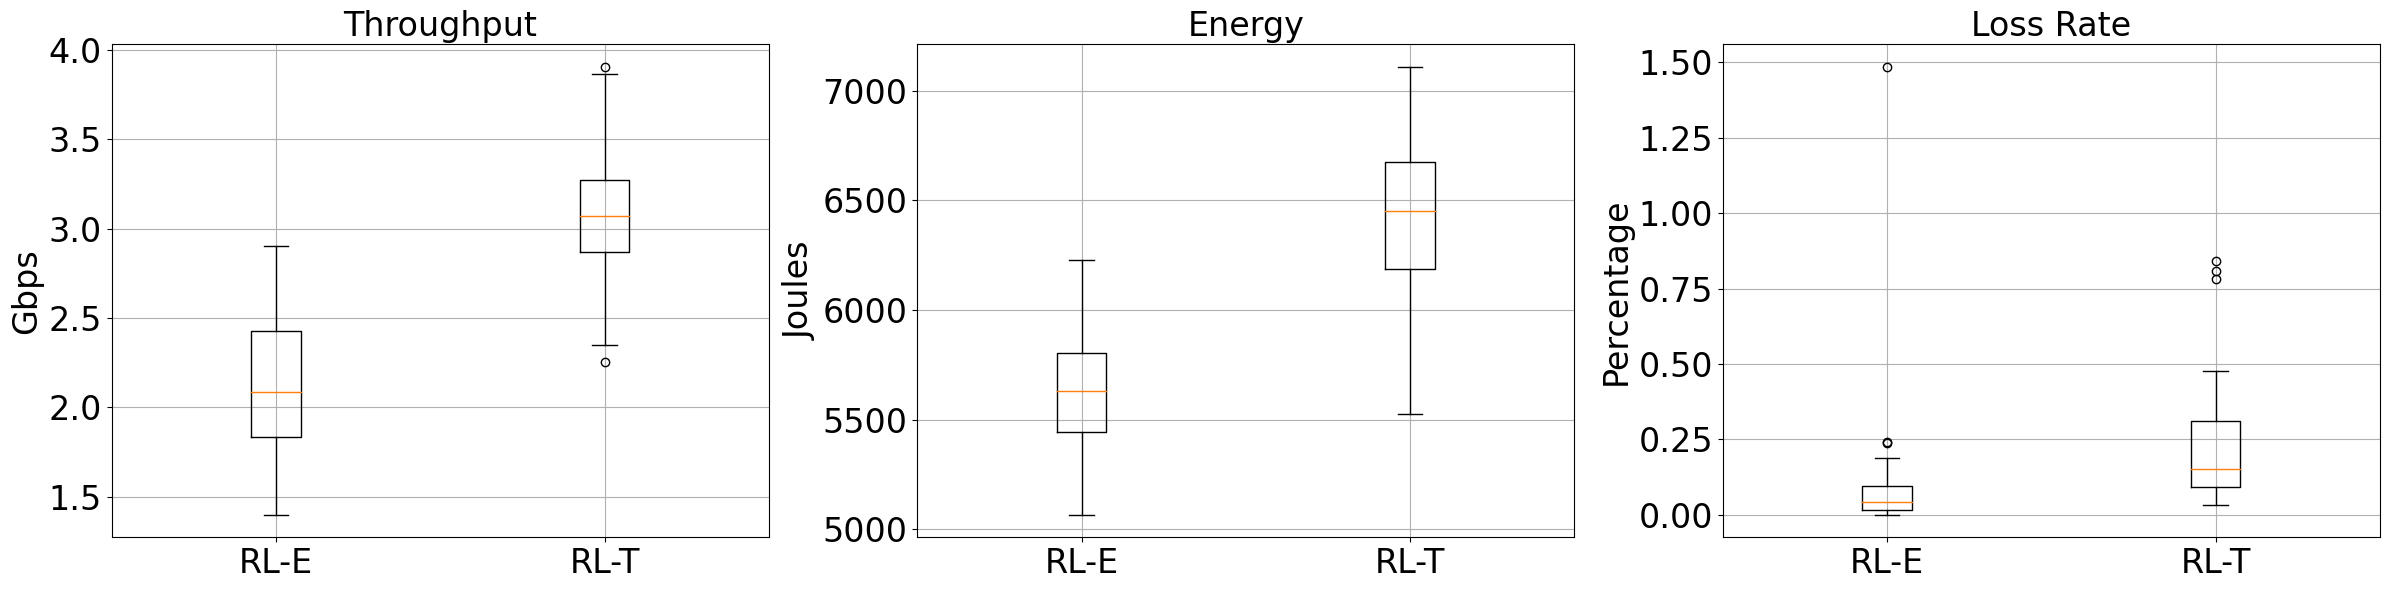

In [66]:
result_dictionary={"Throughput":[rl_throughput_list,rl_throughput_list_to],"Energy":[rl_energy_list,rl_energy_list_to],"lossRate":[rl_plr_list,rl_plr_list_to]}
import matplotlib.pyplot as plt

labels = ['RL-E','RL-T']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()


In [68]:
rl_mul_act_dictionary={'Throughput': [[5.8112, 5.7856000000000005, 6.556444444444445, 6.08, 6.364444444444444, 6.492444444444445, 7.040000000000001, 6.549333333333332, 6.030222222222222, 6.193777777777778, 6.26488888888889, 5.824, 6.129777777777777, 6.300444444444444, 6.5760000000000005, 6.193777777777778, 6.151111111111112, 5.9448888888888884, 6.492444444444445, 6.0373333333333346, 6.044444444444444, 6.584888888888889, 6.222222222222222, 6.4, 6.037333333333334, 5.895111111111111, 6.1226666666666665, 6.129777777777777, 6.26488888888889, 6.492444444444444, 6.151111111111112, 6.6773333333333325, 6.544000000000001, 5.980444444444444, 6.357333333333334, 6.129777777777777, 5.4656, 6.528000000000001, 6.52088888888889, 5.875200000000001, 6.286222222222222, 5.8368, 6.307555555555555, 6.350222222222223, 6.471111111111112, 6.286222222222221, 6.307555555555556, 6.456888888888889, 5.7856, 6.058666666666667]], 'Energy': [[4001.0, 3943.0, 3528.0, 3627.0, 3506.0, 3577.0, 3168.0, 3582.0, 3489.0, 3559.0, 3366.0, 3485.0, 3519.0, 3507.0, 3041.0, 3529.0, 3436.0, 3602.0, 3419.0, 3502.0, 3462.0, 3440.0, 3565.0, 2998.0, 3459.0, 3489.0, 3489.0, 3603.0, 3511.0, 3617.0, 3490.0, 3431.0, 3185.0, 3555.0, 3419.0, 3521.0, 3910.0, 3588.0, 3547.0, 3806.0, 3333.0, 3867.0, 3492.0, 3466.0, 3579.0, 3577.0, 3493.0, 3635.0, 3904.0, 3438.0]], 'lossRate': [[0.01959994630151698, 0.05053551855966104, 0.007841263375581633, 0.0, 0.0, 0.0, 0.00783698156128658, 0.02743692786280356, 0.007841263375581633, 0.022900851405402916, 0.007841263375581633, 0.05837250012094762, 0.0, 0.0, 0.07519532807718451, 0.01959994630151698, 0.020739883981059852, 0.03641384710363301, 0.04033983028257683, 0.01959994630151698, 0.005060183244505659, 0.029958472533511835, 0.035273909424090144, 0.007841263375581633, 0.029799916392896243, 0.021841160771802814, 0.02195865301731461, 0.05601379340514999, 0.028818534853968965, 0.0, 0.01959994630151698, 0.009218588552451983, 0.0, 0.02195865301731461, 0.015682526751163266, 0.06630494690475429, 0.02195865301731461, 0.02971738429281865, 0.0008590213764165593, 0.04269853699837446, 0.020739883981059852, 0.057395400396315396, 0.017055570113738563, 0.0, 0.09053316169356865, 0.0, 0.020485148254019574, 0.0, 0.029799916392896243, 0.05715373108469286]]}
rl_mul_act_throughput=rl_mul_act_dictionary['Throughput'][0]
rl_mul_act_energy=rl_mul_act_dictionary['Energy'][0]
rl_mul_act_lossRate=rl_mul_act_dictionary['lossRate'][0]

print(rl_mul_act_throughput)
print(rl_mul_act_energy)
print(rl_mul_act_lossRate)

[5.8112, 5.7856000000000005, 6.556444444444445, 6.08, 6.364444444444444, 6.492444444444445, 7.040000000000001, 6.549333333333332, 6.030222222222222, 6.193777777777778, 6.26488888888889, 5.824, 6.129777777777777, 6.300444444444444, 6.5760000000000005, 6.193777777777778, 6.151111111111112, 5.9448888888888884, 6.492444444444445, 6.0373333333333346, 6.044444444444444, 6.584888888888889, 6.222222222222222, 6.4, 6.037333333333334, 5.895111111111111, 6.1226666666666665, 6.129777777777777, 6.26488888888889, 6.492444444444444, 6.151111111111112, 6.6773333333333325, 6.544000000000001, 5.980444444444444, 6.357333333333334, 6.129777777777777, 5.4656, 6.528000000000001, 6.52088888888889, 5.875200000000001, 6.286222222222222, 5.8368, 6.307555555555555, 6.350222222222223, 6.471111111111112, 6.286222222222221, 6.307555555555556, 6.456888888888889, 5.7856, 6.058666666666667]
[4001.0, 3943.0, 3528.0, 3627.0, 3506.0, 3577.0, 3168.0, 3582.0, 3489.0, 3559.0, 3366.0, 3485.0, 3519.0, 3507.0, 3041.0, 3529.0, 

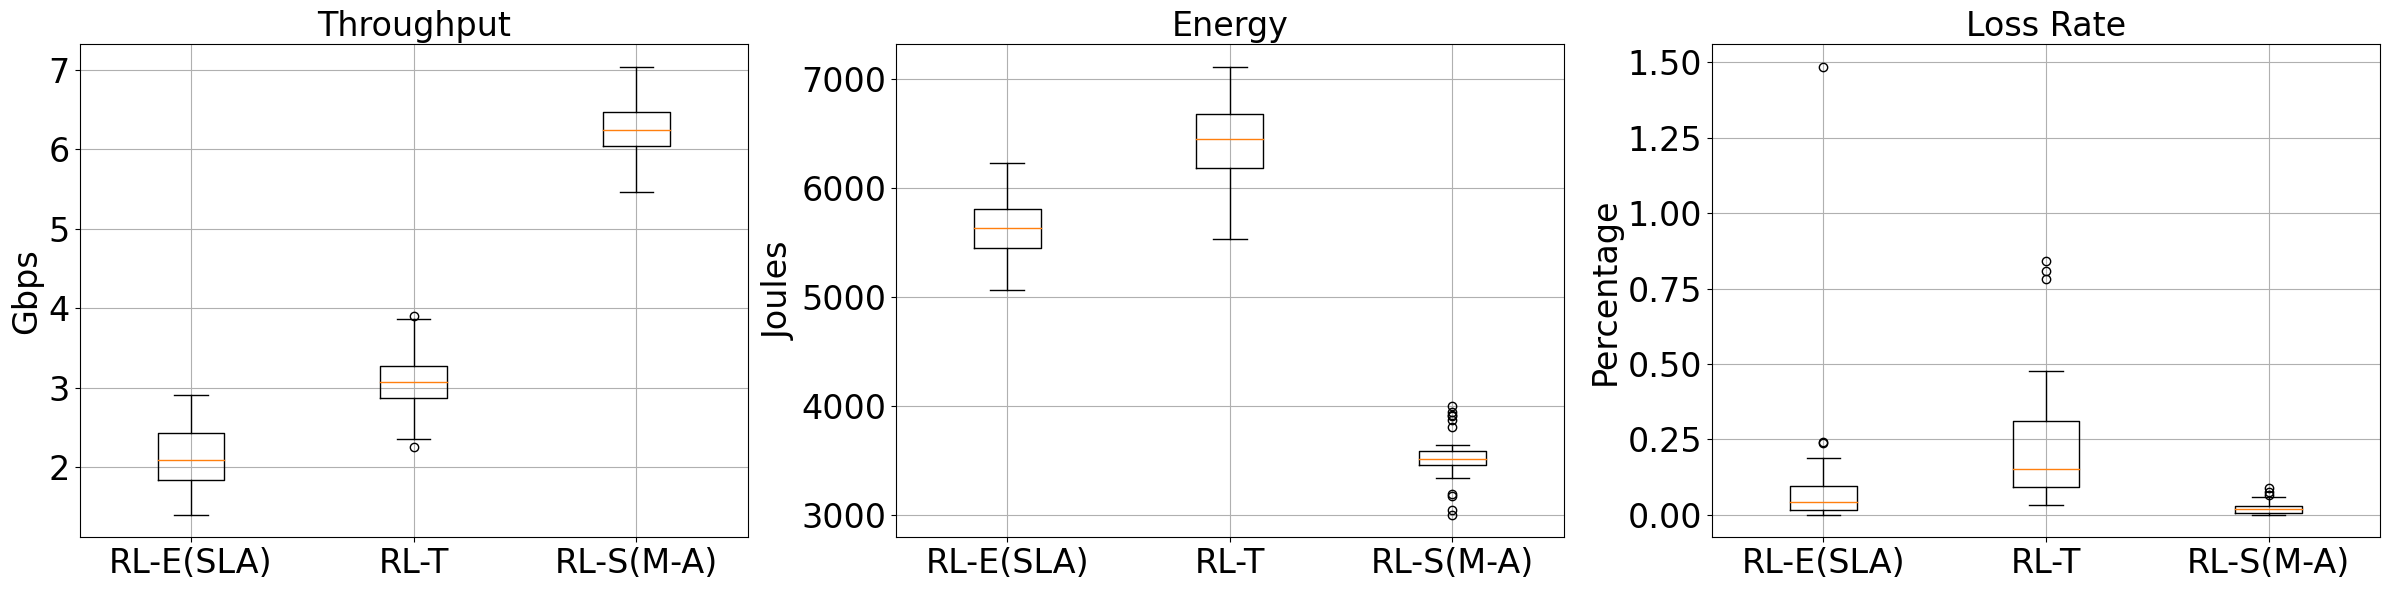

In [70]:
result_dictionary={"Throughput":[rl_throughput_list,rl_throughput_list_to,rl_mul_act_throughput],"Energy":[rl_energy_list,rl_energy_list_to,rl_mul_act_energy],"lossRate":[rl_plr_list,rl_plr_list_to,rl_mul_act_lossRate]}
import matplotlib.pyplot as plt

labels = ['RL-E(SLA)','RL-T', 'RL-S(M-A)']

# Assuming result_dictionary is already defined with the relevant data
# result_dictionary = {...}

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Font size for the ticks
tick_font_size = 24  # You can change this value as needed

# Plotting Throughput
axes[0].boxplot(result_dictionary['Throughput'], labels=labels)
axes[0].set_title('Throughput',fontsize=24)
axes[0].set_ylabel('Gbps',fontsize=24)
axes[0].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[0].grid(True)  # Adding grid

# Plotting Energy
axes[1].boxplot(result_dictionary['Energy'], labels=labels)
axes[1].set_title('Energy',fontsize=24)
axes[1].set_ylabel('Joules',fontsize=24)
axes[1].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[1].grid(True)  # Adding grid

# Plotting Loss Rate
axes[2].boxplot(result_dictionary['lossRate'], labels=labels)
axes[2].set_title('Loss Rate',fontsize=24)
axes[2].set_ylabel('Percentage',fontsize=24)
axes[2].tick_params(axis='both', which='major', labelsize=tick_font_size)  # Set tick font size
axes[2].grid(True)  # Adding grid

plt.tight_layout()
plt.show()
